<a href="https://colab.research.google.com/github/33GuessSo88/MLS_Data_Project/blob/main/Pillar9_Date_Loading_and_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO

1.   Commission needs some work, there are still obvious commission structres in the 'other' category that need to be dealt with.
2.   Coordinate cleaning, unable to clean 6, why?
3. RMS why does it only fix one data point, I thought there were 4. also stops at 97%, why. need to observe more examples of suspicious values.
4. Style analysis needs work, way too much reporting.
5. fix the restart thing when changing runtime.
6. there are 4 rows with no close price. need to address this.
7. why are there so many null commissions?
8. does the style code replace original style text? we should create a new standardized style column

9. review the parking code, still looks verbose. create standardized parking column?
10. after the random forest runs for condo name it shows a bunch of prediction mistakes, but some of them aren't mistakes. The sequential ones? Should I make them all one? Maybe not. There was one condo that the only difference was a THE.




# Data Loading and Combination Script

In [3]:
# =================================================================================
# GOOGLE DRIVE MOUNTING
# =================================================================================
"""
This cell handles mounting your Google Drive to access files.
Run this cell first and follow the authorization prompts.
If it fails, restart the runtime and try again.
"""

def mount_google_drive():
    """Attempt to mount Google Drive and verify the connection"""
    try:
        # Import the drive module from google.colab
        from google.colab import drive

        # Attempt to mount the drive
        print("⏳ Mounting Google Drive... (Check for the authorization prompt)")
        drive.mount('/content/drive')

        # Verify the mount was successful
        from pathlib import Path
        if Path('/content/drive').exists():
            print("\n✓ Google Drive mounted successfully!")
            print("📁 Your files are accessible at '/content/drive/My Drive/'")
        else:
            print("\n⚠️ Mount point exists but may not be working properly")

    except Exception as e:
        print("\n❌ Error mounting Google Drive:")
        print(f"Error details: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Click 'Runtime' -> 'Restart runtime'")
        print("2. Run this cell again")
        print("3. Complete the authorization process when prompted")
        return False

    return True

# Execute the mounting function
print("🔄 Starting Google Drive mount process...")
mount_google_drive()

🔄 Starting Google Drive mount process...
⏳ Mounting Google Drive... (Check for the authorization prompt)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✓ Google Drive mounted successfully!
📁 Your files are accessible at '/content/drive/My Drive/'


True

📦 Installing required packages...
✓ Packages installed successfully

📚 Importing libraries...
  Loading core Python libraries...
  Loading data manipulation libraries...
  Loading machine learning libraries...
  Loading visualization libraries...
  Loading system utilities...
✓ All libraries imported successfully

📝 Setting up logging...
=== Starting New Notebook Run ===
✓ Logger initialized successfully

🎨 Configuring display settings...

💾 Setting up memory monitoring...

🔍 Verifying setup...

🚀 Executing setup functions...
Step 1 completed: Display settings configuration
✓ Display settings configured successfully

Library versions:
pandas version: 2.2.2
numpy version: 1.26.4
scikit-learn version: 1.2.2
matplotlib version: 3.7.1
seaborn version: 0.13.2


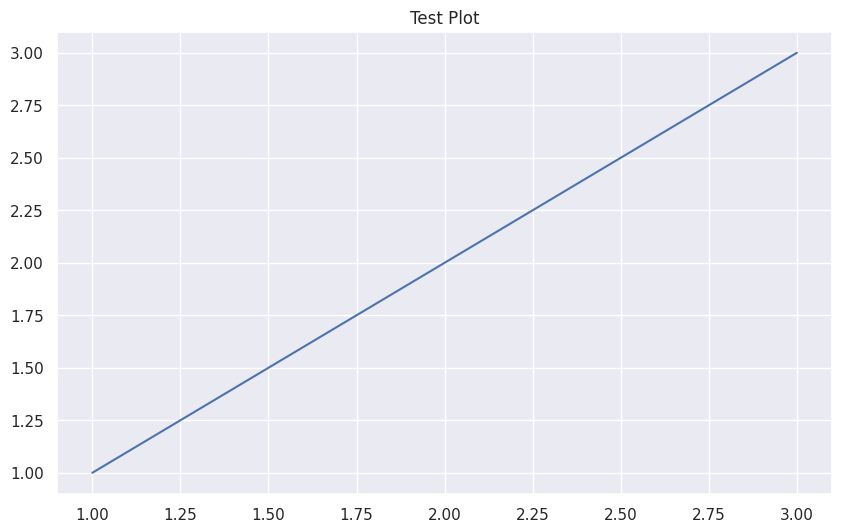


Initial memory usage:
--------------------
Current memory usage: 250.53 MB

Detailed Memory Info:
--------------------
Virtual Memory: 6370.38 MB
RAM Usage: 1.5%
Step 2 completed: Setup verification
✓ Setup verified successfully

NOTEBOOK RUN REPORT - 2025-02-05 14:32
Duration: 0:00:00.307740

INFO: === Starting New Notebook Run ===
INFO: Step 1 completed: Display settings configuration
INFO: 
Library versions:
INFO: pandas version: 2.2.2
INFO: numpy version: 1.26.4
INFO: scikit-learn version: 1.2.2
INFO: matplotlib version: 3.7.1
INFO: seaborn version: 0.13.2
INFO: 
Initial memory usage:
INFO: --------------------
INFO: Current memory usage: 250.53 MB
INFO: 
Detailed Memory Info:
INFO: --------------------
INFO: Virtual Memory: 6370.38 MB
INFO: RAM Usage: 1.5%
INFO: Step 2 completed: Setup verification

Log file location: /content/notebook_run_20250205_143235.log

✨ All setup steps completed successfully!


In [4]:
# =================================================================================
# SETUP AND IMPORTS
# =================================================================================

"""
This notebook cell handles the initial setup for our data analysis:
1. Installs required packages with specific versions
2. Imports all necessary libraries
3. Sets up logging functionality
4. Configures display settings
5. Implements memory monitoring
6. Verifies the setup
"""

# SECTION 1: Package Installation
# =================================================================================
print("📦 Installing required packages...")
try:
    !pip install tqdm==4.65.0 tabulate==0.9.0 scikit-learn==1.2.2 matplotlib==3.7.1 lightgbm seaborn
    print("✓ Packages installed successfully")
except Exception as e:
    print(f"❌ Error installing packages: {e}")

# SECTION 2: Library Imports
# =================================================================================
print("\n📚 Importing libraries...")
try:
    # Core Python libraries for basic operations
    print("  Loading core Python libraries...")
    import logging
    from datetime import datetime, timedelta
    from pathlib import Path
    import os
    import gc
    import re
    import time
    from collections import defaultdict

    # Data manipulation libraries
    print("  Loading data manipulation libraries...")
    import pandas as pd  # For DataFrame operations
    import numpy as np   # For numerical operations

    # Machine learning libraries
    print("  Loading machine learning libraries...")
    import sklearn  # Main scikit-learn module (needed for version checking)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    from sklearn.feature_extraction.text import TfidfVectorizer

    # Visualization libraries
    print("  Loading visualization libraries...")
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    # System monitoring and notebook utilities
    print("  Loading system utilities...")
    import psutil
    import threading
    from IPython.display import clear_output, display
    from tqdm.notebook import tqdm

    print("✓ All libraries imported successfully")
except Exception as e:
    print(f"❌ Error importing libraries: {e}")
    print(f"  Error details: {str(e)}")
    raise

# SECTION 3: Logging Setup
# =================================================================================
print("\n📝 Setting up logging...")

class NotebookLogger:
    """
    A custom logger class for tracking notebook execution and errors.
    Provides both file-based and in-memory logging capabilities.
    """

    def __init__(self):
        # Create timestamp for unique log identification
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.log_file = f'notebook_run_{self.timestamp}.log'
        self.start_time = datetime.now()
        self.step_counter = 1
        self.message_history = []

        # Configure logging settings
        logging.basicConfig(
            filename=self.log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

        self.log_info("=== Starting New Notebook Run ===")

    def log_info(self, message):
        """Log informational messages"""
        print(message)
        logging.info(message)
        self.message_history.append(f"INFO: {message}")

    def log_error(self, message):
        """Log error messages"""
        error_msg = f"ERROR: {message}"
        print(error_msg)
        logging.error(message)
        self.message_history.append(error_msg)

    def log_step_complete(self, step_name):
        """Track completion of notebook steps"""
        message = f"Step {self.step_counter} completed: {step_name}"
        self.log_info(message)
        self.step_counter += 1

    def display_log(self):
        """Display complete log contents"""
        print("\n" + "="*80)
        print(f"NOTEBOOK RUN REPORT - {datetime.now().strftime('%Y-%m-%d %H:%M')}")
        print(f"Duration: {datetime.now() - self.start_time}")
        print("="*80 + "\n")

        try:
            if os.path.exists(self.log_file):
                with open(self.log_file, 'r') as f:
                    print(f.read())
            else:
                print("\n".join(self.message_history))

            print("\n" + "="*80)
            print(f"Log file location: {os.path.abspath(self.log_file)}")
            print("="*80)

        except Exception as e:
            print("\nFalling back to memory-stored messages due to file access error:")
            print("\n".join(self.message_history))
            print(f"\nNote: Could not access log file due to: {str(e)}")

# Initialize our logger
logger = NotebookLogger()
print("✓ Logger initialized successfully")

# SECTION 4: Display Settings
# =================================================================================
print("\n🎨 Configuring display settings...")

def configure_display_settings():
    """Configure pandas and visualization settings for better readability"""
    try:
        # Make pandas output more readable
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.max_rows', 100)      # Show up to 100 rows
        pd.set_option('display.width', None)        # Auto-adjust display width
        pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format decimals

        # Set up visualization defaults
        sns.set_theme()  # Use seaborn's default theme
        plt.rcParams['figure.figsize'] = [10, 6]  # Set default figure size
        plt.rcParams['font.size'] = 12            # Set default font size

        logger.log_step_complete("Display settings configuration")
        print("✓ Display settings configured successfully")
    except Exception as e:
        logger.log_error(f"Error configuring display settings: {e}")
        raise

# SECTION 5: Memory Monitoring
# =================================================================================
print("\n💾 Setting up memory monitoring...")

def check_memory_usage(show_details=False, warning_threshold_mb=1000):
    """
    Monitor notebook memory usage and provide warnings if threshold is exceeded

    Args:
        show_details (bool): Display detailed memory statistics
        warning_threshold_mb (float): Memory threshold for warnings in MB

    Returns:
        float: Current memory usage in MB
    """
    try:
        gc.collect()  # Clean up unused memory
        process = psutil.Process()
        memory_usage = process.memory_info().rss / 1024 / 1024

        logger.log_info(f"Current memory usage: {memory_usage:.2f} MB")

        if memory_usage > warning_threshold_mb:
            logger.log_error(f"WARNING: Memory usage exceeds {warning_threshold_mb} MB")

        if show_details:
            logger.log_info("\nDetailed Memory Info:")
            logger.log_info("-" * 20)
            logger.log_info(f"Virtual Memory: {process.memory_info().vms / 1024 / 1024:.2f} MB")
            if hasattr(process.memory_info(), 'peak_wset'):
                logger.log_info(f"Peak Memory: {process.memory_info().peak_wset / 1024 / 1024:.2f} MB")
            logger.log_info(f"RAM Usage: {psutil.virtual_memory().percent}%")

        return memory_usage
    except Exception as e:
        logger.log_error(f"Error checking memory usage: {e}")
        return None

# SECTION 6: Setup Verification
# =================================================================================
print("\n🔍 Verifying setup...")

def verify_setup():
    """Verify library versions and test visualization capabilities"""
    try:
        # Check library versions
        logger.log_info("\nLibrary versions:")
        logger.log_info(f"pandas version: {pd.__version__}")
        logger.log_info(f"numpy version: {np.__version__}")
        logger.log_info(f"scikit-learn version: {sklearn.__version__}")  # Now this will work
        logger.log_info(f"matplotlib version: {matplotlib.__version__}")
        logger.log_info(f"seaborn version: {sns.__version__}")

        # Create test visualization
        plt.figure()
        sns.lineplot(x=[1, 2, 3], y=[1, 2, 3])
        plt.title("Test Plot")
        plt.show()

        # Check memory usage
        logger.log_info("\nInitial memory usage:")
        logger.log_info("-" * 20)
        check_memory_usage(show_details=True)

        logger.log_step_complete("Setup verification")
        print("✓ Setup verified successfully")
    except Exception as e:
        logger.log_error(f"Error during setup verification: {e}")
        raise

# Execute setup functions
# =================================================================================
print("\n🚀 Executing setup functions...")
configure_display_settings()
verify_setup()
logger.display_log()

print("\n✨ All setup steps completed successfully!")

# MLS CSV File Validation and Merging System

## Overview
This code block builds a robust data loading system that combines multiple CSV files while ensuring data consistency. It's specifically designed to handle monthly MLS data updates and catch potential column name changes or loading issues before they cause problems downstream.

## Technical Details
### Input
* Source: MLS CSV files from Pillar9 system
* Location: Google Drive folder containing multiple CSV export files
* Path: '/content/drive/My Drive/Realtor/Data Project/Pillar9_RawCSV_Files'
* Current Scale: ~400,000 rows × 28 columns

### Output
* Consolidated DataFrame: `combined_data`
* Metadata Columns Added:
  * `source_file`: Tracks which CSV file each record came from
  * `data_load_date`: Records when the data was loaded
  * `data_load_timestamp`: Precise timestamp for tracking

### Key Operations
1. Column Validation System
   * Creates reference column list from first file
   * Compares all subsequent files against reference
   * Identifies and reports:
     * Missing columns
     * Extra columns
     * Column name mismatches

2. File Processing
   * Discovers all CSV files in specified directory
   * Loads each file with error handling
   * Tracks successful and failed loads
   * Combines validated files into single DataFrame

3. Comprehensive Error Handling
   * Validates folder existence
   * Tracks failed file loads with detailed error messages
   * Prevents merging if column validation fails
   * Provides clear error messages for troubleshooting

### Quality Checks
The code automatically verifies and reports:
* Number of files found and processed
* Success/failure count for file loading
* Detailed column validation results
* File-by-file row and column counts
* Final dataset dimensions
* Memory usage throughout processing

## Data Pipeline Note
This enhanced loading system acts as a guardian for our data pipeline, ensuring that column inconsistencies are caught early. This is crucial for maintaining data integrity, especially with monthly MLS data updates.

## Console Output Guide
Watch for these key messages:
* Initial file count discovery
* Column validation results
* Any column mismatches (crucial for MLS updates)
* Processing summary with success/failure counts
* Final dataset statistics

## Error Resolution Guide
If column mismatch errors occur:
1. Check the validation output for specific mismatched columns
2. Compare with previous month's data
3. Review recent MLS system changes
4. Update column mapping if needed

In [5]:
# =================================================================================
# CSV FILE MERGING AND VALIDATION
# =================================================================================

def validate_columns(dataframes, verbose=True):
    """
    Check if all dataframes have the same columns.

    Args:
        dataframes (list): List of pandas dataframes to validate
        verbose (bool): Whether to print detailed information

    Returns:
        bool: True if all dataframes have matching columns, False otherwise
    """
    # First, check if we received any dataframes
    if not dataframes:
        logger.log_error("No dataframes provided for validation!")
        return False

    # Get columns from first dataframe as reference
    reference_columns = set(dataframes[0].columns)

    # Add more detailed initial reporting
    if verbose:
        logger.log_info("\nColumn Validation Report:")
        logger.log_info("-" * 50)
        logger.log_info(f"Number of dataframes to validate: {len(dataframes)}")
        logger.log_info(f"Number of reference columns: {len(reference_columns)}")
        logger.log_info("\nReference columns:")
        for col in sorted(reference_columns):
            logger.log_info(f"  - {col}")

    # Check each dataframe against the reference
    all_valid = True  # Track if all dataframes are valid
    for i, df in enumerate(dataframes[1:], start=1):
        current_columns = set(df.columns)

        # Check for mismatches
        missing_cols = reference_columns - current_columns
        extra_cols = current_columns - reference_columns

        if missing_cols or extra_cols:
            all_valid = False
            if verbose:
                logger.log_error(f"\nMismatch found in dataframe {i}:")
                logger.log_error("-" * 30)
                if missing_cols:
                    logger.log_error("Missing columns:")
                    for col in sorted(missing_cols):
                        logger.log_error(f"  - {col}")
                if extra_cols:
                    logger.log_error("Extra columns:")
                    for col in sorted(extra_cols):
                        logger.log_error(f"  - {col}")

    if verbose:
        logger.log_info("\nValidation Summary:")
        logger.log_info("-" * 30)
        if all_valid:
            logger.log_info("✓ All files have matching columns!")
        else:
            logger.log_error("✗ Column mismatches detected!")

    return all_valid

def merge_real_estate_files(folder_path):
    """
    Merge all CSV files from a specified folder into a single DataFrame.
    Includes validation for column consistency across files.

    Args:
        folder_path (str or Path): Path to the folder containing CSV files

    Returns:
        pandas.DataFrame: Combined dataset from all CSV files

    Raises:
        ValueError: If no files are found or if column validation fails
    """
    # Convert to Path object and verify folder exists
    folder_path = Path(folder_path)
    if not folder_path.exists():
        logger.log_error(f"Folder not found: {folder_path}")
        raise ValueError(f"Folder not found: {folder_path}")

    # Get list of CSV files
    csv_files = list(folder_path.glob('*.csv'))
    if not csv_files:
        logger.log_error(f"No CSV files found in {folder_path}")
        raise ValueError(f"No CSV files found in {folder_path}")

    logger.log_info(f"Found {len(csv_files)} CSV files")

    # Track processing statistics
    all_dataframes = []
    failed_files = []
    total_rows = 0

    # Log memory usage before processing
    logger.log_info("\nInitial memory state before processing:")
    check_memory_usage(show_details=True)

    # Read each CSV file with detailed tracking
    for file_path in tqdm(csv_files, desc="Processing CSV files"):
        try:
            # Read the CSV with error handling for common issues
            df = pd.read_csv(
                file_path,
                encoding='utf-8',  # Explicit encoding
                low_memory=False,  # Prevent mixed type inference warnings
                on_bad_lines='warn'  # Don't fail on problematic lines
            )

            # Enhanced validation
            if len(df.columns) == 0:
                raise ValueError("File contains no columns")
            if len(df) == 0:
                raise ValueError("File contains no data rows")

            # Add metadata columns
            df['source_file'] = file_path.name
            df['data_load_date'] = datetime.now().date()
            df['data_load_timestamp'] = datetime.now()

            # Update statistics
            total_rows += len(df)
            all_dataframes.append(df)

            # Log file processing success
            logger.log_info(f"\nLoaded: {file_path.name}")
            logger.log_info(f"  Rows: {len(df):,}")
            logger.log_info(f"  Columns: {len(df.columns)}")
            logger.log_info(f"  Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

        except Exception as e:
            failed_files.append((file_path.name, str(e)))
            logger.log_error(f"\nError reading {file_path.name}:")
            logger.log_error(f"Error details: {str(e)}")
            continue

    # Enhanced processing summary
    logger.log_info("\n" + "="*50)
    logger.log_info("Processing Summary:")
    logger.log_info("="*50)
    logger.log_info(f"Total files found: {len(csv_files):,}")
    logger.log_info(f"Successfully loaded: {len(all_dataframes):,}")
    logger.log_info(f"Failed to load: {len(failed_files):,}")
    logger.log_info(f"Total rows processed: {total_rows:,}")

    # Show failed files with more detail
    if failed_files:
        logger.log_error("\nFailed Files Report:")
        logger.log_error("-" * 30)
        for i, (file_name, error) in enumerate(failed_files, 1):
            logger.log_error(f"{i}. {file_name}")
            logger.log_error(f"   Error: {error}")

    # Validate column consistency
    if not validate_columns(all_dataframes):
        error_msg = ("Column mismatch detected between files. "
                    "Please review the validation output above and ensure all files have matching columns.")
        logger.log_error(error_msg)
        raise ValueError(error_msg)

    # Combine dataframes if we have any
    if all_dataframes:
        logger.log_info("\nMerging validated dataframes...")
        combined_df = pd.concat(all_dataframes, ignore_index=True)

        # Memory cleanup
        del all_dataframes
        gc.collect()

        # Final dataset summary
        logger.log_info("\nFinal Dataset Summary:")
        logger.log_info("-" * 30)
        logger.log_info(f"Total rows: {len(combined_df):,}")
        logger.log_info(f"Total columns: {len(combined_df.columns)}")
        logger.log_info(f"Memory usage: {combined_df.memory_usage().sum() / 1024**2:.2f} MB")

        # Log step completion
        logger.log_step_complete("CSV file merging")

        return combined_df
    else:
        logger.log_error("No CSV files were successfully processed")
        raise ValueError("No CSV files were successfully processed")

# Main execution block
try:
    # Define folder path and ensure it exists
    folder_path = Path('/content/drive/My Drive/Realtor/Data Project/Pillar9_RawCSV_Files')

    logger.log_info("Starting data merge process...")
    logger.log_info(f"Source folder: {folder_path}")

    # Process and merge files
    combined_data = merge_real_estate_files(folder_path)

    # Success message and column overview
    logger.log_info("\nData loading completed successfully! 🎉")
    logger.log_info("\nColumn Overview:")
    logger.log_info("-" * 30)
    for i, col in enumerate(sorted(combined_data.columns), 1):
        logger.log_info(f"{i:3d}. {col}")

    # Save memory usage information
    logger.log_info("\nFinal Memory Usage:")
    logger.log_info("-" * 30)
    check_memory_usage(show_details=True)

except Exception as e:
    logger.log_error("\nError during execution:")
    logger.log_error("-" * 30)
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

Starting data merge process...
Source folder: /content/drive/My Drive/Realtor/Data Project/Pillar9_RawCSV_Files
Found 83 CSV files

Initial memory state before processing:
Current memory usage: 244.98 MB

Detailed Memory Info:
--------------------
Virtual Memory: 6364.67 MB
RAM Usage: 1.4%


Processing CSV files:   0%|          | 0/83 [00:00<?, ?it/s]


Loaded: PBI - Export1.csv
  Rows: 4,791
  Columns: 43
  Memory usage: 1.57 MB

Loaded: PBI - Export1(1).csv
  Rows: 4,633
  Columns: 43
  Memory usage: 1.52 MB

Loaded: PBI - Export1(2).csv
  Rows: 4,818
  Columns: 43
  Memory usage: 1.58 MB

Loaded: PBI - Export1(3).csv
  Rows: 4,724
  Columns: 43
  Memory usage: 1.55 MB

Loaded: PBI - Export1(5).csv
  Rows: 4,723
  Columns: 43
  Memory usage: 1.55 MB

Loaded: PBI - Export1(6).csv
  Rows: 4,623
  Columns: 43
  Memory usage: 1.52 MB

Loaded: PBI - Export1(7).csv
  Rows: 4,484
  Columns: 43
  Memory usage: 1.47 MB

Loaded: PBI - Export1(8).csv
  Rows: 4,736
  Columns: 43
  Memory usage: 1.55 MB

Loaded: PBI - Export1(9).csv
  Rows: 4,963
  Columns: 43
  Memory usage: 1.63 MB

Loaded: PBI - Export1(10).csv
  Rows: 4,798
  Columns: 43
  Memory usage: 1.57 MB

Loaded: PBI - Export1(11).csv
  Rows: 4,951
  Columns: 43
  Memory usage: 1.62 MB

Loaded: PBI - Export1(12).csv
  Rows: 4,993
  Columns: 43
  Memory usage: 1.64 MB

Loaded: PBI - E

# Data Cleaning: Column Name Standardization

## Overview
This code block implements a systematic approach to clean and standardize DataFrame column names. It ensures consistent naming conventions across our dataset, making it easier to work with and reference columns in subsequent analysis.

## Technical Details

### Input
* DataFrame: `combined_data` from previous merging step
* Column Names: Mix of raw MLS column names with various formats
* Special Characters: Handles ®, #, spaces, and other special characters

### Output
* DataFrame with standardized column names
* Comparison report showing original vs. cleaned names
* Detailed log of changes made

### Cleaning Rules
1. Specific Name Mappings
   * MLS® # → MLS_Num
   * LINC # → LINC_Num
   * DOM → Days_On_Market
   * CDOM → Cumulative_Days_On_Market
   * Other domain-specific transformations

2. General Cleaning Rules
   * Remove leading/trailing spaces
   * Replace spaces with underscores
   * Replace # with Num
   * Remove ® symbol
   * Replace & with 'and'
   * Replace slashes with underscores
   * Remove parentheses
   * Replace periods with underscores
   * Replace hyphens with underscores

### Quality Checks
The code verifies and reports:
* Number of columns processed
* Which columns were modified
* Total number of changes made
* Sample of data with new column names

## Process Monitoring
Watch for these console outputs:
* Initial column count
* List of modified column names
* Confirmation of successful cleaning
* Any error messages if issues occur

## Error Handling
The code includes comprehensive error checking:
* Creates safe copy of DataFrame
* Tracks all column name changes
* Provides detailed error messages if problems occur
* Maintains original error handling behavior

In [6]:
def clean_column_names(df, verbose=True):
    """
    Clean and standardize DataFrame column names for consistency and readability.

    Args:
        df (pandas.DataFrame): Input DataFrame with columns to be cleaned
        verbose (bool): Whether to print the comparison table (default: True)

    Returns:
        pandas.DataFrame: DataFrame with cleaned column names
    """
    try:
        logger.log_info("Starting column name cleaning process...")

        # Create a copy to avoid modifying the original DataFrame
        df = df.copy()
        logger.log_info(f"Created copy of DataFrame with {len(df.columns)} columns")

        # Store original columns for comparison
        original_cols = df.columns.tolist()

        # Define specific column name mappings
        # Dictionary maps original column names to their cleaned versions
        rename_dict = {
            'MLS® #': 'MLS_Num',
            'LINC #': 'LINC_Num',
            'DOM': 'Days_On_Market',
            'CDOM': 'Cumulative_Days_On_Market',
            'Bedrms Above Grade': 'Bedrooms_Above_Grade',
            'BG Fin Area': 'Below_Grade_Finished_Area',
            '# Garage Sp': 'Num_Garage_Spaces'
        }

        # STEP 1: Apply specific renaming rules
        df.columns = df.columns.map(lambda x: rename_dict.get(x, x))
        logger.log_info("Applied specific column renaming rules")

        # STEP 2: Apply general cleaning rules to all columns
        df.columns = df.columns.map(lambda x: x
            .strip()                    # Remove leading/trailing spaces
            .replace(' ', '_')          # Replace spaces with underscores
            .replace('#', 'Num')        # Replace # with Num
            .replace('®', '')           # Remove registered trademark symbol
            .replace('&', 'and')        # Replace & with 'and'
            .replace('/', '_')          # Replace slashes with underscore
            .replace('(', '')           # Remove parentheses
            .replace(')', '')           # Remove parentheses
            .replace('.', '_')          # Replace periods with underscore
            .replace('-', '_')          # Replace hyphens with underscore
        )
        logger.log_info("Applied general column cleaning rules")

        # STEP 3: Create comparison table if verbose is True
        if verbose:
            # Create comparison DataFrame
            comparison = pd.DataFrame({
                'Original': original_cols,
                'New': df.columns.tolist()
            })

            # Add a "Changed" column to highlight modifications
            comparison['Changed'] = comparison['Original'] != comparison['New']

            # Display settings for better readability
            pd.set_option('display.max_rows', None)  # Show all rows
            pd.set_option('display.max_colwidth', None)  # Show full column content

            logger.log_info("\nColumn Name Changes:")
            logger.log_info("-" * 80)

            # Display only changed columns if there are any
            changed_cols = comparison[comparison['Changed']]
            if not changed_cols.empty:
                logger.log_info("\nModified Columns:")
                # Convert the comparison to a string format for logging
                comparison_str = changed_cols[['Original', 'New']].to_string(index=False)
                for line in comparison_str.split('\n'):
                    logger.log_info(line)
                logger.log_info(f"\nTotal columns modified: {len(changed_cols)}")
            else:
                logger.log_info("No columns were modified.")

            logger.log_info(f"Total columns: {len(df.columns)}")

        return df

    except Exception as e:
        logger.log_error(f"Error in clean_column_names:")
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise  # Re-raise the exception after logging

# Execute the column cleaning
try:
    logger.log_info("Starting column name cleaning process...")
    combined_data = clean_column_names(combined_data)
    logger.log_info("Column cleaning completed successfully!")

    # Display a sample of the cleaned DataFrame
    logger.log_info("\nFirst few rows with cleaned column names:")
    # Convert the head output to a string format for logging
    sample_data = combined_data.head(3).to_string()
    for line in sample_data.split('\n'):
        logger.log_info(line)

    # Mark step completion
    logger.log_step_complete("Column name cleaning")

except Exception as e:
    logger.log_error(f"\nError during column cleaning:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")
    raise  # Re-raise the exception to maintain original error handling behavior

Starting column name cleaning process...
Starting column name cleaning process...
Created copy of DataFrame with 43 columns
Applied specific column renaming rules
Applied general column cleaning rules

Column Name Changes:
--------------------------------------------------------------------------------

Modified Columns:
              Original                       New
                MLS® #                   MLS_Num
                LINC #                  LINC_Num
 Listing Contract Date     Listing_Contract_Date
Purchase Contract Date    Purchase_Contract_Date
            Close Date                Close_Date
       Previous Status           Previous_Status
                  CDOM Cumulative_Days_On_Market
                   DOM            Days_On_Market
   Original List Price       Original_List_Price
   Previous List Price       Previous_List_Price
           Close Price               Close_Price
             RMS Total                 RMS_Total
     Street Dir Suffix         Street_Di

# Data Analysis: Temporal Coverage and Quality Assessment

## Overview
This code block examines the quality and completeness of dates in our real estate dataset. It identifies gaps in our temporal data, analyzes listing patterns over time, and provides detailed statistics about our date coverage. This analysis is crucial for understanding any potential data collection issues or seasonal patterns in our MLS listings.

## Technical Details

### Input
* DataFrame: Cleaned dataset with transaction dates
* Primary Date Column: 'Close_Date'
* Date Format: Handles multiple input formats automatically

### Key Analysis Components
1. Date Validation and Cleaning
   * Checks for invalid date formats
   * Converts strings to datetime objects
   * Reports problematic date entries
   * Creates backup of original dates

2. Coverage Analysis
   * Calculates total date range
   * Identifies missing dates
   * Groups consecutive missing dates into ranges
   * Analyzes patterns in missing data

3. Temporal Distribution Analysis
   * Monthly listing counts
   * Year-over-year comparisons
   * Growth rate calculations
   * Seasonal pattern identification

### Quality Metrics Reported
* Total date range covered
* Number of unique dates
* Average listings per date
* Invalid date entries
* Gaps in coverage
* Longest periods without data

## Process Output
The analysis provides:
* Date range summary
* Missing date patterns
* Monthly distribution tables
* Year-over-year growth rates
* Optional CSV export of missing dates
* Comprehensive error logging

## Error Protection
* Creates date column backup
* Validates date formats
* Restores original data if errors occur
* Provides detailed error messages

In [7]:
# =================================================================================
# DATE COVERAGE ANALYSIS
# =================================================================================

def analyze_date_coverage(df, date_column='Close_Date', save_missing_dates=False):
    """
    Analyze date coverage in a DataFrame to identify gaps and patterns in temporal data.
    This function helps identify missing dates and understand the temporal distribution
    of real estate listings.

    Args:
        df (pandas.DataFrame): Input DataFrame containing real estate listings
        date_column (str): Name of the column containing dates (default: 'Close_Date')
        save_missing_dates (bool): Whether to save missing dates to CSV (default: False)

    Returns:
        dict: Summary statistics about the date coverage
    """
    logger.log_info("\nStarting Date Coverage Analysis...")
    logger.log_info("=" * 50)

    # STEP 1: Prepare and validate date column
    try:
        # First, check if the column exists
        if date_column not in df.columns:
            error_msg = f"Column '{date_column}' not found in DataFrame"
            logger.log_error(error_msg)
            raise ValueError(error_msg)

        logger.log_info(f"\nProcessing date column: {date_column}")

        # Show sample of raw dates before conversion
        logger.log_info("\nSample of raw dates before conversion:")
        sample_dates = df[date_column].head().to_string()
        for line in sample_dates.split('\n'):
            logger.log_info(line)

        # Convert date column to datetime, handling various date formats
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

        # Check for and report any dates that couldn't be parsed
        invalid_dates = df[date_column].isnull().sum()
        if invalid_dates > 0:
            logger.log_error(f"\n⚠️ Warning: Found {invalid_dates:,} invalid dates ({invalid_dates/len(df):.1%} of total)")

            # Show examples of problematic dates
            logger.log_error("\nSample of rows with invalid dates:")
            invalid_mask = df[date_column].isnull()
            invalid_samples = df[invalid_mask].head().to_string()
            for line in invalid_samples.split('\n'):
                logger.log_error(line)

    except Exception as e:
        error_msg = f"Error processing date column: {str(e)}"
        logger.log_error(error_msg)
        raise ValueError(error_msg)

    # STEP 2: Analyze date range and basic statistics
    earliest_date = df[date_column].min()
    latest_date = df[date_column].max()
    date_range_days = (latest_date - earliest_date).days
    total_dates = df[date_column].nunique()

    logger.log_info(f"\nDate Range Summary:")
    logger.log_info("-" * 30)
    logger.log_info(f"Earliest date: {earliest_date.strftime('%Y-%m-%d')}")
    logger.log_info(f"Latest date: {latest_date.strftime('%Y-%m-%d')}")
    logger.log_info(f"Total date range: {date_range_days:,} days ({date_range_days/365.25:.1f} years)")
    logger.log_info(f"Number of unique dates: {total_dates:,}")
    logger.log_info(f"Average listings per date: {len(df)/total_dates:.1f}")

    # STEP 3: Find missing dates
    logger.log_info("\nAnalyzing missing dates...")
    full_date_range = pd.date_range(start=earliest_date, end=latest_date, freq='D')
    expected_dates = set(full_date_range.date)
    actual_dates = set(df[date_column].dt.date.unique())
    missing_dates = sorted(expected_dates - actual_dates)

    # STEP 4: Report missing dates and identify patterns
    if missing_dates:
        logger.log_info(f"\nFound {len(missing_dates):,} missing dates")

        # Group consecutive missing dates into ranges
        ranges = []
        range_start = missing_dates[0]
        prev_date = missing_dates[0]

        for date in missing_dates[1:]:
            if (date - prev_date).days > 1:
                ranges.append((range_start, prev_date))
                range_start = date
            prev_date = date
        ranges.append((range_start, prev_date))

        # Analyze and report missing date patterns
        logger.log_info("\nMissing Date Patterns:")
        logger.log_info("-" * 30)

        # Show the longest gaps
        ranges.sort(key=lambda x: (x[1] - x[0]).days, reverse=True)
        logger.log_info("\nLongest gaps (top 5):")
        for start, end in ranges[:5]:
            days_missing = (end - start).days + 1
            logger.log_info(f"- {start} to {end} ({days_missing:,} days)")

        # Save missing dates if requested
        if save_missing_dates:
            try:
                missing_dates_df = pd.DataFrame({
                    'Missing_Date': missing_dates,
                    'Day_of_Week': [d.strftime('%A') for d in missing_dates],
                    'Month': [d.strftime('%B') for d in missing_dates]
                })
                save_path = 'missing_dates.csv'
                missing_dates_df.to_csv(save_path, index=False)
                logger.log_info(f"\n✓ Saved missing dates to: {save_path}")
            except Exception as e:
                logger.log_error(f"\n⚠️ Error saving missing dates: {str(e)}")
    else:
        logger.log_info("\n✓ No missing dates found! The date coverage is complete.")

    # STEP 5: Temporal distribution analysis
    logger.log_info("\nTemporal Distribution Analysis:")
    logger.log_info("-" * 30)

    # Monthly distribution with year-over-year comparison
    monthly_counts = df.groupby([
        df[date_column].dt.year,
        df[date_column].dt.month
    ]).size().unstack()

    logger.log_info("\nMonthly Listings by Year:")
    monthly_str = monthly_counts.fillna(0).astype(int).to_string()
    for line in monthly_str.split('\n'):
        logger.log_info(line)

    # Yearly totals
    yearly_counts = df[date_column].dt.year.value_counts().sort_index()
    logger.log_info("\nYearly Totals:")
    for year, count in yearly_counts.items():
        logger.log_info(f"{year}: {count:,} listings")

    # Calculate year-over-year growth
    logger.log_info("\nYear-over-Year Growth:")
    for i in range(1, len(yearly_counts)):
        current_year = yearly_counts.index[i]
        previous_year = yearly_counts.index[i-1]
        growth = (yearly_counts[current_year] - yearly_counts[previous_year]) / yearly_counts[previous_year] * 100
        logger.log_info(f"{current_year}: {growth:+.1f}%")

    # Return summary statistics
    return {
        'earliest_date': earliest_date,
        'latest_date': latest_date,
        'total_days': date_range_days,
        'missing_dates': len(missing_dates),
        'total_listings': len(df)
    }

# Main execution block
try:
    logger.log_info("Starting comprehensive date coverage analysis...")

    # Create a backup of the date column before analysis
    backup_dates = combined_data['Close_Date'].copy()
    logger.log_info("Created backup of date column")

    # Run the analysis
    results = analyze_date_coverage(combined_data, save_missing_dates=True)

    # Print final summary
    logger.log_info("\nAnalysis Summary:")
    logger.log_info("=" * 50)
    logger.log_info(f"Total Listings Analyzed: {results['total_listings']:,}")
    logger.log_info(f"Date Range: {results['total_days']:,} days")
    logger.log_info(f"Missing Dates: {results['missing_dates']:,}")

    logger.log_info("\nAnalysis completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Date coverage analysis")

except Exception as e:
    logger.log_error(f"\n❌ Error during analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore the original dates if there was an error
    combined_data['Close_Date'] = backup_dates
    logger.log_info("\nRestored original dates due to error.")

Starting comprehensive date coverage analysis...
Created backup of date column

Starting Date Coverage Analysis...

Processing date column: Close_Date

Sample of raw dates before conversion:
0    08/07/2024
1    08/28/2024
2    09/04/2024
3    08/02/2024
4    08/16/2024

Date Range Summary:
------------------------------
Earliest date: 2010-01-01
Latest date: 2025-01-17
Total date range: 5,495 days (15.0 years)
Number of unique dates: 5,496
Average listings per date: 72.9

Analyzing missing dates...

✓ No missing dates found! The date coverage is complete.

Temporal Distribution Analysis:
------------------------------

Monthly Listings by Year:
Close_Date    1     2     3     4     5     6     7     8     9     10    11    12
Close_Date                                                                        
2010        1346  1871  2401  2340  2230  1796  1566  1532  1569  1390  1471  1252
2011        1285  1908  2243  2059  2231  2374  2018  1889  1759  1625  1632  1263
2012        12

In [8]:
# prompt: show me a list of column names

print(combined_data.columns.tolist())

['MLS_Num', 'LINC_Num', 'City', 'Listing_Contract_Date', 'Purchase_Contract_Date', 'Close_Date', 'Previous_Status', 'Cumulative_Days_On_Market', 'Days_On_Market', 'Original_List_Price', 'Previous_List_Price', 'Close_Price', 'RMS_Total', 'Street_Dir_Suffix', 'Structure_Type', 'Tax_Assessed_Value', 'Commission', 'Suite', 'Basement', 'Style', 'Subdivision_Name', 'Property_Sub_Type', 'Year_Built', 'Bedrooms_Above_Grade', 'Bedrooms_Below_Grade', 'Total_Baths', 'Full_Baths', 'Below_Grade_Finished_Area', 'Condo_Fee', 'Condo_Type', 'Lot_Size_SF', 'Postal_Code', 'Garage_YN', 'Num_Garage_Spaces', 'Parking', 'Condo_Name', 'Latitude', 'Longitude', 'Zoning', 'Occupant_Type', 'source_file', 'data_load_date', 'data_load_timestamp']


# Data Cleaning: Duplicate Record Analysis and Removal

## Overview
This code block implements a systematic approach to identify, analyze, and remove duplicate listings from our MLS dataset. It provides detailed insights about duplicate patterns and ensures data integrity by removing redundant entries while preserving the most relevant records.

## Technical Details

### Input
* DataFrame: Current state of combined_data
* Key Identifier: MLS_Num (unique listing identifier)
* Date Column: Close_Date (for temporal analysis)
* Source Tracking: source_file (original file tracking)

### Key Operations
1. Initial Analysis
   * Count total rows vs unique identifiers
   * Calculate duplication rate
   * Verify column existence

2. Detailed Duplicate Investigation
   * Identify all duplicated records
   * Analyze frequency of duplications
   * Track source files containing duplicates
   * Check for price discrepancies in duplicates

3. Data Cleaning
   * Remove duplicate entries
   * Keep first occurrence of each MLS number
   * Verify successful duplicate removal
   * Return cleaned dataset with statistics

### Quality Checks
The code verifies and reports:
* Total number of records analyzed
* Number of unique MLS numbers
* Duplication rate percentage
* Source files containing duplicates
* Price discrepancies between duplicates
* Verification of complete duplicate removal

## Process Monitoring
Key metrics tracked:
* Initial row count
* Number of unique identifiers
* Duplicates removed
* Remaining record count
* Source file distribution
* Data discrepancies

## Error Protection
* Creates safe copy of DataFrame
* Validates input data types
* Checks column existence
* Provides detailed error logging
* Returns both cleaned data and summary statistics

In [9]:
# =================================================================================
# DUPLICATE ANALYSIS AND REMOVAL
# =================================================================================

def analyze_duplicates(df, id_column='MLS_Num', date_column='Close_Date', verbose=True):
    """
    Analyze and remove duplicates from real estate dataset.

    Args:
        df (pandas.DataFrame): Input DataFrame
        id_column (str): Column containing unique identifiers (default: 'MLS_Num')
        date_column (str): Column containing date information (default: 'Close_Date')
        verbose (bool): Whether to print detailed analysis (default: True)

    Returns:
        pandas.DataFrame: DataFrame with duplicates removed
        dict: Summary statistics about the duplicate analysis
    """
    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            error_msg = "Input must be a pandas DataFrame"
            logger.log_error(error_msg)
            raise TypeError(error_msg)

        for col in [id_column, date_column]:
            if col not in df.columns:
                error_msg = f"Column '{col}' not found in DataFrame"
                logger.log_error(error_msg)
                raise ValueError(error_msg)

        # Create a copy to preserve original data
        df = df.copy()
        logger.log_info("Created copy of input DataFrame for safe processing")

        # STEP 1: Initial Analysis
        total_rows = len(df)
        unique_ids = df[id_column].nunique()
        duplicate_count = total_rows - unique_ids

        if verbose:
            logger.log_info("\nInitial Duplicate Analysis:")
            logger.log_info("-" * 50)
            logger.log_info(f"Total rows in dataset: {total_rows:,}")
            logger.log_info(f"Unique {id_column}s: {unique_ids:,}")
            logger.log_info(f"Number of duplicates: {duplicate_count:,}")

            if duplicate_count > 0:
                duplication_rate = (duplicate_count / total_rows) * 100
                logger.log_info(f"Duplication rate: {duplication_rate:.2f}%")

        # STEP 2: Detailed Duplicate Analysis
        # Find all duplicated records (keeping all instances)
        duplicated_records = df[df.duplicated(subset=[id_column], keep=False)]

        if not duplicated_records.empty and verbose:
            logger.log_info("\nDuplicate Records Analysis:")
            logger.log_info("-" * 50)

            # Sort duplicates by ID and date for better analysis
            sorted_duplicates = duplicated_records.sort_values([id_column, date_column])

            # Show example duplicates with key information
            display_columns = [id_column, date_column, 'source_file', 'Close_Price']
            logger.log_info("\nExample of duplicated records (first 5 cases):")
            example_duplicates = sorted_duplicates[display_columns].head().to_string()
            for line in example_duplicates.split('\n'):
                logger.log_info(line)

            # Analyze how many times each ID appears
            duplicate_counts = duplicated_records[id_column].value_counts()
            logger.log_info("\nFrequency of duplications:")
            logger.log_info(f"Maximum occurrences of any {id_column}: {duplicate_counts.max()}")
            logger.log_info("\nTop 5 most duplicated records:")
            for id_val, count in duplicate_counts.head().items():
                logger.log_info(f"MLS #{id_val}: {count} occurrences")

            # Analyze which source files contain duplicates
            logger.log_info("\nDuplicates by source file:")
            source_counts = duplicated_records['source_file'].value_counts()
            for source, count in source_counts.items():
                logger.log_info(f"{source}: {count:,} duplicates")

            # Check for potential data discrepancies in duplicates
            if 'Close_Price' in df.columns:
                price_discrepancies = duplicated_records.groupby(id_column)['Close_Price'].nunique() > 1
                discrepant_prices = price_discrepancies[price_discrepancies].index
                if len(discrepant_prices) > 0:
                    logger.log_error("\n⚠️ Warning: Found records with different prices for same MLS number!")
                    logger.log_error(f"Number of records with price discrepancies: {len(discrepant_prices)}")

        # STEP 3: Remove Duplicates
        # Keep the first occurrence of each MLS number
        df_clean = df.drop_duplicates(subset=[id_column], keep='first')
        rows_removed = len(df) - len(df_clean)

        if verbose:
            logger.log_info("\nDuplicate Removal Results:")
            logger.log_info("-" * 50)
            logger.log_info(f"Original row count: {len(df):,}")
            logger.log_info(f"Rows after deduplication: {len(df_clean):,}")
            logger.log_info(f"Rows removed: {rows_removed:,}")

            # Verify no duplicates remain
            remaining_duplicates = df_clean[id_column].duplicated().sum()
            logger.log_info(f"\nVerification: {remaining_duplicates} duplicates remain")

            if remaining_duplicates == 0:
                logger.log_info("✓ Duplicate removal successful!")
            else:
                logger.log_error("⚠️ Warning: Some duplicates remain!")

        # Return summary statistics along with cleaned DataFrame
        summary_stats = {
            'total_rows': total_rows,
            'unique_ids': unique_ids,
            'duplicates_removed': rows_removed,
            'duplication_rate': (duplicate_count / total_rows) * 100 if total_rows > 0 else 0
        }

        return df_clean, summary_stats

    except Exception as e:
        error_msg = f"\nError in analyze_duplicates function:"
        logger.log_error(error_msg)
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise  # Re-raise the exception after logging details

# Execute duplicate analysis and removal
try:
    logger.log_info("Starting duplicate analysis and removal process...")

    # Note: We're now capturing both the cleaned DataFrame and summary statistics
    combined_data, duplicate_stats = analyze_duplicates(combined_data)

    logger.log_info("\nFinal Summary:")
    logger.log_info("-" * 50)
    logger.log_info(f"Initial rows: {duplicate_stats['total_rows']:,}")
    logger.log_info(f"Unique IDs: {duplicate_stats['unique_ids']:,}")
    logger.log_info(f"Duplicates removed: {duplicate_stats['duplicates_removed']:,}")
    logger.log_info(f"Duplication rate: {duplicate_stats['duplication_rate']:.2f}%")

    logger.log_info("\nProcess completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Duplicate analysis and removal")

except Exception as e:
    logger.log_error(f"\nError during duplicate analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

Starting duplicate analysis and removal process...
Created copy of input DataFrame for safe processing

Initial Duplicate Analysis:
--------------------------------------------------
Total rows in dataset: 400,907
Unique MLS_Nums: 393,664
Number of duplicates: 7,243
Duplication rate: 1.81%

Duplicate Records Analysis:
--------------------------------------------------

Example of duplicated records (first 5 cases):
         MLS_Num Close_Date            source_file  Close_Price
133316  A1002970 2020-09-03  PBI - Export1(28).csv  $276,250.00
138359  A1002970 2020-09-03  PBI - Export1(29).csv  $276,250.00
124199  A1004059 2021-02-08  PBI - Export1(26).csv  $145,000.00
129114  A1004059 2021-02-08  PBI - Export1(27).csv  $145,000.00
132106  A1007755 2020-09-03  PBI - Export1(28).csv  $415,000.00

Frequency of duplications:
Maximum occurrences of any MLS_Num: 2

Top 5 most duplicated records:
MLS #A2115676: 2 occurrences
MLS #A2164970: 2 occurrences
MLS #A2144012: 2 occurrences
MLS #A216342

ERROR:root:
⚠️ Warning: Found records with different prices for same MLS number!
ERROR:root:Number of records with price discrepancies: 1


ERROR: 
⚠️ Warning: Found records with different prices for same MLS number!
ERROR: Number of records with price discrepancies: 1

Duplicate Removal Results:
--------------------------------------------------
Original row count: 400,907
Rows after deduplication: 393,664
Rows removed: 7,243

Verification: 0 duplicates remain
✓ Duplicate removal successful!

Final Summary:
--------------------------------------------------
Initial rows: 400,907
Unique IDs: 393,664
Duplicates removed: 7,243
Duplication rate: 1.81%

Process completed successfully! 🎉
Step 6 completed: Duplicate analysis and removal


# Data Quality: Null Value Analysis and Reporting

## Overview
This code block performs a comprehensive analysis of missing (null) values across all columns in our dataset. It identifies patterns in missing data, categorizes columns by their null percentages, and provides detailed reporting to help understand where data quality can be improved.

## Technical Details

### Input
* DataFrame: Current state of combined_data
* Parameters:
  * verbose: Controls detail level of reporting
  * high_null_threshold: Percentage to flag concerning null levels (default: 50%)

### Analysis Components
1. Basic Statistics
   * Total null count per column
   * Percentage of nulls per column
   * Total rows and columns analyzed

2. Categorization of Nulls
   * Severe (>75% nulls)
   * High (50-75% nulls)
   * Moderate (25-50% nulls)
   * Low (<25% nulls)

3. Detailed Reporting
   * Lists columns exceeding threshold
   * Sorts columns by null frequency
   * Saves analysis to timestamped CSV

### Output Analysis
The code reports:
* Overall dataset dimensions
* Column-by-column null statistics
* Categorized summary of null patterns
* Detailed lists of problematic columns
* CSV export of complete analysis

## Data Quality Indicators
Monitors and reports:
* Number of empty columns
* Fields with critical missing data
* Patterns in data completeness
* Potential data collection issues

## Error Protection
* Validates input DataFrame
* Checks for empty datasets
* Provides detailed error logging
* Creates timestamped analysis file

In [10]:
# =================================================================================
# NULL VALUE ANALYSIS
# =================================================================================

def analyze_column_nulls(df, verbose=True, high_null_threshold=50):
    """
    Analyze null values in each column of the DataFrame.
    Shows basic statistics about null values in each column.

    Args:
        df (pandas.DataFrame): DataFrame to analyze
        verbose (bool): Whether to print additional analysis details (default: True)
        high_null_threshold (int): Percentage threshold to flag high null columns (default: 50)

    Returns:
        pandas.DataFrame: DataFrame containing null value analysis results
    """
    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            logger.log_error("Input must be a pandas DataFrame")
            raise TypeError("Input must be a pandas DataFrame")

        if len(df) == 0:
            logger.log_error("DataFrame is empty")
            raise ValueError("DataFrame is empty")

        # Calculate null statistics
        logger.log_info("Calculating null statistics...")

        # Create the analysis DataFrame
        null_analysis = pd.DataFrame({
            'null_count': df.isnull().sum(),
            'total_rows': len(df),
            'null_percentage': (df.isnull().sum() / len(df) * 100)
        }).reset_index()

        # Rename columns and sort
        null_analysis.columns = ['Column_Name', 'Null_Count', 'Total_Rows', 'Null_Percentage']
        null_analysis = null_analysis.sort_values('Null_Count', ascending=False)

        if verbose:
            # Print basic overview
            logger.log_info("\nNull Value Analysis Overview:")
            logger.log_info("-" * 50)
            logger.log_info(f"Total rows in dataset: {len(df):,}")
            logger.log_info(f"Total columns analyzed: {len(df.columns):,}")

            # Categorize and summarize nulls
            severe_nulls = len(null_analysis[null_analysis['Null_Percentage'] > 75])
            high_nulls = len(null_analysis[null_analysis['Null_Percentage'].between(50, 75)])
            moderate_nulls = len(null_analysis[null_analysis['Null_Percentage'].between(25, 50)])
            low_nulls = len(null_analysis[null_analysis['Null_Percentage'] < 25])

            logger.log_info("\nNull Value Summary:")
            logger.log_info(f"Severe (>75%): {severe_nulls} columns")
            logger.log_info(f"High (50-75%): {high_nulls} columns")
            logger.log_info(f"Moderate (25-50%): {moderate_nulls} columns")
            logger.log_info(f"Low (<25%): {low_nulls} columns")

            # List columns with high null values
            high_null_cols = null_analysis[null_analysis['Null_Percentage'] > high_null_threshold]
            if not high_null_cols.empty:
                logger.log_info(f"\nColumns with more than {high_null_threshold}% null values:")
                logger.log_info("-" * 50)
                for _, row in high_null_cols.iterrows():
                    logger.log_info(f"{row['Column_Name']:<30} ({row['Null_Percentage']:.2f}% nulls)")

        return null_analysis

    except Exception as e:
        logger.log_error(f"Error in analyze_column_nulls function: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting null value analysis...")

    # Run the analysis
    null_stats = analyze_column_nulls(combined_data)

    # Save the results with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f'null_analysis_{timestamp}.csv'
    null_stats.to_csv(output_filename, index=False)
    logger.log_info(f"Analysis saved to: {output_filename}")

    # Log step completion
    logger.log_step_complete("Null value analysis")

except Exception as e:
    logger.log_error(f"Error during analysis: {str(e)}")

Starting null value analysis...
Calculating null statistics...

Null Value Analysis Overview:
--------------------------------------------------
Total rows in dataset: 393,664
Total columns analyzed: 43

Null Value Summary:
Severe (>75%): 1 columns
High (50-75%): 7 columns
Moderate (25-50%): 2 columns
Low (<25%): 33 columns

Columns with more than 50% null values:
--------------------------------------------------
Tax_Assessed_Value             (78.98% nulls)
Num_Garage_Spaces              (74.89% nulls)
Purchase_Contract_Date         (73.92% nulls)
Condo_Name                     (72.47% nulls)
Condo_Fee                      (67.72% nulls)
Below_Grade_Finished_Area      (65.67% nulls)
Bedrooms_Below_Grade           (60.44% nulls)
Commission                     (57.97% nulls)
Analysis saved to: null_analysis_20250205_143329.csv
Step 7 completed: Null value analysis


# Data Validation: Days on Market Logic Check

## Overview
This code block performs logical validation of Days on Market (DOM) and Cumulative Days on Market (CDOM) values. This validation is crucial because CDOM should always be greater than or equal to DOM - any violations indicate potential data quality issues or incorrect data entry.

## Technical Details

### Input
* DataFrame Columns:
  * Days_On_Market (DOM)
  * Cumulative_Days_On_Market (CDOM)
  * Close_Date
* Parameter:
  * verbose: Controls detail level of reporting

### Validation Steps
1. Data Preparation
   * Converts DOM to numeric values
   * Converts CDOM to numeric values
   * Validates Close_Date format
   * Creates data backup for safety

2. Logic Validation
   * Identifies cases where CDOM < DOM
   * Calculates the difference between DOM and CDOM
   * Groups discrepancies by magnitude
   * Excludes records with null values

3. Analysis Reporting
   * Total listings analyzed
   * Number of invalid cases
   * Error rate calculation
   * Distribution of discrepancies
   * CSV export of invalid records

### Quality Metrics
The code reports:
* Total records analyzed
* Invalid DOM/CDOM pairs found
* Error rate percentage
* Discrepancy ranges:
  * 1-10 days
  * 11-30 days
  * 31-60 days
  * 61-90 days
  * 90+ days

## Error Protection
* Creates backup of DOM/CDOM data
* Validates required columns
* Handles invalid numeric values
* Restores original data if errors occur
* Saves invalid records for review

In [11]:
# =================================================================================
# DAYS ON MARKET TIMING ANALYSIS
# =================================================================================

def analyze_dom_timing(df, verbose=True):
    """
    Analyze cases where Cumulative Days on Market (CDOM) is less than Days on Market (DOM).
    This should not happen as CDOM should always be >= DOM.

    Args:
        df (pandas.DataFrame): Input DataFrame containing real estate listings
        verbose (bool): Whether to print analysis details (default: True)

    Returns:
        pandas.DataFrame: DataFrame containing the invalid records for review
    """
    try:
        # STEP 1: Input validation and data preparation
        required_columns = ['Days_On_Market', 'Cumulative_Days_On_Market', 'Close_Date']
        if not all(col in df.columns for col in required_columns):
            error_msg = "Missing required columns for DOM analysis"
            logger.log_error(error_msg)
            raise ValueError(error_msg)

        # Create a copy for safety
        df = df.copy()
        logger.log_info("Starting DOM timing analysis...")

        # STEP 2: Convert DOM and CDOM to numeric values
        logger.log_info("\nConverting DOM and CDOM to numeric values...")

        # Convert Days_On_Market to numeric
        df['Days_On_Market'] = pd.to_numeric(df['Days_On_Market'], errors='coerce')
        dom_nulls = df['Days_On_Market'].isnull().sum()
        if dom_nulls > 0:
            logger.log_info(f"Found {dom_nulls:,} invalid values in Days_On_Market")

        # Convert Cumulative_Days_On_Market to numeric
        df['Cumulative_Days_On_Market'] = pd.to_numeric(df['Cumulative_Days_On_Market'], errors='coerce')
        cdom_nulls = df['Cumulative_Days_On_Market'].isnull().sum()
        if cdom_nulls > 0:
            logger.log_info(f"Found {cdom_nulls:,} invalid values in Cumulative_Days_On_Market")

        # STEP 3: Convert Close_Date to datetime
        df['Close_Date'] = pd.to_datetime(df['Close_Date'], errors='coerce')
        date_nulls = df['Close_Date'].isnull().sum()
        if date_nulls > 0:
            logger.log_info(f"Found {date_nulls:,} invalid dates in Close_Date")

        # STEP 4: Find records where CDOM < DOM (invalid cases)
        invalid_mask = (
            (df['Cumulative_Days_On_Market'] < df['Days_On_Market']) &     # CDOM less than DOM
            (df['Cumulative_Days_On_Market'].notna()) &                    # CDOM not null
            (df['Days_On_Market'].notna()) &                              # DOM not null
            (df['Close_Date'].notna())                                    # Date not null
        )

        invalid_records = df[invalid_mask].copy()

        # Calculate the difference between DOM and CDOM
        invalid_records['DOM_CDOM_Diff'] = (
            invalid_records['Days_On_Market'] -
            invalid_records['Cumulative_Days_On_Market']
        )

        # STEP 5: Log Analysis Results
        logger.log_info("\nDays on Market (DOM) Analysis Results:")
        logger.log_info("=" * 60)

        # Basic Statistics
        total_listings = len(df)
        invalid_count = len(invalid_records)
        error_rate = (invalid_count / total_listings) * 100 if total_listings > 0 else 0

        logger.log_info(f"\nOverview:")
        logger.log_info("-" * 40)
        logger.log_info(f"Total listings analyzed: {total_listings:,}")
        logger.log_info(f"Invalid DOM/CDOM cases: {invalid_count:,}")
        logger.log_info(f"Error rate: {error_rate:.2f}%")

        if not invalid_records.empty:
            # Display only the count of discrepancies
            logger.log_info("\nLargest Discrepancies Summary:")
            logger.log_info("-" * 40)

            # Group by difference ranges for a cleaner summary
            ranges = [0, 10, 30, 60, 90, float('inf')]
            labels = ['1-10 days', '11-30 days', '31-60 days', '61-90 days', '90+ days']
            invalid_records['diff_range'] = pd.cut(
                invalid_records['DOM_CDOM_Diff'],
                bins=ranges,
                labels=labels,
                right=False
            )
            range_counts = invalid_records['diff_range'].value_counts().sort_index()

            for range_name, count in range_counts.items():
                logger.log_info(f"{range_name}: {count:,} cases")

        return invalid_records

    except Exception as e:
        logger.log_error(f"\nError in analyze_dom_timing function:")
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise

# Execute the timing analysis
try:
    logger.log_info("Starting Days on Market timing analysis...")

    # Create backup before analysis
    dom_backup = combined_data[['Days_On_Market', 'Cumulative_Days_On_Market']].copy()
    logger.log_info("Created backup of DOM/CDOM data")

    # Perform the analysis
    invalid_records = analyze_dom_timing(combined_data)

    # Save results if there are any invalid records
    if len(invalid_records) > 0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_filename = f'invalid_dom_records_{timestamp}.csv'
        invalid_records.to_csv(output_filename, index=False)
        logger.log_info(f"\nInvalid records saved to: {output_filename}")

    logger.log_info("\nAnalysis completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("DOM timing analysis")

except Exception as e:
    logger.log_error(f"\nError during DOM timing analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original DOM values if there was an error
    combined_data[['Days_On_Market', 'Cumulative_Days_On_Market']] = dom_backup
    logger.log_info("\nRestored original DOM values due to error")

Starting Days on Market timing analysis...
Created backup of DOM/CDOM data
Starting DOM timing analysis...

Converting DOM and CDOM to numeric values...
Found 5 invalid values in Days_On_Market
Found 1,536 invalid values in Cumulative_Days_On_Market

Days on Market (DOM) Analysis Results:

Overview:
----------------------------------------
Total listings analyzed: 393,664
Invalid DOM/CDOM cases: 7,145
Error rate: 1.81%

Largest Discrepancies Summary:
----------------------------------------
1-10 days: 6,589 cases
11-30 days: 440 cases
31-60 days: 68 cases
61-90 days: 18 cases
90+ days: 30 cases

Invalid records saved to: invalid_dom_records_20250205_143329.csv

Analysis completed successfully! 🎉
Step 8 completed: DOM timing analysis


# Data Quality: RMS Value Detection and Correction Using Machine Learning

## Overview
This code block implements an intelligent system to identify and correct potentially erroneous RMS (Residential Measurement Standard) Total values in our real estate dataset. It uses machine learning clustering techniques combined with domain knowledge to identify outliers and apply corrections based on similar properties.

## Technical Details

### Input Requirements
* Primary Columns:
  * RMS_Total: Property square footage
  * Close_Price: Sale price for validation
  * Close_Date: Transaction date for temporal analysis
* Grouping Columns:
  * Subdivision_Name: For neighborhood comparison
  * Property_Sub_Type: Property classification
  * Total_Baths: Additional validation metric

### Machine Learning Approach
1. Data Preparation
   * Cleans numeric formatting (removes $, commas)
   * Handles missing and invalid values
   * Groups properties by subdivision and type
   * Requires minimum 10 properties per group for analysis

2. Clustering Analysis
   * Uses K-means clustering (n_clusters=3)
   * Features used:
     * RMS_Total (square footage)
     * Close_Price (sale price)
     * Price_Per_SqFt (derived metric)
   * Standardizes features for better clustering
   * Calculates distance to cluster centers

3. Suspicion Score Calculation
   * Base factors:
     * Size deviation from group median
     * Price per square foot ratio
     * Distance from cluster centers
   * Adjustment factors:
     * Increases score for size/price mismatches
     * Reduces score for luxury properties

### Correction Process
1. Property Matching
   * Finds similar properties within:
     * Same subdivision
     * Same property type
     * Same bathroom count
     * 12-month date range

2. Value Replacement
   * Requires minimum 3 similar properties
   * Uses median RMS from similar properties
   * Falls back to broader criteria if needed
   * Only corrects highly suspicious cases (score > 1000)

### Quality Controls
* Creates data backup before processing
* Tracks all changes made
* Reports correction statistics:
  * Total suspicious cases
  * Number of fixes applied
  * Size of corrections
  * Impact statistics

## Process Protection
The code includes several safeguards:
* Minimum sample sizes for analysis
* Conservative correction threshold
* Multiple validation criteria
* Detailed logging of changes
* Error recovery capabilities

## Output Details
The code provides:
1. Initial Analysis:
   * Total properties processed
   * Valid RMS count
   * Distribution statistics

2. Processing Summary:
   * Groups analyzed vs skipped
   * Suspicious cases identified
   * Corrections applied

3. Detailed Fix Report:
   * Location details
   * Original and new values
   * Percentage changes
   * Supporting property counts

## Usage Notes
* Set suspicion_threshold higher for more conservative corrections
* Adjust n_clusters based on property variety
* Monitor correction sizes for reasonableness
* Review skipped groups for potential issues

In [12]:

# =================================================================================
# RMS TOTAL ANALYSIS AND CORRECTION
# =================================================================================

def analyze_and_fix_rms_values(df, n_clusters=3, suspicion_threshold=1000):
    """
    Identify and fix suspicious RMS_Total values in real estate data.
    Shows top suspicious cases before making changes and automatically fixes cases
    above the suspicion threshold.

    Args:
        df: DataFrame containing real estate data
        n_clusters: Number of clusters for analyzing property groups (default: 3)
        suspicion_threshold: Score above which values will be fixed (default: 1000)

    Returns:
        DataFrame with corrected RMS_Total values
        dict with correction statistics
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    logger.log_info("Starting RMS Total analysis and correction process...")

    try:
        # Create a copy for safety
        df_work = df.copy()
        logger.log_info("Created working copy of DataFrame")

        # Clean numeric columns by removing formatting and converting to numbers
        logger.log_info("\nCleaning numeric data...")
        numeric_cols = ['RMS_Total', 'Close_Price']
        for col in tqdm(numeric_cols, desc="Cleaning numeric columns"):
            df_work[col] = pd.to_numeric(
                df_work[col].astype(str).str.replace(',', '').str.replace('$', ''),
                errors='coerce'
            )
            # Remove clearly impossible values (negative or zero)
            invalid_count = (df_work[col] <= 0).sum()
            if invalid_count > 0:
                logger.log_info(f"Removed {invalid_count} invalid values from {col}")
            df_work.loc[df_work[col] <= 0, col] = np.nan

        # Calculate price per square foot for analysis
        df_work['Price_Per_SqFt'] = df_work['Close_Price'] / df_work['RMS_Total']
        df_work['Close_Date'] = pd.to_datetime(df_work['Close_Date'])

        # Log initial statistics
        logger.log_info("\nInitial Data Overview:")
        logger.log_info(f"Total properties: {len(df_work):,}")
        logger.log_info(f"Properties with valid RMS_Total: {df_work['RMS_Total'].notna().sum():,}")
        logger.log_info(f"Largest RMS_Total value: {df_work['RMS_Total'].max():,.0f}")
        logger.log_info(f"Properties over 10,000 sq ft: {len(df_work[df_work['RMS_Total'] > 10000]):,}")

        # Track skipped groups and their reasons
        skipped_groups = []
        suspicious_cases = []

        # Analyze each subdivision/property type group separately
        property_groups = df_work.groupby(['Subdivision_Name', 'Property_Sub_Type'])

        logger.log_info("\nAnalyzing property groups...")
        logger.log_info(f"Total groups to process: {len(property_groups):,}")

        for (subdivision, prop_type), group in tqdm(property_groups, desc="Processing groups"):
            # Only analyze groups with enough valid data
            valid_data = group[['RMS_Total', 'Close_Price', 'Price_Per_SqFt']].notna().all(axis=1)
            valid_group = group[valid_data]

            if len(valid_group) < 10:  # Not enough data
                skipped_groups.append({
                    'Subdivision': subdivision,
                    'Property_Type': prop_type,
                    'Count': len(valid_group),
                    'Valid_Count': len(valid_group)
                })
                continue

            # Original clustering and analysis code remains the same
            # Calculate statistics for this group
            group_stats = {
                'median_size': valid_group['RMS_Total'].median(),
                'median_price': valid_group['Close_Price'].median(),
                'median_ppsf': valid_group['Price_Per_SqFt'].median()
            }

            # Prepare features for clustering analysis
            features = valid_group[['RMS_Total', 'Close_Price', 'Price_Per_SqFt']].copy()

            # Scale features for better clustering
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(features)

            # Perform clustering to identify groups of similar properties
            kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
            cluster_labels = kmeans.fit_predict(scaled_features)

            # Find outliers based on distance to nearest cluster center
            distances = kmeans.transform(scaled_features)
            min_distances = distances.min(axis=1)
            distance_threshold = np.mean(min_distances) + (2 * np.std(min_distances))
            potential_errors = min_distances > distance_threshold

            if potential_errors.any():
                suspicious_indices = features.index[potential_errors]
                suspicious_group = valid_group.loc[suspicious_indices].copy()

                # Calculate comparison metrics
                suspicious_group['Distance_Score'] = min_distances[potential_errors]
                suspicious_group['Group_Median_Size'] = group_stats['median_size']
                suspicious_group['Group_Median_Price'] = group_stats['median_price']
                suspicious_group['Group_Median_PPSF'] = group_stats['median_ppsf']

                # Calculate comparison ratios
                suspicious_group['Size_Ratio'] = (
                    suspicious_group['RMS_Total'] / group_stats['median_size']
                )
                suspicious_group['Price_Ratio'] = (
                    suspicious_group['Close_Price'] / group_stats['median_price']
                )
                suspicious_group['PPSF_Ratio'] = (
                    suspicious_group['Price_Per_SqFt'] / group_stats['median_ppsf']
                )

                # Calculate suspicion score
                size_deviation = abs(suspicious_group['Size_Ratio'] - 1)
                price_factor = 1 / np.clip(suspicious_group['PPSF_Ratio'], 0.2, 5)

                suspicious_group['Suspicion_Score'] = (
                    size_deviation *
                    price_factor *
                    suspicious_group['Distance_Score']
                )

                # Adjust scores based on additional factors
                mismatch_mask = (
                    (suspicious_group['Size_Ratio'] > 5) &
                    (suspicious_group['Price_Ratio'] < 2)
                )
                suspicious_group.loc[mismatch_mask, 'Suspicion_Score'] *= 2

                luxury_mask = (
                    (suspicious_group['Price_Per_SqFt'] > 500) &
                    (suspicious_group['Close_Price'] > 1000000)
                )
                suspicious_group.loc[luxury_mask, 'Suspicion_Score'] *= 0.5

                suspicious_cases.append(suspicious_group)

              # Log information about skipped groups
        if skipped_groups:
            skipped_df = pd.DataFrame(skipped_groups)
            logger.log_info("\nGroups Skipped Due to Insufficient Data:")
            logger.log_info("-" * 50)
            logger.log_info(f"Total groups skipped: {len(skipped_groups)}")
            logger.log_info(f"Total properties in skipped groups: {skipped_df['Count'].sum():,}")
            logger.log_info("\nTop 10 skipped groups by size:")
            for _, row in skipped_df.nlargest(10, 'Count').iterrows():
                logger.log_info(f"- {row['Subdivision']} ({row['Property_Type']}): {row['Count']} properties")
            logger.log_info(f"\nMedian properties in skipped groups: {skipped_df['Count'].median():.0f}")

        # Process suspicious cases if any were found
        correction_stats = {
            'total_suspicious': 0,
            'fixes_applied': 0,
            'largest_correction': 0,
            'median_correction': 0
        }

        if suspicious_cases:
            suspicious_df = pd.concat(suspicious_cases)
            suspicious_df = suspicious_df.sort_values('Suspicion_Score', ascending=False)

            correction_stats['total_suspicious'] = len(suspicious_df)

            # Log summary of suspicious cases
            logger.log_info(f"\nFound {len(suspicious_df):,} suspicious cases")
            logger.log_info(f"Suspicion score range: {suspicious_df['Suspicion_Score'].min():.2f} to {suspicious_df['Suspicion_Score'].max():.2f}")

            # Process cases needing fixes
            cases_to_fix = suspicious_df[suspicious_df['Suspicion_Score'] > suspicion_threshold]
            logger.log_info(f"\nProceeding with fixes for {len(cases_to_fix):,} cases...")

            fixes_log = []

            # Process each case that needs fixing
            for idx, case in tqdm(cases_to_fix.iterrows(), desc="Applying fixes"):
                case_date = df_work.loc[idx, 'Close_Date']

                # Find similar properties
                similar_properties = df_work[
                    (df_work['Subdivision_Name'] == case['Subdivision_Name']) &
                    (df_work['Property_Sub_Type'] == case['Property_Sub_Type']) &
                    (df_work['Total_Baths'] == case['Total_Baths']) &
                    (abs((df_work['Close_Date'] - case_date).dt.days) <= 365) &
                    (df_work.index != idx)
                ]

                # Get replacement value
                if len(similar_properties) >= 3:
                    new_rms = similar_properties['RMS_Total'].median()
                else:
                    # Try without bathroom match
                    similar_properties = df_work[
                        (df_work['Subdivision_Name'] == case['Subdivision_Name']) &
                        (df_work['Property_Sub_Type'] == case['Property_Sub_Type']) &
                        (abs((df_work['Close_Date'] - case_date).dt.days) <= 365) &
                        (df_work.index != idx)
                    ]
                    new_rms = similar_properties['RMS_Total'].median()

                if pd.notna(new_rms):
                    # Log fix details
                    fixes_log.append({
                        'Index': idx,
                        'Subdivision': case['Subdivision_Name'],
                        'Property_Type': case['Property_Sub_Type'],
                        'Original_RMS': case['RMS_Total'],
                        'New_RMS': new_rms,
                        'Similar_Properties': len(similar_properties),
                        'Close_Date': case_date,
                        'Suspicion_Score': case['Suspicion_Score']
                    })

                    # Apply fix
                    df_work.loc[idx, 'RMS_Total'] = new_rms
                    correction_stats['fixes_applied'] += 1

            # Create fix report
            if fixes_log:
                fixes_df = pd.DataFrame(fixes_log)
                fixes_df['Pct_Change'] = (
                    (fixes_df['New_RMS'] - fixes_df['Original_RMS']) /
                    fixes_df['Original_RMS'] * 100
                )

                correction_stats['largest_correction'] = abs(fixes_df['Pct_Change']).max()
                correction_stats['median_correction'] = abs(fixes_df['Pct_Change']).median()

                # Log fix summary
                logger.log_info("\nFix Summary:")
                logger.log_info(f"Total fixes made: {len(fixes_log):,}")
                logger.log_info(f"Largest correction: {correction_stats['largest_correction']:.1f}%")
                logger.log_info(f"Median correction: {correction_stats['median_correction']:.1f}%")

                # Log details of each fix
                logger.log_info("\nDetailed Fix Report:")
                logger.log_info("-" * 50)
                for fix in fixes_log:
                    logger.log_info(f"\nProperty in {fix['Subdivision']}")
                    logger.log_info(f"Type: {fix['Property_Type']}")
                    logger.log_info(f"Original RMS: {fix['Original_RMS']:,.0f} sq ft")
                    logger.log_info(f"New RMS: {fix['New_RMS']:,.0f} sq ft")
                    logger.log_info(f"Change: {((fix['New_RMS'] - fix['Original_RMS']) / fix['Original_RMS'] * 100):,.1f}%")
                    logger.log_info(f"Based on {fix['Similar_Properties']} similar properties")

        return df_work, correction_stats

    except Exception as e:
        logger.log_error(f"\nError in analyze_and_fix_rms_values function:")
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise

# Execute the analysis and fixes
try:
    logger.log_info("Starting RMS Total analysis...")

    # Create a checkpoint of original data
    # Convert to numeric type immediately to ensure consistent type
    original_rms_values = pd.to_numeric(combined_data['RMS_Total'], errors='coerce')
    logger.log_info("Created backup of original RMS values")

    # Process the data
    corrected_data, stats = analyze_and_fix_rms_values(
        combined_data,
        suspicion_threshold=1000  # Only fix very suspicious cases
    )

    # Log summary statistics
    logger.log_info("\nCorrection Summary:")
    logger.log_info("-" * 50)
    logger.log_info(f"Total suspicious cases identified: {stats['total_suspicious']:,}")
    logger.log_info(f"Total fixes applied: {stats['fixes_applied']:,}")
    if stats['fixes_applied'] > 0:
        logger.log_info(f"Largest correction: {stats['largest_correction']:.1f}%")
        logger.log_info(f"Median correction: {stats['median_correction']:.1f}%")

    # Update main DataFrame
    combined_data = corrected_data

    # Verify changes with meaningful difference threshold
    meaningful_diff = 0.01  # 1% difference threshold

    # Ensure both arrays are numeric for comparison
    current_rms = pd.to_numeric(combined_data['RMS_Total'], errors='coerce')
    original_rms = pd.to_numeric(original_rms_values, errors='coerce')

    # Calculate meaningful changes
    valid_mask = (current_rms.notna() & original_rms.notna() & (original_rms != 0))
    changes_made = (
        (abs(current_rms[valid_mask] - original_rms[valid_mask]) / original_rms[valid_mask]) > meaningful_diff
    ).sum()

    logger.log_info(f"\nTotal records meaningfully modified: {changes_made:,}")
    logger.log_info(f"Any remaining large RMS values (>20,000): {(current_rms > 20000).sum():,}")

    logger.log_info("\nProcess completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("RMS Total analysis and correction")

except Exception as e:
    logger.log_error(f"\nError during RMS analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original values if there was an error
    combined_data['RMS_Total'] = original_rms_values

Starting RMS Total analysis...
Created backup of original RMS values
Starting RMS Total analysis and correction process...
Created working copy of DataFrame

Cleaning numeric data...


Cleaning numeric columns:   0%|          | 0/2 [00:00<?, ?it/s]

Removed 27 invalid values from RMS_Total

Initial Data Overview:
Total properties: 393,664
Properties with valid RMS_Total: 392,767
Largest RMS_Total value: 20,910
Properties over 10,000 sq ft: 9

Analyzing property groups...
Total groups to process: 1,502


Processing groups:   0%|          | 0/1502 [00:00<?, ?it/s]


Groups Skipped Due to Insufficient Data:
--------------------------------------------------
Total groups skipped: 340
Total properties in skipped groups: 962

Top 10 skipped groups by size:
- Applewood Park (Semi Detached (Half Duplex)): 9 properties
- Bow Ridge (Apartment): 9 properties
- Deer Park (Detached): 9 properties
- Downtown High River (Detached): 9 properties
- Mount Pleasant (Full Duplex): 9 properties
- Oriole Park (Row/Townhouse): 9 properties
- South Point (Semi Detached (Half Duplex)): 9 properties
- Williamstown (Semi Detached (Half Duplex)): 9 properties
- Winston Heights/Mountview (Full Duplex): 9 properties
- Bow Meadows (Row/Townhouse): 8 properties

Median properties in skipped groups: 2

Found 14,767 suspicious cases
Suspicion score range: 0.00 to 1208.99

Proceeding with fixes for 1 cases...


Applying fixes: 0it [00:00, ?it/s]


Fix Summary:
Total fixes made: 1
Largest correction: 89.6%
Median correction: 89.6%

Detailed Fix Report:
--------------------------------------------------

Property in Banff Trail
Type: Detached
Original RMS: 10,311 sq ft
New RMS: 1,076 sq ft
Change: -89.6%
Based on 56 similar properties

Correction Summary:
--------------------------------------------------
Total suspicious cases identified: 14,767
Total fixes applied: 1
Largest correction: 89.6%
Median correction: 89.6%

Total records meaningfully modified: 0
Any remaining large RMS values (>20,000): 1

Process completed successfully! 🎉
Step 9 completed: RMS Total analysis and correction


# Data Quality: Price Validation and Error Correction

## Overview
This code block implements a sophisticated system to detect and correct price errors in our real estate dataset. It uses statistical analysis and market comparisons to identify potential data entry errors, particularly focusing on order-of-magnitude mistakes (missing or extra zeros) that are common in real estate data entry.

## Technical Details

### Input Requirements
* Required Columns:
  * Original_List_Price: Initial listing price
  * Close_Price: Final sale price
  * Close_Date: Transaction date
  * Subdivision_Name: For market comparisons
  * Property_Sub_Type: Property classification
  * MLS_Num: Unique identifier

### Analysis Components
1. Price Validation
   * Checks for valid numeric format
   * Validates reasonable price range ($1,000 - $100M)
   * Identifies null and invalid values
   * Handles various price formats (with $, commas, spaces)

2. Market Statistics
   * Groups properties by:
     * Subdivision
     * Property type
     * Year
   * Calculates for each group:
     * Median prices
     * Price quartiles (Q1, Q3)
   * Requires minimum 5 properties per group

3. Error Detection
   * Compares prices to group medians
   * Identifies magnitude errors:
     * Prices 100x above median
     * Prices 0.01x below median
   * Calculates appropriate corrections
   * Verifies corrections are reasonable

### Correction Process
1. Data Preparation
   * Cleans price formatting
   * Converts to numeric values
   * Creates year groupings
   * Calculates market statistics

2. Error Correction
   * Identifies magnitude of error
   * Adds or removes zeros as needed
   * Validates corrections against market data
   * Maintains detailed correction log

### Quality Controls
* Input validation
* Data backups
* Reasonable price range checks ($1K - $100M)
* Minimum sample size requirements
* Detailed logging of all changes
* Error recovery capabilities

## Process Safety Features
1. Data Protection
   * Creates working copy of data
   * Backs up price columns
   * Restores on error
   * Validates all corrections

2. Error Handling
   * Checks for missing columns
   * Validates input data types
   * Handles null values gracefully
   * Logs all errors with details

3. Change Tracking
   * Records all corrections
   * Logs correction types
   * Saves detailed report
   * Timestamps all changes

## Output Details
The process provides:
1. Invalid Value Report
   * Count of invalid prices
   * Examples of problematic data
   * Null value analysis
   * Format error examples

2. Market Statistics
   * Group-level metrics
   * Valid group counts
   * Market median prices
   * Price distributions

3. Correction Summary
   * Total properties processed
   * Number of corrections
   * Types of corrections
   * Before/after examples

[Code block follows]

In [13]:
# =================================================================================
# PRICE ERROR ANALYSIS AND CORRECTION - COMPREHENSIVE VERSION
# =================================================================================

def analyze_and_fix_prices(df):
    """
    Comprehensive analysis and correction of price errors in real estate data.
    Shows examples of invalid data, identifies specific types of errors,
    and provides detailed reporting of corrections made.

    Args:
        df (pandas.DataFrame): DataFrame containing real estate listings

    Returns:
        tuple: (DataFrame with corrected prices, DataFrame with correction log)
    """
    try:
        logger.log_info("Starting comprehensive price analysis and correction...")

        # STEP 1: Input validation
        # -----------------------
        required_columns = [
            'Original_List_Price', 'Close_Price', 'Close_Date',
            'Subdivision_Name', 'Property_Sub_Type', 'MLS_Num'
        ]

        # Check for missing columns and log the result
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            error_msg = f"Missing required columns: {', '.join(missing_cols)}"
            logger.log_error(error_msg)
            raise ValueError(error_msg)

        # Create working copy and correction log
        df_work = df.copy()
        corrections_log = []
        logger.log_info("Created working copy of DataFrame")

        # STEP 2: Initial analysis of invalid values
        # -----------------------------------------
        logger.log_info("\nAnalyzing current price data...")

        def is_valid_price(price):
            """
            Check if a price value is valid and in reasonable range.

            Args:
                price: The price value to check

            Returns:
                bool: True if price is valid, False otherwise
            """
            try:
                # Convert to string and clean
                price_str = str(price).strip()
                clean_str = (price_str
                           .replace('$', '')
                           .replace(',', '')
                           .replace(' ', ''))

                price_float = float(clean_str)
                return 1000 <= price_float <= 100_000_000

            except (ValueError, TypeError):
                return False

        # Analyze each price column
        invalid_examples = {}
        for col in ['Original_List_Price', 'Close_Price']:
            logger.log_info(f"\nAnalyzing {col}:")
            logger.log_info("-" * 50)

            # Find invalid values
            invalid_mask = ~df_work[col].apply(is_valid_price)
            invalid_count = invalid_mask.sum()

            if invalid_count > 0:
                invalid_rows = df_work[invalid_mask].copy()
                invalid_examples[col] = invalid_rows

                logger.log_info(f"Found {invalid_count:,} invalid values")

                # Show examples of invalid data
                logger.log_info("\nExamples of invalid values:")
                display_cols = [col, 'MLS_Num', 'Property_Sub_Type', 'Close_Date']
                display_df = invalid_rows[display_cols].head(10)

                if 'Close_Date' in display_df.columns:
                    display_df['Close_Date'] = pd.to_datetime(
                        display_df['Close_Date']
                    ).dt.strftime('%Y-%m-%d')

                # Convert DataFrame to string and log each line
                df_string = display_df.to_string(index=False)
                for line in df_string.split('\n'):
                    logger.log_info(line)

                # Analyze types of invalid values
                null_count = invalid_rows[col].isnull().sum()
                logger.log_info(f"\nNull values: {null_count:,}")

                non_null_invalid = invalid_rows[invalid_rows[col].notna()][col]
                if len(non_null_invalid) > 0:
                    logger.log_info("\nSample of non-null invalid values:")
                    sample_string = non_null_invalid.head().to_string()
                    for line in sample_string.split('\n'):
                        logger.log_info(line)

        # STEP 3: Clean and prepare price data
        # -----------------------------------
        logger.log_info("\nCleaning price data...")

        def clean_price(price):
            """
            Convert price to numeric value, handling various formats.

            Args:
                price: The price value to clean (can be string, float, or other format)

            Returns:
                float: Cleaned price value, or np.nan if invalid
            """
            if pd.isna(price):
                return np.nan

            try:
                # Convert to string and clean
                price_str = str(price).strip()
                clean_str = (price_str
                           .replace('$', '')
                           .replace(',', '')
                           .replace(' ', ''))

                price_float = float(clean_str)

                # Check for reasonable range
                if 1000 <= price_float <= 100_000_000:
                    return price_float
                return np.nan

            except (ValueError, TypeError):
                return np.nan

        # Clean both price columns
        for col in ['Original_List_Price', 'Close_Price']:
            df_work[col] = df_work[col].apply(clean_price)
            logger.log_info(f"Cleaned {col} - converted to numeric values")

        # STEP 4: Calculate market statistics
        # ----------------------------------
        logger.log_info("\nCalculating market statistics...")

        # Convert dates and create year field
        df_work['Close_Date'] = pd.to_datetime(df_work['Close_Date'])
        df_work['Year'] = df_work['Close_Date'].dt.year
        logger.log_info("Converted dates and extracted year information")

        def calculate_market_stats(group):
            """
            Calculate robust statistics for property groups.

            This function computes median and quartile values for each price type
            within a group of similar properties.

            Args:
                group: DataFrame group containing properties with same location/type/year

            Returns:
                pandas.Series: Statistical measures, or None if insufficient data
            """
            if len(group) < 5:  # Need minimum sample size
                return None

            stats = {}
            for price_type in ['Original_List_Price', 'Close_Price']:
                # Get valid prices (non-null and positive)
                valid_prices = group[price_type].dropna()
                valid_prices = valid_prices[valid_prices > 0]

                if len(valid_prices) < 5:  # Need minimum sample size
                    continue

                stats.update({
                    f'{price_type}_median': valid_prices.median(),
                    f'{price_type}_q1': valid_prices.quantile(0.25),
                    f'{price_type}_q3': valid_prices.quantile(0.75)
                })

            return pd.Series(stats) if len(stats) >= 6 else None

        # Calculate statistics by location, property type, and year
        logger.log_info("Calculating market statistics by location and property type...")
        market_stats = df_work.groupby(
            ['Subdivision_Name', 'Property_Sub_Type', 'Year'],
            group_keys=False
        ).apply(calculate_market_stats)

        # Log summary of market statistics
        valid_groups = market_stats.notna().any(axis=1).sum()
        total_groups = len(df_work.groupby(['Subdivision_Name', 'Property_Sub_Type', 'Year']))
        logger.log_info(f"Computed statistics for {valid_groups:,} out of {total_groups:,} property groups")

        # STEP 5: Identify and fix price errors
        # ------------------------------------
        logger.log_info("\nAnalyzing potential price errors...")

        def check_for_price_error(row, stats):
            """
            Check if prices appear to have data entry errors.

            Args:
                row: Single property row from DataFrame
                stats: Market statistics for comparison

            Returns:
                dict: Correction details if error found, None otherwise
            """
            try:
                group_stats = stats.loc[
                    (row['Subdivision_Name'],
                     row['Property_Sub_Type'],
                     row['Year'])
                ]

                for price_type in ['Original_List_Price', 'Close_Price']:
                    price = row[price_type]
                    median = group_stats[f'{price_type}_median']

                    if pd.isna(price) or pd.isna(median) or price == 0 or median == 0:
                        continue

                    ratio = price / median

                    # Look for obvious magnitude errors
                    if ratio > 100 or ratio < 0.01:
                        try:
                            if ratio > 100:
                                magnitude = min(int(np.floor(np.log10(ratio))), 6)
                                corrected_price = price / (10 ** magnitude)
                                correction_type = f"Removed {magnitude} zeros"
                            else:
                                magnitude = min(int(np.floor(np.log10(1/ratio))), 6)
                                corrected_price = price * (10 ** magnitude)
                                correction_type = f"Added {magnitude} zeros"

                            # Verify correction is reasonable
                            if 1000 <= corrected_price <= 100_000_000:
                                return {
                                    'price_type': price_type,
                                    'original_price': price,
                                    'corrected_price': corrected_price,
                                    'correction_type': correction_type,
                                    'market_median': median,
                                    'original_ratio': ratio
                                }
                        except (OverflowError, ValueError):
                            continue

                return None

            except (KeyError, AttributeError):
                return None

        # Process each property
        logger.log_info("Checking individual properties...")
        total_processed = 0
        total_corrected = 0

        for idx, row in tqdm(df_work.iterrows(), total=len(df_work)):
            total_processed += 1
            correction = check_for_price_error(row, market_stats)

            if correction:
                total_corrected += 1

                # Create detailed log entry
                log_entry = {
                    'MLS_Num': row['MLS_Num'],
                    'Property_Type': row['Property_Sub_Type'],
                    'Subdivision': row['Subdivision_Name'],
                    'Close_Date': row['Close_Date'],
                    'Price_Type': correction['price_type'],
                    'Original_Price': correction['original_price'],
                    'Corrected_Price': correction['corrected_price'],
                    'Market_Median': correction['market_median'],
                    'Original_Ratio': correction['original_ratio'],
                    'Correction_Type': correction['correction_type']
                }

                # Apply correction
                df_work.loc[idx, correction['price_type']] = correction['corrected_price']
                corrections_log.append(log_entry)

        # STEP 6: Generate comprehensive report
        # -----------------------------------
        corrections_df = pd.DataFrame(corrections_log) if corrections_log else pd.DataFrame()

        if not corrections_df.empty:
            logger.log_info("\nPrice Correction Summary:")
            logger.log_info("-" * 60)
            logger.log_info(f"Total properties processed: {total_processed:,}")
            logger.log_info(f"Total corrections made: {total_corrected:,}")

            # Group corrections by type
            correction_types = corrections_df['Correction_Type'].value_counts()
            logger.log_info("\nTypes of corrections made:")
            for correction_type, count in correction_types.items():
                logger.log_info(f"{correction_type}: {count:,}")

            # Show examples of corrections
            logger.log_info("\nExample corrections (first 10):")
            display_df = corrections_df.head(10).copy()

            # Format prices for display
            price_cols = ['Original_Price', 'Corrected_Price', 'Market_Median']
            for col in price_cols:
                display_df[col] = display_df[col].map('${:,.2f}'.format)

            # Format ratio
            display_df['Original_Ratio'] = display_df['Original_Ratio'].map('{:.2f}x'.format)

            # Format date
            display_df['Close_Date'] = pd.to_datetime(
                display_df['Close_Date']
            ).dt.strftime('%Y-%m-%d')

            # Convert DataFrame to string and log each line
            df_string = display_df.to_string(index=False)
            for line in df_string.split('\n'):
                logger.log_info(line)

            # Save corrections log
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            log_filename = f'price_corrections_{timestamp}.csv'
            corrections_df.to_csv(log_filename, index=False)
            logger.log_info(f"\nDetailed correction log saved to: {log_filename}")

        else:
            logger.log_info("\nNo price corrections needed! ✓")

        return df_work, corrections_df

    except Exception as e:
        logger.log_error(f"\nError in price analysis and correction:")
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise

# Execute the analysis and correction process
try:
    logger.log_info("Starting comprehensive price analysis...")

    # Create backup of price columns
    price_backup = combined_data[['Original_List_Price', 'Close_Price']].copy()
    logger.log_info("Created backup of price columns")

    # Run the analysis and correction process
    corrected_data, corrections = analyze_and_fix_prices(combined_data)

    # Update main DataFrame if corrections were made
    if not corrections.empty:
        combined_data = corrected_data
        logger.log_info("\nMain dataset updated with price corrections! 🎉")

    # Log step completion
    logger.log_step_complete("Price error analysis and correction")

except Exception as e:
    logger.log_error(f"\nError during price correction process:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original prices if there was an error
    combined_data[['Original_List_Price', 'Close_Price']] = price_backup
    logger.log_info("\nRestored original prices due to error")

Starting comprehensive price analysis...
Created backup of price columns
Starting comprehensive price analysis and correction...
Created working copy of DataFrame

Analyzing current price data...

Analyzing Original_List_Price:
--------------------------------------------------
Found 364 invalid values

Examples of invalid values:
Original_List_Price  MLS_Num           Property_Sub_Type Close_Date
                NaN E4400087                    Detached 2024-08-07
                NaN E4396127                    Detached 2024-08-28
                NaN E4393149               Row/Townhouse 2024-09-04
                NaN E4396386               Row/Townhouse 2024-07-16
                NaN E4390924               Row/Townhouse 2024-06-14
                NaN E4385380 Semi Detached (Half Duplex) 2024-06-29
       $879,990,000 A2139548                    Detached 2024-07-10
                NaN E4386378                    Detached 2024-06-06
                NaN E4379753                    Detache

<ipython-input-13-50647b87df9f>:196: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(calculate_market_stats)


Computed statistics for 11,091 out of 15,730 property groups

Analyzing potential price errors...
Checking individual properties...


  0%|          | 0/393664 [00:00<?, ?it/s]


Price Correction Summary:
------------------------------------------------------------
Total properties processed: 393,664
Total corrections made: 53

Types of corrections made:
Removed 2 zeros: 32
Added 2 zeros: 20
Added 3 zeros: 1

Example corrections (first 10):
 MLS_Num Property_Type     Subdivision Close_Date          Price_Type Original_Price Corrected_Price Market_Median Original_Ratio Correction_Type
A2113715      Detached  Garden Heights 2024-05-31 Original_List_Price $89,990,000.00     $899,900.00   $659,500.00        136.45x Removed 2 zeros
A2016154      Detached Currie Barracks 2023-02-04 Original_List_Price      $1,150.00   $1,150,000.00 $1,450,000.00          0.00x   Added 3 zeros
A1178879      Detached  Canyon Meadows 2022-02-25 Original_List_Price      $5,999.00     $599,900.00   $649,900.00          0.01x   Added 2 zeros
C4254583      Detached        Parkdale 2019-11-06 Original_List_Price      $1,809.00     $180,900.00 $1,275,000.00          0.00x   Added 2 zeros
C40

# Data Cleaning: Suite Status Standardization

## Overview
This code block cleans and standardizes the suite status information in our real estate dataset. It converts various text descriptions into three consistent categories, making it easier to analyze secondary suite prevalence and legal status across properties.

## Technical Details

### Input
* Raw Suite Status Column
  * Contains mixed formats and terminology
  * May include null values
  * Various text descriptions for same status
  * May have inconsistent capitalization

### Standardization Categories
* Three Standard Values:
  * "No Suite": Properties without secondary suites
  * "Suite - Illegal": Properties with unauthorized suites
  * "Suite - Legal": Properties with permitted suites
* Null values preserved (indicating unknown status)

### Processing Steps
1. Distribution Analysis
   * Counts total properties
   * Identifies missing values
   * Shows initial value distribution
   * Calculates data completeness

2. Value Standardization
   * Handles case sensitivity
   * Removes extra whitespace
   * Maps values to standard categories
   * Preserves null values
   * Handles ambiguous cases

3. Change Tracking
   * Compares original to new values
   * Shows example transformations
   * Counts modified records
   * Reports modification percentage

### Quality Checks
The code verifies and reports:
* Total rows processed
* Suite data completeness
* Value distribution before/after
* Number of changes made
* Examples of specific changes

## Process Protection
* Creates data backup
* Works on copy of data
* Handles errors gracefully
* Restores original data if needed
* Provides detailed logging

[Code block follows]

In [14]:
# =================================================================================
# SUITE STATUS CLEANING AND STANDARDIZATION
# =================================================================================

def analyze_suite_distribution(df, column='Suite', show_details=True):
    """
    Analyze the distribution of values in the suite column.

    Args:
        df: DataFrame containing the suite data
        column: Name of the suite column (default: 'Suite')
        show_details: Whether to print detailed analysis (default: True)

    Returns:
        dict: Summary statistics about the suite data
    """
    # Calculate basic statistics about the suite data
    total_rows = len(df)
    rows_with_data = df[column].notna().sum()
    percentage_with_data = (rows_with_data / total_rows) * 100

    if show_details:
        # Log the initial analysis results
        logger.log_info(f"\nSuite Data Analysis:")
        logger.log_info("-" * 50)
        logger.log_info(f"Total rows: {total_rows:,}")
        logger.log_info(f"Rows with suite data: {rows_with_data:,}")
        logger.log_info(f"Percentage with data: {percentage_with_data:.2f}%")

        logger.log_info("\nCurrent Value Distribution:")
        logger.log_info("-" * 50)

        # Calculate and display the distribution of values
        value_counts = df[column].value_counts(dropna=False)

        # Format and log each row of the distribution table
        for value, count in value_counts.items():
            value_str = 'NULL' if pd.isna(value) else value
            percentage = (count / total_rows) * 100
            logger.log_info(f"{value_str:<20} {count:>8,} ({percentage:>6.2f}%)")

    return {
        'total_rows': total_rows,
        'rows_with_data': rows_with_data,
        'percentage_with_data': percentage_with_data
    }

def clean_suite(value):
    """
    Clean and standardize suite values to three possible categories:
    - "No Suite"
    - "Suite - Illegal"
    - "Suite - Legal"

    Args:
        value: Input value to clean

    Returns:
        str or np.nan: Cleaned suite value
    """
    # Handle null values
    if pd.isna(value):
        return value

    # Convert to string and clean whitespace
    value = str(value).strip().lower()

    # Define our mapping of values
    suite_mapping = {
        'no': 'No Suite',
        'suite - none': 'No Suite',
        'suite - illegal, suite - legal': 'No Suite',  # May need investigation
        'suite - illegal': 'Suite - Illegal',
        'yes': 'Suite - Illegal',
        'suite - legal': 'Suite - Legal'
    }

    # Return mapped value or default to "No Suite"
    return suite_mapping.get(value, 'No Suite')

def standardize_suite_data(df, column='Suite'):
    """
    Standardize the suite information in the DataFrame.

    Args:
        df: DataFrame containing the suite data
        column: Name of the suite column (default: 'Suite')

    Returns:
        pandas.DataFrame: DataFrame with standardized suite data
        dict: Summary of changes made
    """
    logger.log_info("Starting suite data standardization...")

    try:
        # Create a copy of the DataFrame
        df_clean = df.copy()
        logger.log_info("Created working copy of DataFrame")

        # Store original values for comparison
        original_values = df_clean[column].copy()

        # Analyze original distribution
        logger.log_info("\nOriginal Suite Distribution:")
        original_stats = analyze_suite_distribution(df_clean, column)

        # Apply cleaning function
        logger.log_info("\nApplying standardization...")
        df_clean[column] = df_clean[column].apply(clean_suite)

        # Analyze new distribution
        logger.log_info("\nStandardized Suite Distribution:")
        new_stats = analyze_suite_distribution(df_clean, column)

        # Calculate changes
        changes = (df_clean[column] != original_values).sum()

        # Create summary of changes
        summary = {
            'total_rows': len(df_clean),
            'rows_changed': changes,
            'percentage_changed': (changes / len(df_clean)) * 100
        }

        # Show example changes if any were made
        if changes > 0:
            logger.log_info("\nExample Changes (first 10):")
            logger.log_info("-" * 50)
            changed_mask = (df_clean[column] != original_values)
            changes_df = pd.DataFrame({
                'Original Value': original_values[changed_mask],
                'New Value': df_clean.loc[changed_mask, column]
            })

            # Log each change example
            for _, row in changes_df.head(10).iterrows():
                orig = 'NULL' if pd.isna(row['Original Value']) else row['Original Value']
                new = 'NULL' if pd.isna(row['New Value']) else row['New Value']
                logger.log_info(f"{orig:<20} -> {new}")

        # Log summary statistics
        logger.log_info(f"\nStandardization Summary:")
        logger.log_info("-" * 50)
        logger.log_info(f"Total rows processed: {summary['total_rows']:,}")
        logger.log_info(f"Values changed: {summary['rows_changed']:,}")
        logger.log_info(f"Percentage changed: {summary['percentage_changed']:.2f}%")

        return df_clean, summary

    except Exception as e:
        logger.log_error(f"Error in standardize_suite_data: {str(e)}")
        raise

# Execute the standardization
try:
    logger.log_info("Starting suite data cleaning process...")

    # Create backup of original data
    suite_backup = combined_data['Suite'].copy()
    logger.log_info("Created backup of suite data")

    # Perform the standardization
    combined_data, changes = standardize_suite_data(combined_data)

    logger.log_info("\nProcess completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Suite status cleaning and standardization")

except Exception as e:
    logger.log_error(f"\nError during suite standardization:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original data if there was an error
    combined_data['Suite'] = suite_backup
    logger.log_info("\nRestored original suite values due to error")

Starting suite data cleaning process...
Created backup of suite data
Starting suite data standardization...
Created working copy of DataFrame

Original Suite Distribution:

Suite Data Analysis:
--------------------------------------------------
Total rows: 393,664
Rows with suite data: 237,344
Percentage with data: 60.29%

Current Value Distribution:
--------------------------------------------------
NULL                  156,320 ( 39.71%)
No                    133,232 ( 33.84%)
Suite - None           85,374 ( 21.69%)
Suite - Illegal        15,269 (  3.88%)
Suite - Legal           3,427 (  0.87%)
Yes                        40 (  0.01%)
Suite - Illegal, Suite - Legal        2 (  0.00%)

Applying standardization...

Standardized Suite Distribution:

Suite Data Analysis:
--------------------------------------------------
Total rows: 393,664
Rows with suite data: 237,344
Percentage with data: 60.29%

Current Value Distribution:
--------------------------------------------------
No Suite   

# Data Feature Engineering: Basement Analysis and Suite Cross-Reference

## Overview
This code block analyzes basement descriptions to create standardized feature columns and verifies consistency between basement descriptions and suite information. It extracts key characteristics from text descriptions while preserving the original data.

## Technical Details

### Input Column
* Primary Source: 'Basement' column
  * Contains text descriptions of basement features
  * May include multiple characteristics in one field
  * Potential null values
  * Varied text formats and terminology

### New Feature Columns Created
1. Basement_Finish
   * Categories:
     * 'fully finished'
     * 'partially finished'
     * 'unfinished'
   * Default: 'unfinished' for null values
   * Looks for keywords like 'full', 'developed', 'partial'

2. Is_Walkout
   * Categories:
     * 'yes'
     * 'no'
   * Default: 'no' for null values
   * Identifies walk-out basements using keywords

3. Suite_Separate_Entry
   * Categories:
     * 'yes'
     * 'no'
   * Default: 'no' for null values
   * Checks for specific term 'Separate/Exterior Entry'

### Cross-Reference System
* Compares basement descriptions with Suite column
* Updates suite information when:
  * Basement mentions suite but Suite column is null
  * Basement mentions suite but Suite column says "No Suite"
* Tracks mismatches and updates
* Documents potential data inconsistencies

### Quality Checks
The code reports:
* Distribution of basement finish types
* Walkout basement frequency
* Separate entry statistics
* Suite information updates
* Potential data mismatches

## Process Protection
* Creates data backup
* Works on copy of DataFrame
* Handles null values appropriately
* Includes error recovery
* Restores original data if errors occur

## Code Organization
1. Feature Creation Functions:
   * determine_finish_status()
   * determine_walkout_status()
   * determine_separate_entry()

2. Data Validation Steps:
   * Cross-references suite information
   * Counts mismatches
   * Tracks updates made
   * Reports discrepancies

3. Results Reporting:
   * Shows distribution for each new feature
   * Reports cross-reference findings
   * Provides update statistics
   * Documents data quality issues

[Code block follows]

In [15]:
# =================================================================================
# BASEMENT AND SUITE ANALYSIS
# =================================================================================

def categorize_basement_features(df):
    """
    Create standardized columns for basement features and cross-reference with suite data.
    Does not modify original columns, only adds new ones with standardized categories.

    New columns created:
    - Basement_Finish: fully finished, partially finished, or unfinished
    - Is_Walkout: yes or no
    - Suite_Separate_Entry: yes or no

    Also verifies suite information between Basement and Suite columns.

    Args:
        df (pandas.DataFrame): DataFrame containing real estate data

    Returns:
        pandas.DataFrame: DataFrame with new categorization columns
    """
    try:
        logger.log_info("Starting basement feature categorization...")

        # Create a working copy of the DataFrame
        df_work = df.copy()
        logger.log_info("Created working copy of DataFrame")

        # STEP 1: Create Basement_Finish categorization
        # --------------------------------------------
        logger.log_info("\nCategorizing basement finish status...")

        def determine_finish_status(value):
            """
            Helper function to determine basement finish status.
            Converts various basement descriptions to standardized finish categories.
            """
            if pd.isna(value):
                return 'unfinished'  # Default to unfinished if no data

            value = str(value).lower()

            # Check for fully finished indicators
            if any(term in value for term in ['full', 'fully finished', 'developed']):
                return 'fully finished'

            # Check for partially finished indicators
            elif any(term in value for term in ['partial', 'part finished']):
                return 'partially finished'

            # Everything else is considered unfinished
            else:
                return 'unfinished'

        # Apply finish categorization
        df_work['Basement_Finish'] = df_work['Basement'].apply(determine_finish_status)
        logger.log_info("Created Basement_Finish categorization")

        # STEP 2: Create Is_Walkout categorization
        # ---------------------------------------
        logger.log_info("Categorizing walkout status...")

        def determine_walkout_status(value):
            """
            Helper function to determine walkout status.
            Checks for walkout basement indicators.
            """
            if pd.isna(value):
                return 'no'

            value = str(value).lower()
            return 'yes' if any(term in value for term in ['walk-out', 'walkout']) else 'no'

        # Apply walkout categorization
        df_work['Is_Walkout'] = df_work['Basement'].apply(determine_walkout_status)
        logger.log_info("Created Is_Walkout categorization")

        # STEP 3: Create Suite_Separate_Entry categorization
        # -----------------------------------------------
        logger.log_info("Categorizing separate entry status...")

        def determine_separate_entry(value):
            """
            Helper function to determine separate entry status.
            Looks specifically for the dropdown menu term 'Separate/Exterior Entry'.
            """
            if pd.isna(value):
                return 'no'

            # Look for exact match of dropdown term
            return 'yes' if 'Separate/Exterior Entry' in str(value) else 'no'

        # Apply separate entry categorization
        df_work['Suite_Separate_Entry'] = df_work['Basement'].apply(determine_separate_entry)
        logger.log_info("Created Suite_Separate_Entry categorization")

        # STEP 4: Cross-reference suite information
        # ---------------------------------------
        logger.log_info("\nCross-referencing suite information...")

        # Create a mask for basement descriptions containing 'suite'
        basement_suite_mask = df_work['Basement'].str.contains('suite',
                                                             case=False,
                                                             na=False)

        # Count mismatches between Basement and Suite columns
        mismatches = 0
        updates = 0

        for idx in df_work[basement_suite_mask].index:
            # Check if this row has a suite in basement but not in Suite column
            if pd.isna(df_work.at[idx, 'Suite']):
                # Default to illegal suite if not specified
                df_work.at[idx, 'Suite'] = 'Suite - Illegal'
                updates += 1
            elif df_work.at[idx, 'Suite'] == 'No Suite':
                # Update to illegal suite if marked as No Suite
                df_work.at[idx, 'Suite'] = 'Suite - Illegal'
                updates += 1

            # Count as mismatch if basement shows suite but Suite column says No Suite
            if df_work.at[idx, 'Suite'] == 'No Suite':
                mismatches += 1

        # STEP 5: Log Analysis Results
        # ----------------------------
        logger.log_info("\nAnalysis Results:")
        logger.log_info("=" * 60)

        # Show Basement_Finish distribution
        logger.log_info("\nBasement Finish Distribution:")
        finish_counts = df_work['Basement_Finish'].value_counts()
        for status, count in finish_counts.items():
            percentage = (count / len(df_work)) * 100
            logger.log_info(f"{status:<20}: {count:>8,} ({percentage:>6.2f}%)")

        # Show Is_Walkout distribution
        logger.log_info("\nWalkout Status Distribution:")
        walkout_counts = df_work['Is_Walkout'].value_counts()
        for status, count in walkout_counts.items():
            percentage = (count / len(df_work)) * 100
            logger.log_info(f"{status:<20}: {count:>8,} ({percentage:>6.2f}%)")

        # Show Suite_Separate_Entry distribution
        logger.log_info("\nSeparate Entry Distribution:")
        entry_counts = df_work['Suite_Separate_Entry'].value_counts()
        for status, count in entry_counts.items():
            percentage = (count / len(df_work)) * 100
            logger.log_info(f"{status:<20}: {count:>8,} ({percentage:>6.2f}%)")

        # Show suite cross-reference results
        logger.log_info("\nSuite Cross-Reference Results:")
        logger.log_info(f"Basement descriptions with 'suite': {basement_suite_mask.sum():,}")
        logger.log_info(f"Suite information updated: {updates:,}")
        logger.log_info(f"Potential mismatches found: {mismatches:,}")

        return df_work

    except Exception as e:
        logger.log_error(f"\nError in categorize_basement_features:")
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting basement and suite analysis...")
    logger.log_info("=" * 70)

    # Create backup of relevant columns
    basement_backup = combined_data['Basement'].copy()
    suite_backup = combined_data['Suite'].copy() if 'Suite' in combined_data.columns else None
    logger.log_info("Created backup of basement and suite data")

    # Run the categorization
    combined_data = categorize_basement_features(combined_data)

    logger.log_info("\nAnalysis completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Basement and suite analysis")

except Exception as e:
    logger.log_error(f"\nError during analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original values if there was an error
    combined_data['Basement'] = basement_backup
    if suite_backup is not None:
        combined_data['Suite'] = suite_backup
    logger.log_info("\nRestored original values due to error")

Starting basement and suite analysis...
Created backup of basement and suite data
Starting basement feature categorization...
Created working copy of DataFrame

Categorizing basement finish status...
Created Basement_Finish categorization
Categorizing walkout status...
Created Is_Walkout categorization
Categorizing separate entry status...
Created Suite_Separate_Entry categorization

Cross-referencing suite information...

Analysis Results:

Basement Finish Distribution:
fully finished      :  268,771 ( 68.27%)
unfinished          :  113,890 ( 28.93%)
partially finished  :   11,003 (  2.80%)

Walkout Status Distribution:
no                  :  357,696 ( 90.86%)
yes                 :   35,968 (  9.14%)

Separate Entry Distribution:
no                  :  384,082 ( 97.57%)
yes                 :    9,582 (  2.43%)

Suite Cross-Reference Results:
Basement descriptions with 'suite': 17,407
Suite information updated: 5,146
Potential mismatches found: 0

Analysis completed successfully! 🎉
Ste

# Data Cleaning: Parking Description Standardization

## Overview
This code block implements a sophisticated system to standardize parking descriptions in our real estate dataset. It uses predefined rules and term frequency analysis to convert varied text descriptions into consistent, meaningful categories while preserving important parking features.

## Technical Details

### Input Data
* Column: 'Parking'
  * Contains text descriptions of parking features
  * May include multiple features per description
  * Contains modifiers and auxiliary information
  * May have null values
  * Varied terminology for same features

### Standardization Rules
1. Terms to Remove (Modifiers)
   * Non-essential descriptors (e.g., 'oversized', 'insulated')
   * Location details (e.g., 'alley access', 'garage faces front')
   * Surface descriptions (e.g., 'concrete driveway', 'paved')
   * General notes (e.g., 'see remarks', 'additional parking')

2. Terms to Preserve
   * Key features (e.g., 'plug-in', 'carport')
   * Garage types (e.g., 'single garage', 'triple garage')
   * Special features (e.g., 'electric vehicle charging station')
   * Essential categorizations (e.g., 'no garage')

3. Term Standardization
   * Converts variations to standard terms
   * Normalizes similar descriptions
   * Handles compound descriptions
   * Maintains consistency in terminology

### Processing Steps
1. Initial Analysis
   * Analyzes 'none' values separately
   * Counts value frequencies
   * Identifies unique descriptions
   * Reports data completeness

2. Term Processing
   * Splits descriptions into terms
   * Standardizes each term
   * Removes non-essential modifiers
   * Preserves important features
   * Handles frequency-based inclusion

3. Creating Standardized Versions
   * Maintains original data
   * Creates standardized column
   * Handles null values appropriately
   * Provides complete version (no nulls)

### Quality Controls
The code verifies and reports:
* Total properties processed
* Data completeness statistics
* Term frequencies
* Standardization results
* Final value distribution

## Process Protection
* Verifies column existence
* Creates data backup
* Handles errors gracefully
* Restores original data if needed
* Provides detailed logging

## Output Details
Two new columns created:
1. standardized_parking
   * Cleaned and standardized descriptions
   * Preserves null values
   * Removes non-essential terms
   * Maintains important features

2. standardized_parking_complete
   * No null values
   * Converts nulls to 'no parking'
   * Complete coverage of dataset
   * Ready for analysis

[Code block follows]



In [16]:
# =================================================================================
# PARKING ANALYSIS AND STANDARDIZATION
# =================================================================================

# Define our standardization rules as a constant at the module level
# These rules help us clean and standardize parking descriptions consistently
PARKING_RULES = {
    # Terms to remove (common modifiers that don't affect parking type)
    'remove_terms': {
        'oversized', 'insulated', 'indoor', 'garage door opener', 'driveway',
        'concrete driveway', 'alley access', 'garage faces front',
        'garage faces rear', 'see remarks', 'additional parking', 'secured',
        'none', 'gravel driveway', 'enclosed', 'workshop in garage', 'paved'
    },

    # Important terms to preserve regardless of frequency
    'preserve_terms': {
        'plug-in', 'single garage', 'no garage', 'quad or more attached',
        'triple garage', 'quad or more detached', 'heated driveway',
        'electric vehicle charging station', 'carport'
    },

    # Term standardization mapping - converts variations to standard terms
    'term_standardization': {
        'in garage electric vehicle charging station(s)': 'electric vehicle charging station',
        'private electric vehicle charging station(s)': 'electric vehicle charging station',
        'attached carport': 'carport',
        'attached garage': 'single garage attached',
        'detached garage': 'single garage detached'
    }
}

def analyze_parking_none_values(df, parking_column='Parking'):
    """
    Analyze rows where 'none' appears in the parking description.

    Args:
        df (pandas.DataFrame): DataFrame containing parking data
        parking_column (str): Name of the column containing parking descriptions

    Returns:
        tuple: (count of 'none' descriptions, unique descriptions, value counts)
    """
    try:
        logger.log_info("\nAnalyzing parking descriptions containing 'none'...")

        # Input validation - make sure the column exists
        if parking_column not in df.columns:
            raise ValueError(f"Column '{parking_column}' not found in DataFrame")

        # Create mask for rows containing 'none' - handle nulls safely by filling them first
        none_mask = df[parking_column].fillna('').str.contains('none', case=False)
        none_descriptions = df[none_mask][parking_column]

        # Get unique descriptions and their counts
        unique_descriptions = none_descriptions.unique()
        value_counts = none_descriptions.value_counts()

        # Log the analysis results with clear formatting
        logger.log_info("=" * 50)
        logger.log_info("ANALYSIS OF 'NONE' PARKING DESCRIPTIONS")
        logger.log_info("=" * 50)
        logger.log_info(f"Total descriptions containing 'none': {len(none_descriptions):,}")

        if len(unique_descriptions) > 0:
            logger.log_info("\nUnique descriptions containing 'none':")
            for idx, desc in enumerate(unique_descriptions, 1):
                logger.log_info(f"{idx}. {desc}")

            logger.log_info("\nFrequency of each 'none' description:")
            for desc, count in value_counts.items():
                logger.log_info(f"• {desc}: {count:,} occurrences")
        else:
            logger.log_info("\nNo descriptions containing 'none' found.")

        return len(none_descriptions), unique_descriptions, value_counts

    except Exception as e:
        logger.log_error(f"Error in analyze_parking_none_values: {str(e)}")
        raise

def clean_parking_description(description, term_frequencies, rules=PARKING_RULES):
    """
    Clean and standardize a single parking description.

    Args:
        description: Original parking description
        term_frequencies (dict): Frequency counts of parking terms
        rules (dict): Dictionary containing standardization rules

    Returns:
        str or None: Cleaned parking description, or None if invalid
    """
    try:
        # Handle null values
        if pd.isna(description):
            return description

        # Convert to lowercase and split into terms
        description = str(description).lower().strip()
        terms = [term.strip() for term in description.split(',')]

        # Special handling for 'none' only descriptions
        if len(terms) == 1 and terms[0] == 'none':
            return 'no parking'

        # Remove 'none' if it exists with other terms
        terms = [term for term in terms if term != 'none']

        # First apply term standardization
        standardized_terms = []
        for term in terms:
            # Check if the exact term exists in our standardization mapping
            if term in rules['term_standardization']:
                standardized_terms.append(rules['term_standardization'][term])
            else:
                standardized_terms.append(term)

        # Then filter terms based on rules and frequency
        cleaned_terms = []
        for term in standardized_terms:
            # Keep term if it's preserved or frequent enough and not in remove list
            if (term in rules['preserve_terms'] or
                (term_frequencies.get(term, 0) >= 2000 and
                 term not in rules['remove_terms'])):
                cleaned_terms.append(term)

        # Return standardized string or 'no parking' if no terms remain
        return ', '.join(cleaned_terms) if cleaned_terms else 'no parking'

    except Exception as e:
        logger.log_error(f"Error cleaning parking description '{description}': {str(e)}")
        return None

def analyze_and_standardize_parking(df, parking_column='Parking', frequency_threshold=2000):
    """
    Analyze parking descriptions and create standardized versions while preserving original data.

    Args:
        df (pandas.DataFrame): DataFrame containing parking data
        parking_column (str): Name of the column containing parking descriptions
        frequency_threshold (int): Minimum frequency for terms to be retained

    Returns:
        pandas.DataFrame: DataFrame with added standardized parking columns
    """
    try:
        logger.log_info("Starting parking analysis and standardization...")

        # Input validation
        if parking_column not in df.columns:
            raise ValueError(f"Column '{parking_column}' not found in DataFrame")

        # Create working copy of DataFrame to preserve original data
        df_copy = df.copy()

        # Log initial statistics about our data
        total_rows = len(df)
        original_nulls = df[parking_column].isnull().sum()
        original_valid = total_rows - original_nulls

        logger.log_info("\n=== INITIAL DATA ANALYSIS ===")
        logger.log_info(f"Total properties in dataset: {total_rows:,}")
        logger.log_info(f"Properties with parking data: {original_valid:,} ({(original_valid/total_rows*100):.1f}%)")
        logger.log_info(f"Properties with no parking data (nulls): {original_nulls:,} ({(original_nulls/total_rows*100):.1f}%)")

        # First pass: collect and standardize all terms for frequency analysis
        logger.log_info("\nCollecting term frequencies...")
        all_terms = []

        # Process non-null values only
        valid_descriptions = df[parking_column].dropna()
        for description in valid_descriptions:
            # Split into terms and standardize each
            terms = [term.strip().lower() for term in str(description).split(',')]

            # Apply standardization rules first
            standardized_terms = []
            for term in terms:
                if term in PARKING_RULES['term_standardization']:
                    standardized_terms.append(PARKING_RULES['term_standardization'][term])
                else:
                    standardized_terms.append(term)

            # Only include terms that aren't in remove_terms
            filtered_terms = [term for term in standardized_terms
                            if term not in PARKING_RULES['remove_terms']]
            all_terms.extend(filtered_terms)

        # Calculate term frequencies
        term_frequencies = pd.Series(all_terms).value_counts().to_dict()

        # Log frequency analysis
        logger.log_info("\nTerm frequency analysis:")
        for term, freq in sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]:
            logger.log_info(f"• {term}: {freq:,} occurrences")

        # Second pass: clean and standardize descriptions
        logger.log_info("\nApplying standardization rules...")
        df_copy['standardized_parking'] = df[parking_column].apply(
            lambda x: clean_parking_description(x, term_frequencies)
        )

        # Convert nulls to 'no parking' in a separate column
        df_copy['standardized_parking_complete'] = df_copy['standardized_parking'].fillna('no parking')

        # Calculate and log final statistics
        final_nulls = df_copy['standardized_parking'].isnull().sum()
        no_parking_count = (df_copy['standardized_parking_complete'] == 'no parking').sum()

        logger.log_info("\n=== STANDARDIZATION RESULTS ===")
        logger.log_info(f"Original null values: {original_nulls:,}")
        logger.log_info(f"New null values created: {final_nulls - original_nulls:,}")
        logger.log_info(f"Total 'no parking' designations: {no_parking_count:,}")

        # Log distribution of standardized values
        logger.log_info("\nTop 10 standardized parking types:")
        value_counts = df_copy['standardized_parking_complete'].value_counts()
        for type_, count in value_counts.head(10).items():
            percentage = (count/total_rows*100)
            logger.log_info(f"• {type_}: {count:,} properties ({percentage:.1f}%)")

        return df_copy

    except Exception as e:
        logger.log_error(f"Error in analyze_and_standardize_parking: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting comprehensive parking analysis...")

    # First verify the Parking column exists
    if 'Parking' not in combined_data.columns:
        raise ValueError("Required column 'Parking' not found in DataFrame")

    # Create backup of parking data
    parking_backup = combined_data['Parking'].copy()
    logger.log_info("Created backup of parking data")

    # First analyze 'none' values
    none_count, none_uniques, none_frequencies = analyze_parking_none_values(combined_data)

    # Then perform full standardization
    combined_data = analyze_and_standardize_parking(combined_data)

    logger.log_info("\nParking analysis completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Parking analysis and standardization")

except Exception as e:
    logger.log_error(f"\nError during parking analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original data if there was an error
    if 'parking_backup' in locals():
        combined_data['Parking'] = parking_backup
        logger.log_info("\nRestored original parking values due to error")

Starting comprehensive parking analysis...
Created backup of parking data

Analyzing parking descriptions containing 'none'...
ANALYSIS OF 'NONE' PARKING DESCRIPTIONS
Total descriptions containing 'none': 2,564

Unique descriptions containing 'none':
1. None, Off Street
2. None, Off Street, Parking Pad
3. None, On Street
4. Alley Access, None, On Street
5. None, Off Street, On Street
6. Guest, Leased, None, Parkade, See Remarks, Stall
7. None, See Remarks
8. None, Parking Pad
9. None, Unassigned
10. None, Off Street, RV Access/Parking
11. Front Drive, None, On Street
12. None, Underground
13. Leased, None
14. None, On Street, Parking Pad
15. Alley Access, None
16. Gravel Driveway, None
17. None, On Street, See Remarks
18. None, On Street, Permit Required
19. Alley Access, None, Other
20. None, Outside
21. None, On Street, Paved
22. Guest, None, Off Street, On Street, Permit Required, See Remarks
23. Front Drive, None
24. None, On Street, Other, See Remarks
25. Guest, None, Permit Requi

# Data Cleaning: Commission Rate Pattern Recognition and Standardization

## This needs work. There are still lots of OTHER type commissions that aren't getting caught by the algorithm.

## Overview
This code block implements an intelligent pattern recognition system to standardize real estate commission descriptions. It handles various text formats and patterns to extract and standardize commission rates, with special attention to the common 3.5/1.5 and 3.0/1.5 split commission structures.

## Technical Details

### Input Processing
1. Text Handling Functions
   * Converts fractions to decimals (e.g., "3 1/2%" → "3.5%")
   * Normalizes decimal formats (handles both '.' and ',' separators)
   * Corrects common input errors (e.g., "3/5%" → "3.5%")
   * Standardizes text variations (e.g., "1st $100K" → "first $100K")

2. Pattern Recognition
   * Common patterns (3.5/1.5 or 3.0/1.5)
   * Simple split notation (x/y format)
   * Complex text descriptions
   * Mixed number formats

### Key Components
1. Pattern Identification
   * Recognizes common commission structures
   * Counts pattern frequencies
   * Handles variations in notation
   * Validates rate ranges (0-10%)

2. Text Standardization
   * Identifies commission percentages
   * Handles split commission structures
   * Standardizes to consistent format
   * Preserves key commission terms

3. Error Correction
   * Fixes common typos
   * Converts fraction notations
   * Normalizes decimal formats
   * Handles edge cases

### Output Formats
Standard patterns produced:
* Split commission: "x% on first $100K, y% on balance"
* Single rate: "x%"
* Multiple rates: "x%, y%, z%"
* Non-standard: "Other"
* Missing data: "Missing"

## Quality Controls
* Minimum frequency thresholds
* Rate range validation (0-10%)
* Pattern consistency checks
* Detailed logging of changes
* Sample analysis of non-standard cases

## Process Protection
* Creates data backup
* Validates input data
* Handles errors gracefully
* Restores original data if needed
* Times processing duration



In [17]:
# Assuming your DataFrame is called 'combined_data'
missing_commission_count = combined_data['Commission'].isnull().sum()
total_commission_count = len(combined_data['Commission'])
missing_commission_percentage = (missing_commission_count / total_commission_count) * 100

print(f"Number of missing values in Commission column: {missing_commission_count}")
print(f"Percentage of missing values in Commission column: {missing_commission_percentage:.2f}%")

# Get unique values (excluding NaN)
unique_commission_values = combined_data['Commission'].dropna().unique()
total_unique_count = len(unique_commission_values)

print(f"\nTotal number of unique Commission values (excluding NaN): {total_unique_count}")

# Show 20 sample unique values
print(f"\n20 Sample Unique Commission values (excluding NaN):\n{unique_commission_values[:20]}")


Number of missing values in Commission column: 228220
Percentage of missing values in Commission column: 57.97%

Total number of unique Commission values (excluding NaN): 45232

20 Sample Unique Commission values (excluding NaN):
['3.5% First 100K and 1.5% Remainder of Sale'
 '3.5% on first $100,000 and 1.5% on the remaining'
 '3.5% on the first $100,000 & 1.5% on balance of SP'
 '3.5% ON THE FIRST $100K AND 1.5% ON THE BALANCE'
 '3.5% on the 1st $100,000 + 1.5% on the balance of Final Sale Price'
 '3.5% on the first $100,000 & 1.5% on the remaining balance of Sale'
 '3.5% on the first $100,000 + 1.5% on the balance of the sale price'
 '3.5% on the first $100,000 and 1.5% on the balance.'
 '3.5% on the first $100K and 1.5% on the balance. '
 '3.5% on the first $100,000 and 1.5% on the balance of sale price'
 '3.5% on the First $100k/1.5% on the Balance of the Sale Price Net of GST'
 '3.5% on 1st $100,000 & 1.5% on balance of sale price'
 '3.5% on the 1st $100K & 1.5% BOSP' '3.5 / 1.5' 

In [18]:
# =================================================================================
# COMMISSION ANALYSIS AND STANDARDIZATION
# =================================================================================


def identify_common_patterns(series, min_frequency=10):
    """
    Identify common commission patterns in a pandas Series.
    Uses defaultdict to efficiently count pattern occurrences.

    Args:
        series: pandas Series containing commission descriptions
        min_frequency: minimum occurrences for a pattern to be considered common

    Returns:
        tuple: (list of patterns, dict of pattern counts)
    """
    try:
        # Initialize defaultdict to count patterns
        # defaultdict automatically creates a new entry with value 0 when a new key is encountered
        pattern_counts = defaultdict(int)

        # Process each non-null value
        for text in series.dropna():
            numbers = extract_commission_numbers(text)
            if numbers:
                pattern_counts[numbers] += 1

        # Filter for patterns meeting minimum frequency
        common_patterns = {
            pattern: count for pattern, count in pattern_counts.items()
            if count >= min_frequency
        }

        return list(common_patterns.keys()), common_patterns

    except Exception as e:
        logger.log_error(f"Error in identify_common_patterns: {str(e)}")
        raise

def identify_common_commission_pattern(text):
    """
    Checks for common commission patterns (3.5/1.5 or 3.0/1.5) in text.

    Args:
        text: Input text to analyze

    Returns:
        tuple or None: Commission rates if pattern found, None otherwise
    """
    try:
        text = str(text).lower()
        commission_terms = ['%', 'percent', 'commission', 'balance', 'remainder', 'first']

        # Check for 3.5/1.5 pattern
        if '3.5' in text and '1.5' in text:
            if any(word in text for word in commission_terms):
                return (3.5, 1.5)

        # Check for 3.0/1.5 pattern
        if ('3.0' in text or ' 3 ' in text or '3%' in text) and '1.5' in text:
            if any(word in text for word in commission_terms):
                return (3.0, 1.5)

        return None

    except Exception as e:
        logger.log_error(f"Error in identify_common_commission_pattern: {str(e)}")
        return None

def convert_fraction_to_decimal(text):
    """
    Converts written fractions to decimal numbers.

    Args:
        text: Input text containing fractions

    Returns:
        str: Text with fractions converted to decimals
    """
    try:
        text = str(text)
        text = re.sub(r'\s*&\s*', ' ', text)
        mixed_pattern = r'(\d+)[\s-]*(\d+)/(\d+)'

        def convert_mixed_number(match):
            try:
                whole = int(match.group(1))
                numerator = int(match.group(2))
                denominator = int(match.group(3))
                if denominator == 0:
                    return match.group(0)
                result = whole + (numerator / denominator)
                return f"{result}"
            except (ValueError, ZeroDivisionError):
                return match.group(0)

        prev_text = None
        while prev_text != text:
            prev_text = text
            text = re.sub(mixed_pattern, convert_mixed_number, text)

        return text

    except Exception as e:
        logger.log_error(f"Error in convert_fraction_to_decimal: {str(e)}")
        return text

def normalize_decimal(text):
    """Normalizes decimal numbers by handling different formats."""
    try:
        text = re.sub(r'(\d+),(\d+)(?=\s*%?)', r'\1.\2', text)
        text = re.sub(r'(\d+)\.\s+(\d+)', r'\1.\2', text)
        return text
    except Exception as e:
        logger.log_error(f"Error in normalize_decimal: {str(e)}")
        return text

def correct_common_errors(text):
    """Corrects common input errors in commission values."""
    try:
        text = str(text)
        corrections = [
            (r'1/5%', '1.5%'),
            (r'2/5%', '2.5%'),
            (r'3/5%', '3.5%'),
            (r'4/5%', '4.5%'),
            (r'1/5\b', '1.5'),
            (r'2/5\b', '2.5'),
            (r'3/5\b', '3.5'),
            (r'4/5\b', '4.5'),
        ]

        for pattern, replacement in corrections:
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text
    except Exception as e:
        logger.log_error(f"Error in correct_common_errors: {str(e)}")
        return text

def extract_commission_numbers(text):
    """
    Extracts commission percentages from text.

    Args:
        text: Input text containing commission information

    Returns:
        tuple or None: Extracted commission rates if found
    """
    try:
        text = str(text).lower()

        # Try common patterns first
        common_pattern = identify_common_commission_pattern(text)
        if common_pattern:
            return common_pattern

        # Handle x/y notation
        simple_split = re.match(r'^(\d+\.?\d*)/(\d+\.?\d*)$', text.strip())
        if simple_split:
            try:
                first = float(simple_split.group(1))
                second = float(simple_split.group(2))
                if 0 < first < 10 and 0 < second < 10:
                    return (first, second)
            except ValueError:
                pass

        # Apply standard text processing
        text = correct_common_errors(text)
        text = convert_fraction_to_decimal(text)
        text = normalize_decimal(text)
        text = re.sub(r'\b1st\b|\bfirst\b|\b1\b(?=\s*\$?\s*100)', 'first', text)

        # Extract percentage numbers
        numbers = []
        pattern = r'(?:^|[^\d.])(\d+\.?\d*)\s*(?:%|(?=\s*(?:balance|remainder|of|on)))'

        for match in re.finditer(pattern, text):
            try:
                num = float(match.group(1))
                if 0 < num < 10:
                    numbers.append(num)
            except ValueError:
                continue

        return tuple(numbers) if numbers else None

    except Exception as e:
        logger.log_error(f"Error in extract_commission_numbers: {str(e)}")
        return None

def standardize_commission_column(df, commission_column, min_frequency=10):
    """
    Main function for pattern matching standardization.

    Args:
        df: DataFrame containing commission data
        commission_column: Name of commission column
        min_frequency: Minimum frequency for pattern consideration

    Returns:
        pandas.DataFrame: DataFrame with standardized commission values
    """
    try:
        logger.log_info(f"Starting commission standardization for {len(df):,} rows...")
        logger.log_info(f"Initial unique values: {df[commission_column].nunique():,}")

        patterns, counts = identify_common_patterns(df[commission_column], min_frequency)

        def standardize_value(text):
            text = str(text).lower()
            numbers = extract_commission_numbers(text)
            if numbers and numbers in counts and counts[numbers] >= min_frequency:
                if len(numbers) == 2:
                    return f"{numbers[0]}% on first $100K, {numbers[1]}% on balance"
                elif len(numbers) == 1:
                    return f"{numbers[0]}%"
                else:
                    return f"{', '.join(f'{n}%' for n in numbers)}"
            return 'Other'

        df_result = df.copy()
        df_result['standardized_commission'] = df[commission_column].apply(standardize_value)

        return df_result

    except Exception as e:
        logger.log_error(f"Error in standardize_commission_column: {str(e)}")
        raise

def analyze_other_category(df, original_column, standardized_column):
    """Analyzes entries that couldn't be standardized."""
    try:
        other_entries = df[df[standardized_column] == 'Other'][original_column]

        logger.log_info(f"\nAnalyzing 'Other' category ({len(other_entries):,} entries)")

        if len(other_entries) > 0:
            sample = other_entries.sample(min(10, len(other_entries)))
            logger.log_info("\nRandom sample of 'Other' entries:")
            for idx, entry in enumerate(sample, 1):
                logger.log_info(f"{idx}. {entry}")

        return {'count': len(other_entries)}

    except Exception as e:
        logger.log_error(f"Error in analyze_other_category: {str(e)}")
        raise

def pattern_matching_approach(df, commission_column, min_frequency=50):
    """
    Pattern matching approach for commission standardization.

    Args:
        df: DataFrame containing commission data
        commission_column: Name of commission column
        min_frequency: Minimum frequency threshold

    Returns:
        tuple: (processed DataFrame, analysis results, validation results)
    """
    try:
        start_time = time.time()

        valid_data = df[df[commission_column].notna()].copy()
        logger.log_info(f"Processing {len(valid_data):,} rows with commission data out of {len(df):,} total rows")

        processed_data = standardize_commission_column(valid_data, commission_column, min_frequency)

        df_result = df.copy()
        df_result['standardized_commission'] = 'Missing'
        valid_indices = valid_data.index
        df_result.loc[valid_indices, 'standardized_commission'] = processed_data['standardized_commission']

        other_analysis = analyze_other_category(
            df_result,
            commission_column,
            'standardized_commission'
        )

        end_time = time.time()
        logger.log_info(f"\nProcessing completed in {end_time - start_time:.2f} seconds")

        return df_result, other_analysis, {}

    except Exception as e:
        logger.log_error(f"Error in pattern_matching_approach: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting commission standardization process...")

    # Create backup of commission data
    commission_backup = combined_data['Commission'].copy()
    logger.log_info("Created backup of commission data")

    # Run standardization
    df_pattern, other_analysis, validation_results = pattern_matching_approach(combined_data, 'Commission')

    # Update main DataFrame
    combined_data = df_pattern

    logger.log_info("\nCommission standardization completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Commission standardization")

except Exception as e:
    logger.log_error(f"\nError during commission standardization:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original data if there was an error
    if 'commission_backup' in locals():
        combined_data['Commission'] = commission_backup
        logger.log_info("\nRestored original commission values due to error")

Starting commission standardization process...
Created backup of commission data
Processing 165,444 rows with commission data out of 393,664 total rows
Starting commission standardization for 165,444 rows...
Initial unique values: 45,232

Analyzing 'Other' category (6,908 entries)

Random sample of 'Other' entries:
1. 3.5 /1.5
2. 3.5/100000   1.5 Bal.
3. 3.5-100,1.5
4. 3.5 / 1.5
5. 3.5/1,5
6. 3.5/100 1.5/bal
7. 3.0/100 1.5/Bal
8. 3.5/100K 1.5/bal
9. Seller will negotiate; $2 Listing Brokerage
10. 3/100 1.5/Bal

Processing completed in 2.13 seconds

Commission standardization completed successfully! 🎉
Step 14 completed: Commission standardization


# Data Quality: Numeric Column Statistical Analysis

## Overview
This code block performs comprehensive statistical analysis on all numeric columns in the dataset. It identifies potential outliers, calculates key statistical measures, and flags columns that may need attention due to data quality issues.

## Technical Details

### Analysis Components
1. Basic Statistics
  * Mean (average value)
  * Median (middle value)
  * Standard Deviation (measure of spread)
  * Minimum and Maximum values
  * Missing value counts

2. Outlier Detection
  * Uses Interquartile Range (IQR) method
  * Calculates Q1 (25th percentile) and Q3 (75th percentile)
  * Sets boundaries at Q1 - 1.5*IQR and Q3 + 1.5*IQR
  * Identifies values outside these boundaries
  * Reports outlier counts and percentages

3. Distribution Analysis
  * Calculates skewness (measure of asymmetry)
  * Identifies extreme values
  * Provides sample outlier values
  * Shows value ranges

### Process Steps
1. Column Identification
  * Finds all numeric columns (int64 and float64)
  * Excludes non-numeric data
  * Processes each column separately

2. Statistical Calculation
  * Handles missing values appropriately
  * Computes comprehensive statistics
  * Identifies outliers systematically
  * Stores results for comparison

3. Results Reporting
  * Ranks columns by outlier percentage
  * Shows detailed statistics per column
  * Provides sample outlier values
  * Highlights problematic columns

### Quality Metrics
For each numeric column:
* Total value count
* Missing value count
* Outlier count and percentage
* Value range
* Distribution characteristics
* Sample outlier values

## Results Format
The code provides:
1. Summary Overview
  * Total columns analyzed
  * Columns ranked by outlier percentage
  * Missing value counts

2. Detailed Statistics
  * Full statistical breakdown
  * Outlier information
  * Distribution measures
  * Value ranges

3. Top Problems
  * Most problematic columns
  * Detailed statistics for top 5
  * Sample outlier values
  * Missing value counts

[Code block follows]

In [19]:
def analyze_numeric_columns(df):
    """
    Performs a detailed analysis of all numeric columns in the dataset,
    identifying potential outliers and data quality issues.

    This function examines each numeric column to understand:
    - Basic statistics (mean, median, standard deviation)
    - Number and percentage of outliers using different methods
    - Extreme values that might indicate data errors
    - Distribution characteristics
    """
    print("Analyzing numeric columns for potential data quality issues...")

    # First, identify numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Create a DataFrame to store our analysis results
    analysis_results = []

    for column in numeric_cols:
        # Get column data, dropping any NaN values
        data = df[column].dropna()

        # Calculate basic statistics
        mean = data.mean()
        median = data.median()
        std = data.std()

        # Calculate quartiles and IQR
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1

        # Define outlier boundaries
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        # Count outliers
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(data)) * 100

        # Get extreme values
        min_val = data.min()
        max_val = data.max()

        # Calculate skewness to understand distribution
        skewness = data.skew()

        # Store results
        analysis_results.append({
            'Column': column,
            'Total Values': len(data),
            'Missing Values': df[column].isna().sum(),
            'Mean': mean,
            'Median': median,
            'Std Dev': std,
            'Minimum': min_val,
            'Maximum': max_val,
            'Outliers': outlier_count,
            'Outlier %': outlier_percentage,
            'Skewness': skewness,
            'Sample Outliers': sorted(outliers.head().tolist()) if len(outliers) > 0 else []
        })

    # Convert results to DataFrame for easy viewing
    results_df = pd.DataFrame(analysis_results)

    # Sort by outlier percentage to identify most problematic columns
    results_df = results_df.sort_values('Outlier %', ascending=False)

    print("\nNumeric Column Analysis Summary:")
    print(f"Total numeric columns analyzed: {len(numeric_cols)}")

    print("\nColumns ranked by percentage of outliers:")
    for _, row in results_df.iterrows():
        print(f"\n{row['Column']}:")
        print(f"  Outliers: {row['Outliers']:,} ({row['Outlier %']:.2f}%)")
        print(f"  Range: {row['Minimum']} to {row['Maximum']}")
        print(f"  Missing Values: {row['Missing Values']:,}")
        if len(row['Sample Outliers']) > 0:
            print(f"  Sample outlier values: {row['Sample Outliers']}")

    return results_df

# Run the analysis on our dataset
numeric_analysis = analyze_numeric_columns(combined_data)

# Print detailed statistics for the top 5 most problematic columns
print("\nDetailed Analysis of Top 5 Problematic Columns:")
print(numeric_analysis[['Column', 'Outlier %', 'Mean', 'Median', 'Minimum', 'Maximum']].head().to_string())

Analyzing numeric columns for potential data quality issues...

Numeric Column Analysis Summary:
Total numeric columns analyzed: 11

Columns ranked by percentage of outliers:

Latitude:
  Outliers: 29,125 (7.41%)
  Range: -34.637512 to 71.65898
  Missing Values: 532
  Sample outlier values: [50.566401, 50.588089, 52.234015, 52.242444, 52.289004]

Original_List_Price:
  Outliers: 18,009 (4.58%)
  Range: 1399.0 to 84900000.0
  Missing Values: 364
  Sample outlier values: [3400000.0, 3700000.0, 3750000.0, 4750000.0, 4800000.0]

Close_Price:
  Outliers: 16,758 (4.26%)
  Range: 2500.0 to 11100000.0
  Missing Values: 4
  Sample outlier values: [3350000.0, 3450000.0, 3700000.0, 4650000.0, 4700000.0]

Price_Per_SqFt:
  Outliers: 15,581 (3.97%)
  Range: 0.2363083164300203 to 370000.0
  Missing Values: 897
  Sample outlier values: [658.5879873551106, 776.9423558897244, 820.4518430439953, 1058.5585585585586, 1219.1103789126853]

Longitude:
  Outliers: 10,991 (2.80%)
  Range: -129.681213 to 151.20

# Data Validation: Geographic Coordinate Analysis by City

## Overview
This code block performs city-specific analysis of property coordinates to identify potential errors in latitude and longitude values. It uses statistical methods to establish expected coordinate ranges for each city and flags properties with coordinates that fall outside these ranges.

## Technical Details

### Input Requirements
* Required Columns:
  * City: Location identifier
  * Latitude: Property's north-south position
  * Longitude: Property's east-west position

### Analysis Process
1. City-Level Statistics
   * Counts properties per city
   * Calculates coordinate ranges
   * Computes basic statistics:
     * Mean coordinates
     * Median coordinates
     * Minimum/maximum values

2. Boundary Calculation
   * Uses IQR (Interquartile Range) method for each city:
     * Calculates Q1 (25th percentile)
     * Calculates Q3 (75th percentile)
     * Computes IQR = Q3 - Q1
     * Sets boundaries at Q1 - 1.5*IQR and Q3 + 1.5*IQR
   * Creates separate boundaries for:
     * Latitude values
     * Longitude values

3. Outlier Detection
   * Identifies properties with coordinates:
     * Below minimum boundaries
     * Above maximum boundaries
     * Missing values (null)
   * Groups outliers by city
   * Reports extreme values

### Quality Checks
The code verifies and reports:
* Data completeness (missing values)
* Data types of coordinate columns
* Coordinate ranges by city
* Number of outliers found
* Distribution of outliers across cities

## Process Protection
* Validates required columns
* Creates coordinate backup
* Handles errors gracefully
* Restores original data if needed
* Provides detailed logging

## Output Details
1. Initial Analysis:
   * Property counts by city
   * Missing coordinate counts
   * Data type verification

2. Statistical Summary:
   * City-specific coordinate ranges
   * Outlier counts per city
   * Extreme value analysis

3. Problem Properties:
   * List of outlier properties
   * City boundary definitions
   * Detailed outlier statistics

[Code block follows]

In [20]:
# =================================================================================
# COORDINATE ANALYSIS AND VALIDATION
# =================================================================================

def analyze_regional_coordinates(df):
    """
    Analyzes coordinate data by city to identify potential errors and outliers.

    This function:
    1. Identifies which cities are present in the data
    2. Calculates typical coordinate ranges for each city
    3. Identifies problematic coordinates using statistical methods

    Args:
        df (pandas.DataFrame): DataFrame containing property data with coordinates

    Returns:
        tuple: (DataFrame of outlier properties, dict of city boundaries)
    """
    try:
        # Input validation
        required_columns = ['City', 'Latitude', 'Longitude']
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"Required column '{col}' not found in DataFrame")

        logger.log_info("Starting regional coordinate analysis...")

        # Analyze city distribution
        city_counts = df['City'].value_counts()
        logger.log_info("\nProperties by City:")
        for city, count in city_counts.items():
            logger.log_info(f"{city:<20}: {count:,} properties")

        # Calculate coordinate statistics for each city
        logger.log_info("\nCalculating coordinate statistics by city...")
        city_stats = df.groupby('City').agg({
            'Latitude': ['count', 'mean', 'median', 'min', 'max'],
            'Longitude': ['count', 'mean', 'median', 'min', 'max']
        }).round(4)

        # Log summary statistics for each city
        logger.log_info("\nCoordinate Statistics by City:")
        for city in city_stats.index:
            logger.log_info(f"\n{city}:")
            logger.log_info(f"Latitude range:  {city_stats.loc[city, ('Latitude', 'min')]} to {city_stats.loc[city, ('Latitude', 'max')]}")
            logger.log_info(f"Longitude range: {city_stats.loc[city, ('Longitude', 'min')]} to {city_stats.loc[city, ('Longitude', 'max')]}")

        # Calculate city-specific coordinate boundaries using IQR method
        logger.log_info("\nCalculating city-specific coordinate boundaries...")
        city_boundaries = {}

        for city in df['City'].unique():
            city_data = df[df['City'] == city]

            # Calculate latitude boundaries using IQR method
            lat_q1 = city_data['Latitude'].quantile(0.25)
            lat_q3 = city_data['Latitude'].quantile(0.75)
            lat_iqr = lat_q3 - lat_q1
            lat_min = lat_q1 - (1.5 * lat_iqr)
            lat_max = lat_q3 + (1.5 * lat_iqr)

            # Calculate longitude boundaries using IQR method
            lon_q1 = city_data['Longitude'].quantile(0.25)
            lon_q3 = city_data['Longitude'].quantile(0.75)
            lon_iqr = lon_q3 - lon_q1
            lon_min = lon_q1 - (1.5 * lon_iqr)
            lon_max = lon_q3 + (1.5 * lon_iqr)

            city_boundaries[city] = {
                'lat_min': lat_min,
                'lat_max': lat_max,
                'lon_min': lon_min,
                'lon_max': lon_max
            }

        # Identify outliers based on city-specific boundaries
        logger.log_info("Identifying coordinate outliers...")
        outliers = pd.DataFrame()

        for city in df['City'].unique():
            city_data = df[df['City'] == city].copy()
            bounds = city_boundaries[city]

            # Find properties outside the normal range for their city
            city_outliers = city_data[
                (city_data['Latitude'] < bounds['lat_min']) |
                (city_data['Latitude'] > bounds['lat_max']) |
                (city_data['Longitude'] < bounds['lon_min']) |
                (city_data['Longitude'] > bounds['lon_max']) |
                city_data['Latitude'].isna() |
                city_data['Longitude'].isna()
            ]

            outliers = pd.concat([outliers, city_outliers])

        # Log outlier analysis results
        logger.log_info(f"\nFound {len(outliers):,} properties with coordinates outside their city's normal range")

        # Analyze outliers by city
        outlier_by_city = outliers['City'].value_counts()
        logger.log_info("\nOutliers by City:")
        for city, count in outlier_by_city.items():
            logger.log_info(f"{city:<20}: {count:,} outliers")

        # Analyze extreme coordinate values
        logger.log_info("\nExtreme Coordinate Analysis by City:")
        for city in outliers['City'].unique():
            city_outliers = outliers[outliers['City'] == city]
            logger.log_info(f"\n{city}:")
            logger.log_info(f"Latitude range:  {city_outliers['Latitude'].min():.4f} to {city_outliers['Latitude'].max():.4f}")
            logger.log_info(f"Longitude range: {city_outliers['Longitude'].min():.4f} to {city_outliers['Longitude'].max():.4f}")

        return outliers, city_boundaries

    except Exception as e:
        logger.log_error(f"Error in analyze_regional_coordinates: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting coordinate analysis process...")

    # Create backup of coordinate data
    coordinate_backup = combined_data[['Latitude', 'Longitude']].copy()
    logger.log_info("Created backup of coordinate data")

    # Verify data types
    logger.log_info("\nCoordinate column data types:")
    logger.log_info(f"Latitude:  {combined_data['Latitude'].dtype}")
    logger.log_info(f"Longitude: {combined_data['Longitude'].dtype}")

    # Check for missing coordinates
    missing_lat = combined_data['Latitude'].isna().sum()
    missing_lon = combined_data['Longitude'].isna().sum()
    logger.log_info("\nMissing coordinate counts:")
    logger.log_info(f"Latitude:  {missing_lat:,} missing values")
    logger.log_info(f"Longitude: {missing_lon:,} missing values")

    # Run the coordinate analysis
    problem_properties, city_boundaries = analyze_regional_coordinates(combined_data)

    logger.log_info("\nCoordinate analysis completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Coordinate analysis")

except Exception as e:
    logger.log_error(f"\nError during coordinate analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original data if there was an error
    if 'coordinate_backup' in locals():
        combined_data[['Latitude', 'Longitude']] = coordinate_backup
        logger.log_info("\nRestored original coordinate values due to error")

Starting coordinate analysis process...
Created backup of coordinate data

Coordinate column data types:
Latitude:  float64
Longitude: float64

Missing coordinate counts:
Latitude:  532 missing values
Longitude: 532 missing values
Starting regional coordinate analysis...

Properties by City:
Calgary             : 322,587 properties
Red Deer            : 24,638 properties
Airdrie             : 22,482 properties
Cochrane            : 10,619 properties
Okotoks             : 9,236 properties
High River          : 4,102 properties

Calculating coordinate statistics by city...

Coordinate Statistics by City:

Airdrie:
Latitude range:  26.77 to 58.0109
Longitude range: -127.2763 to -0.376

Calgary:
Latitude range:  -34.6375 to 58.1857
Longitude range: -127.7564 to 151.2094

Cochrane:
Latitude range:  26.9147 to 71.659
Longitude range: -123.0844 to -69.8599

High River:
Latitude range:  29.8913 to 52.2343
Longitude range: -122.3388 to -72.8832

Okotoks:
Latitude range:  -32.0439 to 51.8113
Lon

# Data Validation: Geographic Coordinate Analysis by City

## Overview
This code block performs city-specific analysis of property coordinates to identify potential errors in latitude and longitude values. It uses statistical methods to establish expected coordinate ranges for each city and flags properties with coordinates that fall outside these ranges.

## Technical Details

### Input Requirements
* Required Columns:
  * City: Location identifier
  * Latitude: Property's north-south position
  * Longitude: Property's east-west position

### Analysis Process
1. City-Level Statistics
   * Counts properties per city
   * Calculates coordinate ranges
   * Computes basic statistics:
     * Mean coordinates
     * Median coordinates
     * Minimum/maximum values

2. Boundary Calculation
   * Uses IQR (Interquartile Range) method for each city:
     * Calculates Q1 (25th percentile)
     * Calculates Q3 (75th percentile)
     * Computes IQR = Q3 - Q1
     * Sets boundaries at Q1 - 1.5*IQR and Q3 + 1.5*IQR
   * Creates separate boundaries for:
     * Latitude values
     * Longitude values

3. Outlier Detection
   * Identifies properties with coordinates:
     * Below minimum boundaries
     * Above maximum boundaries
     * Missing values (null)
   * Groups outliers by city
   * Reports extreme values

### Quality Checks
The code verifies and reports:
* Data completeness (missing values)
* Data types of coordinate columns
* Coordinate ranges by city
* Number of outliers found
* Distribution of outliers across cities

## Process Protection
* Validates required columns
* Creates coordinate backup
* Handles errors gracefully
* Restores original data if needed
* Provides detailed logging

## Output Details
1. Initial Analysis:
   * Property counts by city
   * Missing coordinate counts
   * Data type verification

2. Statistical Summary:
   * City-specific coordinate ranges
   * Outlier counts per city
   * Extreme value analysis

3. Problem Properties:
   * List of outlier properties
   * City boundary definitions
   * Detailed outlier statistics


In [21]:
# =================================================================================
# COORDINATE CLEANING AND CORRECTION
# =================================================================================

def clean_regional_coordinates(df, city_boundaries):
    """
    Cleans latitude and longitude data based on city-specific boundaries and patterns.

    This function acts like a local real estate expert, using postal codes and subdivisions
    to correct coordinates that fall outside expected ranges. It maintains geographic
    accuracy by processing each city separately.

    Args:
        df (pandas.DataFrame): DataFrame containing property data
        city_boundaries (dict): Dictionary of coordinate boundaries for each city

    Returns:
        tuple: (DataFrame with cleaned coordinates, dict with summary of changes)
    """
    try:
        logger.log_info("Starting coordinate cleaning process...")

        # Input validation
        required_columns = ['City', 'Latitude', 'Longitude', 'Postal_Code', 'Subdivision_Name', 'MLS_Num']
        for col in required_columns:
            if col not in df.columns:
                raise ValueError(f"Required column '{col}' not found in DataFrame")

        # Create a working copy of our data
        df_clean = df.copy()
        logger.log_info("Created working copy of DataFrame")

        # Initialize counters to track our changes
        fixes = {
            'postal_code': 0,
            'subdivision': 0,
            'unfixed': 0
        }

        # Process each city separately
        for city in df_clean['City'].unique():
            logger.log_info(f"\nProcessing {city}...")

            # Get the boundaries for this city
            bounds = city_boundaries.get(city)
            if not bounds:
                logger.log_error(f"No boundary data found for {city}, skipping...")
                continue

            # Create mask for this city's outliers
            city_mask = df_clean['City'] == city
            outliers = (
                (df_clean['Latitude'] < bounds['lat_min']) |
                (df_clean['Latitude'] > bounds['lat_max']) |
                (df_clean['Longitude'] < bounds['lon_min']) |
                (df_clean['Longitude'] > bounds['lon_max']) |
                df_clean['Latitude'].isna() |
                df_clean['Longitude'].isna()
            ) & city_mask

            outlier_count = outliers.sum()
            logger.log_info(f"Found {outlier_count:,} properties with invalid coordinates in {city}")

            if outlier_count > 0:
                # Calculate reliable center points using only valid coordinates
                valid_coords = ~outliers & city_mask

                # Calculate postal code centers
                postal_centers = df_clean[valid_coords].groupby('Postal_Code').agg({
                    'Latitude': 'median',
                    'Longitude': 'median',
                    'MLS_Num': 'count'
                }).rename(columns={'MLS_Num': 'property_count'})

                # Calculate subdivision centers as backup
                subdivision_centers = df_clean[valid_coords].groupby('Subdivision_Name').agg({
                    'Latitude': 'median',
                    'Longitude': 'median',
                    'MLS_Num': 'count'
                }).rename(columns={'MLS_Num': 'property_count'})

                # Process each outlier
                for idx in tqdm(df_clean[outliers].index,
                              desc=f"Processing {city} outliers",
                              total=outlier_count):
                    postal_code = df_clean.loc[idx, 'Postal_Code']
                    subdivision = df_clean.loc[idx, 'Subdivision_Name']

                    # Try fixing by postal code first (if we have enough examples)
                    if (postal_code in postal_centers.index and
                        postal_centers.loc[postal_code, 'property_count'] >= 5):
                        df_clean.loc[idx, 'Latitude'] = postal_centers.loc[postal_code, 'Latitude']
                        df_clean.loc[idx, 'Longitude'] = postal_centers.loc[postal_code, 'Longitude']
                        fixes['postal_code'] += 1

                    # If postal code doesn't work, try subdivision
                    elif (subdivision in subdivision_centers.index and
                          subdivision_centers.loc[subdivision, 'property_count'] >= 5):
                        df_clean.loc[idx, 'Latitude'] = subdivision_centers.loc[subdivision, 'Latitude']
                        df_clean.loc[idx, 'Longitude'] = subdivision_centers.loc[subdivision, 'Longitude']
                        fixes['subdivision'] += 1

                    else:
                        fixes['unfixed'] += 1

        # Log comprehensive summary
        logger.log_info("\nCoordinate Cleaning Summary:")
        logger.log_info("-" * 50)
        logger.log_info(f"Total properties processed: {len(df_clean):,}")
        logger.log_info(f"Fixed using postal code centers: {fixes['postal_code']:,}")
        logger.log_info(f"Fixed using subdivision centers: {fixes['subdivision']:,}")
        logger.log_info(f"Unable to fix: {fixes['unfixed']:,}")

        # Verify results by city
        logger.log_info("\nVerification by City:")
        logger.log_info("-" * 50)
        for city in df_clean['City'].unique():
            bounds = city_boundaries[city]
            city_mask = df_clean['City'] == city
            remaining_outliers = (
                (df_clean['Latitude'] < bounds['lat_min']) |
                (df_clean['Latitude'] > bounds['lat_max']) |
                (df_clean['Longitude'] < bounds['lon_min']) |
                (df_clean['Longitude'] > bounds['lon_max']) |
                df_clean['Latitude'].isna() |
                df_clean['Longitude'].isna()
            ) & city_mask

            logger.log_info(f"{city}: {remaining_outliers.sum():,} remaining invalid coordinates")

        return df_clean, fixes

    except Exception as e:
        logger.log_error(f"Error in clean_regional_coordinates: {str(e)}")
        raise

# Execute the cleaning process
try:
    logger.log_info("Starting coordinate cleaning process...")

    # Create backup of coordinate data
    coordinate_backup = combined_data[['Latitude', 'Longitude']].copy()
    logger.log_info("Created backup of coordinate data")

    # Run the cleaning process
    cleaned_data, fix_summary = clean_regional_coordinates(combined_data, city_boundaries)

    # Update main DataFrame with cleaned coordinates
    combined_data = cleaned_data

    # Verify final results
    logger.log_info("\nFinal Coordinate Check:")
    logger.log_info("-" * 50)
    null_coords = combined_data[['Latitude', 'Longitude']].isna().sum()
    for col, count in null_coords.items():
        logger.log_info(f"Remaining null {col}: {count:,}")

    logger.log_info("\nCoordinate cleaning completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Coordinate cleaning")

except Exception as e:
    logger.log_error(f"\nError during coordinate cleaning:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original data if there was an error
    if 'coordinate_backup' in locals():
        combined_data[['Latitude', 'Longitude']] = coordinate_backup
        logger.log_info("\nRestored original coordinate values due to error")

Starting coordinate cleaning process...
Created backup of coordinate data
Starting coordinate cleaning process...
Created working copy of DataFrame

Processing Calgary...
Found 704 properties with invalid coordinates in Calgary


Processing Calgary outliers:   0%|          | 0/704 [00:00<?, ?it/s]


Processing Okotoks...
Found 68 properties with invalid coordinates in Okotoks


Processing Okotoks outliers:   0%|          | 0/68 [00:00<?, ?it/s]


Processing Airdrie...
Found 189 properties with invalid coordinates in Airdrie


Processing Airdrie outliers:   0%|          | 0/189 [00:00<?, ?it/s]


Processing Cochrane...
Found 99 properties with invalid coordinates in Cochrane


Processing Cochrane outliers:   0%|          | 0/99 [00:00<?, ?it/s]


Processing Red Deer...
Found 31 properties with invalid coordinates in Red Deer


Processing Red Deer outliers:   0%|          | 0/31 [00:00<?, ?it/s]


Processing High River...
Found 25 properties with invalid coordinates in High River


Processing High River outliers:   0%|          | 0/25 [00:00<?, ?it/s]


Coordinate Cleaning Summary:
--------------------------------------------------
Total properties processed: 393,664
Fixed using postal code centers: 760
Fixed using subdivision centers: 350
Unable to fix: 6

Verification by City:
--------------------------------------------------
Calgary: 0 remaining invalid coordinates
Okotoks: 0 remaining invalid coordinates
Airdrie: 6 remaining invalid coordinates
Cochrane: 0 remaining invalid coordinates
Red Deer: 0 remaining invalid coordinates
High River: 0 remaining invalid coordinates

Final Coordinate Check:
--------------------------------------------------
Remaining null Latitude: 0
Remaining null Longitude: 0

Coordinate cleaning completed successfully! 🎉
Step 16 completed: Coordinate cleaning


# Data Cleaning: Property Build Year Analysis and Correction

## Overview
This code block analyzes and cleans property construction years, handling common data entry issues like two-digit years and invalid dates. It uses neighborhood patterns to make intelligent corrections while maintaining data integrity.

## Technical Details

### Analysis Components
1. Initial Data Assessment
   * Converts years to numeric format
   * Identifies missing values
   * Reports basic statistics
   * Groups properties by century
   * Flags suspicious years

2. Year Range Validation
   * Earliest valid year: 1880 (Calgary's early development)
   * Latest valid year: Current year + 1 (for under construction)
   * Flags years outside valid range
   * Reports suspicious entries

3. Century Distribution Analysis
   * Before 1800: Likely errors
   * 1800s: Historic properties
   * 1900s: Established properties
   * 2000s: Modern properties

### Cleaning Process
1. Two-Digit Year Handling
   * Years 00-24: Converted to 2000s
     * Example: '22' → 2022
   * Years 25-99: Converted to 1900s
     * Example: '85' → 1985

2. Invalid Year Correction
   * Primary Method: Neighborhood Median
     * Uses valid years from same subdivision
     * Maintains neighborhood context
   * Fallback Method: Overall Median
     * Used when neighborhood data unavailable
     * Provides reasonable estimate

### Quality Controls
The code tracks:
* Total properties processed
* Invalid years identified
* Corrections by method:
  * Neighborhood-based fixes
  * Overall median fixes
* Distribution before/after cleaning

## Process Protection
* Creates data backup
* Validates year ranges
* Uses working copy
* Handles null values
* Error recovery system

## Results Format
1. Initial Analysis:
   * Basic statistics
   * Century distribution
   * Suspicious year counts

2. Cleaning Summary:
   * Invalid years found
   * Fixes applied
   * Method breakdown

3. Final Distribution:
   * Earliest properties
   * Most recent properties
   * Sample distribution

[Code block follows]

In [22]:
# =================================================================================
# YEAR BUILT ANALYSIS AND CLEANING
# =================================================================================

def analyze_year_built_data(df):
    """
    Analyzes Year_Built data to identify potential issues and patterns.

    Args:
        df (pandas.DataFrame): DataFrame containing property data

    Returns:
        pandas.Series: Processed year data for further analysis
    """
    try:
        logger.log_info("Starting Year Built analysis...")

        # Convert Year_Built to numeric, coercing errors to NaN
        year_data = pd.to_numeric(df['Year_Built'], errors='coerce')

        # Log basic statistics
        logger.log_info("\nBasic Statistics:")
        logger.log_info("-" * 50)
        logger.log_info(f"Total properties: {len(df):,}")
        logger.log_info(f"Missing values: {year_data.isna().sum():,}")

        # Log value ranges
        if not year_data.empty:
            logger.log_info(f"\nValue Ranges:")
            logger.log_info(f"Minimum year: {year_data.min():.0f}")
            logger.log_info(f"Maximum year: {year_data.max():.0f}")

        # Analyze distribution by century
        logger.log_info("\nDistribution by Century:")
        century_bins = [-float('inf'), 1800, 1900, 2000, float('inf')]
        century_labels = ['Before 1800', '1800s', '1900s', '2000s']
        century_dist = pd.cut(year_data, bins=century_bins, labels=century_labels)

        for century, count in century_dist.value_counts().items():
            logger.log_info(f"{century}: {count:,} properties")

        # Identify suspicious years
        suspicious = year_data[(year_data < 1880) | (year_data > 2024)]
        if len(suspicious) > 0:
            logger.log_info("\nSuspicious Years Found:")
            for year, count in suspicious.value_counts().sort_index().items():
                logger.log_info(f"Year {year:.0f}: {count:,} properties")

        return year_data

    except Exception as e:
        logger.log_error(f"Error in analyze_year_built_data: {str(e)}")
        raise

def clean_year_built(df):
    """
    Cleans Year_Built data using reasonable assumptions about Calgary's real estate market.

    Args:
        df (pandas.DataFrame): DataFrame containing property data

    Returns:
        pandas.DataFrame: DataFrame with cleaned Year_Built values
    """
    try:
        logger.log_info("Starting Year Built cleaning process...")

        # Create working copy and set valid year ranges
        df_clean = df.copy()
        earliest_valid_year = 1880
        current_year = datetime.now().year
        latest_valid_year = current_year + 1  # Allow for properties under construction

        logger.log_info(f"Setting valid year range as {earliest_valid_year} to {latest_valid_year}")

        # Convert to numeric values
        df_clean['Year_Built'] = pd.to_numeric(df_clean['Year_Built'], errors='coerce')

        def fix_two_digit_year(year):
            """Helper function to handle two-digit years appropriately."""
            if pd.isna(year):
                return year
            if 0 <= year <= (latest_valid_year - 2000):
                return year + 2000  # Convert years like '22' to 2022
            if year < 100:
                return year + 1900  # Convert years like '99' to 1999
            return year

        # Apply two-digit year fixes
        logger.log_info("Fixing two-digit year formats...")
        df_clean['Year_Built'] = df_clean['Year_Built'].apply(fix_two_digit_year)

        # Identify valid and invalid years
        valid_years = ((df_clean['Year_Built'] >= earliest_valid_year) &
                      (df_clean['Year_Built'] <= latest_valid_year))

        invalid_mask = ~valid_years & ~df_clean['Year_Built'].isna()
        invalid_count = invalid_mask.sum()

        if invalid_count > 0:
            logger.log_info(f"\nFound {invalid_count:,} invalid years")

            # Calculate neighborhood medians from valid years
            neighborhood_medians = (df_clean[valid_years]
                                  .groupby('Subdivision_Name')['Year_Built']
                                  .median())

            # Fix invalid years using neighborhood medians where possible
            fixes = {'neighborhood': 0, 'overall': 0}

            for idx in df_clean[invalid_mask].index:
                neighborhood = df_clean.loc[idx, 'Subdivision_Name']
                if neighborhood in neighborhood_medians:
                    df_clean.loc[idx, 'Year_Built'] = neighborhood_medians[neighborhood]
                    fixes['neighborhood'] += 1

            # Use overall median for any remaining invalid years
            still_invalid = ~valid_years & ~df_clean['Year_Built'].isna()
            if still_invalid.any():
                overall_median = df_clean[valid_years]['Year_Built'].median()
                df_clean.loc[still_invalid, 'Year_Built'] = overall_median
                fixes['overall'] = still_invalid.sum()

        # Log summary statistics
        logger.log_info("\nYear Built Cleaning Summary:")
        logger.log_info("-" * 50)
        logger.log_info(f"Total properties processed: {len(df_clean):,}")
        logger.log_info(f"Invalid years identified: {invalid_count:,}")
        if invalid_count > 0:
            logger.log_info(f"Fixed using neighborhood median: {fixes['neighborhood']:,}")
            logger.log_info(f"Fixed using overall median: {fixes['overall']:,}")

        # Log final distribution
        logger.log_info("\nFinal Year Distribution (Sample):")
        year_dist = df_clean['Year_Built'].value_counts().sort_index()
        logger.log_info("\nEarliest years:")
        for year, count in year_dist.head().items():
            logger.log_info(f"{year:.0f}: {count:,} properties")
        logger.log_info("\nMost recent years:")
        for year, count in year_dist.tail().items():
            logger.log_info(f"{year:.0f}: {count:,} properties")

        return df_clean

    except Exception as e:
        logger.log_error(f"Error in clean_year_built: {str(e)}")
        raise

# Execute the analysis and cleaning
try:
    logger.log_info("Starting Year Built analysis and cleaning process...")

    # Create backup of Year Built data
    year_built_backup = combined_data['Year_Built'].copy()
    logger.log_info("Created backup of Year Built data")

    # Run initial analysis
    logger.log_info("\nAnalyzing current state of Year Built data...")
    year_data = analyze_year_built_data(combined_data)

    # Clean the data
    logger.log_info("\nCleaning Year Built data...")
    cleaned_data = clean_year_built(combined_data)

    # Update main DataFrame
    combined_data = cleaned_data

    # Run final analysis
    logger.log_info("\nAnalyzing final state of Year Built data...")
    year_data = analyze_year_built_data(combined_data)

    logger.log_info("\nYear Built cleaning completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Year Built analysis and cleaning")

except Exception as e:
    logger.log_error(f"\nError during Year Built analysis and cleaning:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original data if there was an error
    if 'year_built_backup' in locals():
        combined_data['Year_Built'] = year_built_backup
        logger.log_info("\nRestored original Year Built values due to error")

Starting Year Built analysis and cleaning process...
Created backup of Year Built data

Analyzing current state of Year Built data...
Starting Year Built analysis...

Basic Statistics:
--------------------------------------------------
Total properties: 393,664
Missing values: 86

Value Ranges:
Minimum year: 0
Maximum year: 191980

Distribution by Century:
1900s: 199,081 properties
2000s: 194,439 properties
1800s: 36 properties
Before 1800: 22 properties

Suspicious Years Found:
Year 0: 15 properties
Year 72: 1 properties
Year 197: 1 properties
Year 208: 1 properties
Year 217: 1 properties
Year 812: 1 properties
Year 1071: 1 properties
Year 1776: 1 properties
Year 1878: 1 properties
Year 2025: 64 properties
Year 2026: 1 properties
Year 2920: 1 properties
Year 20117: 1 properties
Year 191980: 1 properties

Cleaning Year Built data...
Starting Year Built cleaning process...
Setting valid year range as 1880 to 2026
Fixing two-digit year formats...

Found 10 invalid years

Year Built Clean

# Data Analysis: Property Style Distribution

## Overview
This code block analyzes the distribution of property styles in our dataset, identifying the most common styles and potential variations in style naming. This analysis helps understand our property style data before standardization.

## Technical Details

### Analysis Components
1. Basic Statistics
  * Counts unique styles
  * Calculates total properties
  * Identifies missing style data
  * Computes style frequencies

2. Top Style Analysis
  * Shows most common styles
  * Calculates percentages
  * Configurable number of top styles
  * Clear frequency reporting

3. Variation Detection (Optional)
  * Identifies similar style names
  * Case-insensitive comparison
  * Groups related styles
  * Reports potential variations

### Quality Metrics
The code reports:
* Total unique styles found
* Properties with missing styles
* Distribution of top styles
* Style name variations

### Style Pattern Analysis
* Main Style Detection
 * Counts occurrence frequency
 * Calculates style percentages
 * Ranks by popularity
 * Shows top N styles

* Style Variation Detection
 * Case-insensitive matching
 * Substring identification
 * Groups similar styles
 * Reports variation counts

## Process Protection
* Input validation
* Error handling
* Controlled output options
* Clear logging format
* Exception tracking

## Output Format
1. Summary Statistics:
  * Unique style count
  * Total properties
  * Missing data count

2. Top Styles Report:
  * Style name
  * Property count
  * Percentage of total
  * Ranked by frequency

3. Variation Analysis (Optional):
  * Similar style groups
  * Variation counts
  * Pattern identification
  * Potential standardization needs

[Code block follows]

In [23]:
# =================================================================================
# STYLE DATA ANALYSIS
# =================================================================================

def analyze_style_distribution(df, top_n=10, log_variations=False):
    """
    Analyzes the distribution of property styles with controlled output.

    Args:
        df (pandas.DataFrame): DataFrame containing property data
        top_n (int): Number of top styles to display (default: 10)
        log_variations (bool): Whether to log detailed style variations (default: False)

    Returns:
        tuple: (style value counts, dictionary of similar style groups)
    """
    try:
        # Input validation
        if 'Style' not in df.columns:
            raise ValueError("Required column 'Style' not found in DataFrame")

        # Calculate basic statistics
        style_counts = df['Style'].value_counts()
        total_properties = len(df)
        missing_count = df['Style'].isna().sum()

        # Concise logging of overview statistics
        logger.log_info("\nStyle Data Summary:")
        logger.log_info(f"Total unique styles: {style_counts.nunique():,}")
        logger.log_info(f"Total properties: {total_properties:,}")
        logger.log_info(f"Properties missing style: {missing_count:,}")

        # Log top styles more concisely
        logger.log_info(f"\nTop {top_n} Styles:")
        for style, count in style_counts.head(top_n).items():
            percentage = (count / total_properties) * 100
            logger.log_info(f"{style}: {count:,} ({percentage:.1f}%)")

        # Optionally analyze variations (with controlled output)
        style_groups = {}
        if log_variations:
            for style in style_counts.index:
                style_lower = style.lower()
                similar_styles = [
                    other for other in style_counts.index
                    if (style != other and
                        (style_lower in other.lower() or
                         other.lower() in style_lower))
                ]

                if similar_styles:
                    style_groups[style] = similar_styles

            if style_groups:
                logger.log_info("\nPotential Style Variations:")
                for main_style, similar_styles in style_groups.items():
                    logger.log_info(f"{main_style}: {len(similar_styles)} potential variations")
            else:
                logger.log_info("No significant style name variations found.")

        return style_counts, style_groups

    except Exception as e:
        logger.log_error(f"Error in analyze_style_distribution: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting property style analysis...")

    # Run the analysis with controlled output
    style_counts, style_variations = analyze_style_distribution(
        combined_data,
        top_n=10,      # Show top 10 styles
        log_variations=True  # Optional detailed variation logging
    )

    logger.log_info("\nStyle analysis completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Style data analysis")

except Exception as e:
    logger.log_error(f"\nError during style analysis:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

Starting property style analysis...

Style Data Summary:
Total unique styles: 73
Total properties: 393,664
Properties missing style: 5,791

Top 10 Styles:
2 Storey: 170,727 (43.4%)
Bungalow: 67,315 (17.1%)
Single Level Unit: 34,444 (8.7%)
Bi-Level: 25,207 (6.4%)
4 Level Split: 16,248 (4.1%)
Apartment: 12,850 (3.3%)
Low-Rise(1-4): 9,088 (2.3%)
2 Storey, Side by Side: 8,588 (2.2%)
3 Storey: 8,385 (2.1%)
2 Storey Split: 7,714 (2.0%)

Potential Style Variations:
2 Storey: 61 potential variations
Bungalow: 40 potential variations
Bi-Level: 37 potential variations
4 Level Split: 26 potential variations
Apartment: 34 potential variations
Low-Rise(1-4): 20 potential variations
2 Storey, Side by Side: 7 potential variations
3 Storey: 19 potential variations
2 Storey Split: 19 potential variations
High-Rise (5+): 14 potential variations
3 Level Split: 15 potential variations
1 and Half Storey: 20 potential variations
Bungalow, Side by Side: 8 potential variations
Apartment, Low-Rise(1-4): 5 pote

# Data Cleaning: Property Style Standardization

## Overview
This code block implements a systematic approach to standardize property style descriptions into a consistent set of categories. It handles various text variations and formats while maintaining the original data for reference.

## Technical Details

### Style Mapping Categories
1. Residential Types
  * Bungalow Styles:
    * BUNGALOW → Bungalow
    * MODIFIED BUNGALOW → Bungalow
    * RAISED BUNGALOW → Bungalow

  * Multi-Story Types:
    * 2 STOREY variants → 2 Storey
    * 3 STOREY variants → 3 Storey
    * TWO STOREY → 2 Storey
    * THREE STOREY → 3 Storey

2. Apartment Types
  * Low-Rise:
    * LOW RISE APARTMENT → Apartment Low-Rise
    * APARTMENT STYLE → Apartment Low-Rise
    * APARTMENT → Apartment Low-Rise
  
  * High-Rise:
    * HIGH RISE APARTMENT → Apartment High-Rise
    * HIGH-RISE → Apartment High-Rise

3. Special Categories
  * Single Level:
    * SINGLE LEVEL → Single Level Unit
    * ONE STOREY → Single Level Unit
    * MAIN FLOOR → Single Level Unit
  
  * Split/Bi-Level:
    * BI-LEVEL variants → Bi-level
    * 4 LEVEL SPLIT variants → 4 Level Split

### Standardization Process
1. Data Preparation
  * Creates copy of data
  * Preserves original values
  * Converts to uppercase
  * Removes whitespace

2. Style Processing
  * Direct mapping lookup
  * Pattern matching fallback
  * Tracks unmapped styles
  * Handles null values

3. Quality Monitoring
  * Counts standardized rows
  * Tracks unmapped styles
  * Reports success rates
  * Shows distribution

### Results Tracking
The code reports:
* Original vs new unique styles
* Standardization success rate
* Distribution of new categories
* Unmapped style details

## Process Protection
* Backs up original data
* Validates input column
* Creates working copy
* Error recovery system
* Detailed logging

[Code block follows]

In [24]:
# =================================================================================
# PROPERTY STYLE STANDARDIZATION
# =================================================================================

def create_style_mapping():
    """
    Create a comprehensive mapping of style variations to standardized categories.

    Returns:
        dict: Mapping of style variations to standard styles
    """
    return {
        # Bungalow variations
        'BUNGALOW': 'Bungalow',
        'MODIFIED BUNGALOW': 'Bungalow',
        'RAISED BUNGALOW': 'Bungalow',

        # 2 Storey variations
        '2 STOREY': '2 Storey',
        'TWO STOREY': '2 Storey',
        '2-STOREY': '2 Storey',
        '2 1/2 STOREY': '2 Storey',

        # Single Level Unit variations
        'SINGLE LEVEL': 'Single Level Unit',
        'ONE STOREY': 'Single Level Unit',
        'MAIN FLOOR': 'Single Level Unit',

        # Bi-level variations
        'BI-LEVEL': 'Bi-level',
        'BILEVEL': 'Bi-level',

        # 4 Level Split variations
        '4 LEVEL SPLIT': '4 Level Split',
        'FOUR LEVEL SPLIT': '4 Level Split',

        # Apartment Low-Rise variations
        'LOW RISE APARTMENT': 'Apartment Low-Rise',
        'APARTMENT STYLE': 'Apartment Low-Rise',
        'APARTMENT': 'Apartment Low-Rise',

        # 3 Storey variations
        '3 STOREY': '3 Storey',
        'THREE STOREY': '3 Storey',

        # Apartment High-Rise variations
        'HIGH RISE APARTMENT': 'Apartment High-Rise',
        'HIGH-RISE': 'Apartment High-Rise',

        # Mobile/Modular variations
        'MOBILE HOME': 'Mobile Modular Home',
        'MODULAR': 'Mobile Modular Home'
    }

def standardize_property_styles(df, style_mapping=None):
    """
    Standardize property style descriptions to consistent categories.

    Args:
        df (pandas.DataFrame): Input DataFrame containing property data
        style_mapping (dict, optional): Custom mapping of style variations.
                                       If None, uses default mapping.

    Returns:
        tuple: (DataFrame with standardized styles, dict of standardization summary)
    """
    try:
        # Input validation
        if 'Style' not in df.columns:
            raise ValueError("Required column 'Style' not found in DataFrame")

        # Create a copy of the DataFrame to avoid modifying the original
        df_clean = df.copy()
        logger.log_info("Created working copy of DataFrame")

        # Create style mapping if not provided
        if style_mapping is None:
            style_mapping = create_style_mapping()

        # Preserve original style column
        df_clean['Original_Style'] = df_clean['Style']

        # Track uncategorized styles
        unmapped_styles = {}

        # Track standardized rows
        total_rows = len(df_clean)
        standardized_rows = 0

        def _standardize_single_style(style):
            """
            Standardize a single style value.

            Args:
                style: Original style value

            Returns:
                str: Standardized style
            """
            nonlocal standardized_rows

            # Handle null values
            if pd.isna(style):
                return style

            # Convert to uppercase for consistent matching
            style_upper = str(style).upper().strip()

            # First try direct mapping
            if style_upper in style_mapping:
                standardized_rows += 1
                return style_mapping[style_upper]

            # Try pattern matching
            for key_pattern, standard_style in style_mapping.items():
                if key_pattern in style_upper:
                    standardized_rows += 1
                    return standard_style

            # Track unmapped styles
            if style not in unmapped_styles:
                unmapped_styles[style] = 0
            unmapped_styles[style] += 1

            return 'Other'

        # Apply standardization
        df_clean['Style'] = df_clean['Style'].apply(_standardize_single_style)

        # Prepare summary statistics
        original_unique_styles = len(df['Style'].unique())
        new_unique_styles = len(df_clean['Style'].unique())

        # Log the standardization process
        logger.log_info("\nProperty Style Standardization:")
        logger.log_info("-" * 50)
        logger.log_info(f"Original unique styles: {original_unique_styles:,}")
        logger.log_info(f"Standardized unique styles: {new_unique_styles:,}")

        # Calculate row standardization details
        standardization_percentage = (standardized_rows / total_rows) * 100
        logger.log_info("\nRow Standardization Summary:")
        logger.log_info(f"Total rows: {total_rows:,}")
        logger.log_info(f"Rows standardized: {standardized_rows:,}")
        logger.log_info(f"Standardization percentage: {standardization_percentage:.1f}%")

        # Log style distribution
        style_counts = df_clean['Style'].value_counts()
        total_properties = len(df_clean)

        logger.log_info("\nNew Style Distribution:")
        for style, count in style_counts.items():
            percentage = (count / total_properties) * 100
            logger.log_info(f"{style}: {count:,} ({percentage:.1f}%)")

        # Log unmapped styles with more than one occurrence
        if unmapped_styles:
            filtered_unmapped = {
                style: count for style, count in unmapped_styles.items() if count > 1
            }

            if filtered_unmapped:
                logger.log_info("\nUnmapped Style Details (>1 occurrence):")
                # Sort unmapped styles by frequency
                sorted_unmapped = sorted(filtered_unmapped.items(), key=lambda x: x[1], reverse=True)

                for style, count in sorted_unmapped:
                    percentage = (count / total_properties) * 100
                    logger.log_info(f"{style}: {count:,} occurrences ({percentage:.1f}%)")
            else:
                logger.log_info("\nNo unmapped styles with more than one occurrence.")

        # Prepare summary dictionary
        summary = {
            'original_unique_styles': original_unique_styles,
            'new_unique_styles': new_unique_styles,
            'total_rows': total_rows,
            'standardized_rows': standardized_rows,
            'standardization_percentage': standardization_percentage,
            'unmapped_styles': unmapped_styles
        }

        return df_clean, summary

    except Exception as e:
        logger.log_error(f"Error in standardize_property_styles: {str(e)}")
        raise

# Execute the standardization
try:
    logger.log_info("Starting property style standardization...")

    # Create backup of original style column
    style_backup = combined_data['Style'].copy()
    logger.log_info("Created backup of original style column")

    # Run the standardization
    combined_data, style_stats = standardize_property_styles(combined_data)

    logger.log_info("\nStyle standardization completed successfully! 🎉")

    # Log step completion
    logger.log_step_complete("Property style standardization")

except Exception as e:
    logger.log_error(f"\nError during style standardization:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

    # Restore original style column if there's an error
    combined_data['Style'] = style_backup
    logger.log_info("\nRestored original style column due to error")

Starting property style standardization...
Created backup of original style column
Created working copy of DataFrame

Property Style Standardization:
--------------------------------------------------
Original unique styles: 279
Standardized unique styles: 11

Row Standardization Summary:
Total rows: 393,664
Rows standardized: 366,123
Standardization percentage: 93.0%

New Style Distribution:
2 Storey: 187,838 (47.7%)
Bungalow: 70,301 (17.9%)
Single Level Unit: 34,444 (8.7%)
Bi-level: 27,272 (6.9%)
Other: 21,750 (5.5%)
4 Level Split: 16,570 (4.2%)
Apartment Low-Rise: 15,440 (3.9%)
3 Storey: 8,964 (2.3%)
Apartment High-Rise: 4,364 (1.1%)
Mobile Modular Home: 930 (0.2%)

Unmapped Style Details (>1 occurrence):
Low-Rise(1-4): 9,088 occurrences (2.3%)
3 Level Split: 2,661 occurrences (0.7%)
1 and Half Storey: 2,547 occurrences (0.6%)
5 Level Split: 1,532 occurrences (0.4%)
Townhouse: 1,500 occurrences (0.4%)
Multi Level Unit: 1,439 occurrences (0.4%)
2 and Half Storey: 795 occurrences (0.2

# Data Enhancement: Advanced Style Classification with Machine Learning

## Overview
This code block implements a machine learning approach to classify property styles that weren't handled by the basic mapping system. It combines multiple property features to make intelligent predictions about uncertain style classifications.

## Technical Details

### Data Preparation
1. Feature Creation
   * Combines multiple property characteristics:
     * Original Style description
     * Structure Type
     * Property Sub-Type
   * Handles missing values with placeholders
   * Standardizes text formatting
   * Creates rich combined features

2. Training Data Organization
   * Separates confident vs uncertain examples
   * Tracks data completeness
   * Reports training data statistics
   * Prepares text for vectorization

### Machine Learning Components
1. Text Processing
   * Uses TF-IDF Vectorization
   * Creates word n-grams (1-3 words)
   * Maximum 1500 features
   * Removes English stop words

2. Model Configuration
   * Random Forest Classifier
   * 100 decision trees
   * Minimum 5 samples per leaf
   * Uses all CPU cores
   * 80/20 train/test split

3. Prediction System
   * Confidence threshold of 0.7
   * Tracks prediction probabilities
   * Identifies high/low confidence predictions
   * Analyzes uncertain cases

### Quality Controls
* Tracks confidence levels
* Analyzes low confidence patterns
* Reports model performance
* Shows final distribution
* Counts remaining unclassified

## Process Protection
* Creates data backup
* Validates inputs
* Handles missing values
* Provides detailed logging
* Error recovery system

## Future Enhancement Note
This code block currently works alongside the basic style mapping block. A future enhancement opportunity exists to:
1. Merge both approaches into a single, comprehensive system
2. Use basic mapping as first pass
3. Apply ML classification only for unmapped styles
4. Create unified confidence scoring
5. Streamline the logging and reporting

[Code block follows]

In [25]:


# =================================================================================
# ADVANCED STYLE CLASSIFICATION USING MACHINE LEARNING
# =================================================================================

def prepare_style_classification_data(df):
    """
    Prepare data for style classification, handling missing values and creating features.

    Args:
        df (pandas.DataFrame): Input DataFrame containing property data

    Returns:
        pandas.DataFrame: Prepared DataFrame for classification
    """
    try:
        # Create a working copy to avoid modifying original data
        working_df = df.copy()
        logger.log_info("Created working copy of DataFrame for style classification")

        # Columns to check for missing values
        columns_to_check = ['Original_Style', 'Style', 'Structure_Type', 'Property_Sub_Type']

        # Log initial missing value information
        logger.log_info("\nInitial Missing Value Check:")
        for col in columns_to_check:
            missing = working_df[col].isna().sum()
            logger.log_info(f"Missing {col} values: {missing:,}")

        # Handle missing values with informative placeholders
        working_df['Original_Style'] = working_df['Original_Style'].fillna('Unknown Style')
        working_df['Style'] = working_df['Style'].fillna('Other')
        working_df['Structure_Type'] = working_df['Structure_Type'].fillna('Unknown Structure')
        working_df['Property_Sub_Type'] = working_df['Property_Sub_Type'].fillna('Unknown Type')

        # Create combined features for richer property descriptions
        working_df['Combined_Features'] = (
            working_df['Original_Style'].astype(str) + ' ' +
            working_df['Structure_Type'].astype(str) + ' ' +
            working_df['Property_Sub_Type'].astype(str)
        )

        # Standardize text data
        working_df['Combined_Features'] = (working_df['Combined_Features']
                                         .str.upper()
                                         .str.strip())

        # Separate known and unknown style properties
        confident_mask = working_df['Style'] != 'Other'

        # Log training data summary
        logger.log_info("\nTraining Data Summary:")
        logger.log_info(f"Total properties: {len(working_df):,}")
        logger.log_info(f"Confident examples: {confident_mask.sum():,}")
        logger.log_info(f"Uncertain examples: {(~confident_mask).sum():,}")

        return working_df, confident_mask

    except Exception as e:
        logger.log_error(f"Error in prepare_style_classification_data: {str(e)}")
        raise


def train_style_classifier(df):
    """
    Train a machine learning model to categorize property styles using multiple features.

    Args:
        df (pandas.DataFrame): Input DataFrame containing property data

    Returns:
        tuple: Trained model, vectorizer, prediction results, and confident prediction mask
    """
    try:
        # Prepare data for classification
        working_df, confident_mask = prepare_style_classification_data(df)

        # Separate confident and uncertain styles
        confident_styles = working_df[confident_mask].copy()
        uncertain_styles = working_df[~confident_mask].copy()

        # Create text vectorizer with enhanced features
        vectorizer = TfidfVectorizer(
            analyzer='word',
            ngram_range=(1, 3),
            max_features=1500,
            stop_words='english'
        )

        # Prepare training data
        logger.log_info("\nPreparing training data with enhanced features...")
        X = vectorizer.fit_transform(confident_styles['Combined_Features'])
        y = confident_styles['Style'].values

        logger.log_info(f"Created {X.shape[1]} features from combined property descriptions")

        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Train the model
        logger.log_info("\nTraining the classifier...")
        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            min_samples_leaf=5,
            n_jobs=-1
        )

        model.fit(X_train, y_train)

        # Evaluate model performance
        y_pred = model.predict(X_test)
        logger.log_info("\nModel Performance:")
        performance_report = classification_report(y_test, y_pred)
        logger.log_info(performance_report)

        # Make predictions for uncertain styles
        logger.log_info("\nMaking predictions for uncertain styles...")
        uncertain_vectors = vectorizer.transform(uncertain_styles['Combined_Features'])
        predictions = model.predict(uncertain_vectors)
        prediction_probs = model.predict_proba(uncertain_vectors)

        # Identify confident predictions
        confidence_threshold = 0.7
        confident_predictions = prediction_probs.max(axis=1) >= confidence_threshold

        # Create results DataFrame
        results = pd.DataFrame({
            'Original_Style': uncertain_styles['Combined_Features'].values,
            'Predicted_Style': predictions,
            'Confidence': prediction_probs.max(axis=1)
        })

        # Log prediction results
        logger.log_info(f"\nPrediction Results:")
        logger.log_info(f"Total uncertain styles: {len(uncertain_styles):,}")
        logger.log_info(f"High confidence predictions: {confident_predictions.sum():,}")
        logger.log_info(f"Low confidence predictions: {(~confident_predictions).sum():,}")

        return model, vectorizer, results, confident_predictions

    except Exception as e:
        logger.log_error(f"Error in train_style_classifier: {str(e)}")
        raise

def analyze_low_confidence_cases(predictions, confidence_threshold=0.7):
    """
    Analyze predictions that fell below the confidence threshold.

    Args:
        predictions (pd.DataFrame): Prediction results
        confidence_threshold (float): Threshold for low confidence (default: 0.7)

    Returns:
        pd.DataFrame: Analysis of low confidence prediction patterns
    """
    try:
        # Filter low confidence predictions
        low_confidence = predictions[predictions['Confidence'] < confidence_threshold].copy()

        logger.log_info(f"\nAnalysis of {len(low_confidence)} Low Confidence Predictions:")

        # Group by original description to see patterns
        pattern_analysis = low_confidence.groupby('Original_Style').agg({
            'Predicted_Style': lambda x: x.mode().iloc[0],
            'Confidence': 'mean'
        }).sort_values('Confidence', ascending=False)

        logger.log_info("\nCommon patterns in low confidence cases:")
        logger.log_info(pattern_analysis.head(10).to_string())

        return pattern_analysis

    except Exception as e:
        logger.log_error(f"Error in analyze_low_confidence_cases: {str(e)}")
        raise

# Main execution block
try:
    logger.log_info("Starting advanced style classification...")

    # Run classification
    model, vectorizer, predictions, confident_mask = train_style_classifier(combined_data)

    # Update dataset with predictions
    logger.log_info("\nUpdating dataset with predictions...")
    uncertain_indices = combined_data[combined_data['Style'] == 'Other'].index
    prediction_updates = pd.Series(
        predictions[confident_mask]['Predicted_Style'].values,
        index=uncertain_indices[:len(predictions[confident_mask])]
    )

    # Apply the predictions
    combined_data.loc[prediction_updates.index, 'Style'] = prediction_updates

    # Analyze low confidence cases
    low_confidence_analysis = analyze_low_confidence_cases(predictions)

    # Show final distribution
    logger.log_info("\nFinal Style Distribution:")
    style_counts = combined_data['Style'].value_counts()
    total = len(combined_data)

    for style, count in style_counts.items():
        percentage = (count / total) * 100
        logger.log_info(f"{style}: {count:,} ({percentage:.1f}%)")

    # Show remaining unclassified properties
    remaining_other = (combined_data['Style'] == 'Other').sum()
    logger.log_info(f"\nRemaining unclassified properties: {remaining_other:,}")

    # Log step completionq
    logger.log_step_complete("Advanced style classification")

except Exception as e:
    logger.log_error("\nError during advanced style classification:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

Starting advanced style classification...
Created working copy of DataFrame for style classification

Initial Missing Value Check:
Missing Original_Style values: 5,791
Missing Style values: 5,791
Missing Structure_Type values: 3,683
Missing Property_Sub_Type values: 54

Training Data Summary:
Total properties: 393,664
Confident examples: 366,123
Uncertain examples: 27,541

Preparing training data with enhanced features...
Created 559 features from combined property descriptions

Training the classifier...

Model Performance:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

           2 Storey       0.95      1.00      0.98     37461
           3 Storey       0.00      0.00      0.00      1825
      4 Level Split       1.00      1.00      1.00      3233
Apartment High-Rise       1.00      1.00      1.00       828
 Apartment Low-Rise       1.00      1.00      1.00      3052
           Bi-level       1.00      1.00      1.00      5549
           Bungalow       1.00      1.00      1.00     14250
Mobile Modular Home       1.00      1.00      1.00       197
  Single Level Unit       1.00      1.00      1.00      6830

           accuracy                           0.98     73225
          macro avg       0.88      0.89      0.89     73225
       weighted avg       0.95      0.98      0.96     73225


Making predictions for uncertain styles...

Prediction Results:
Total uncertain styles: 27,541
High confidence predictions: 9,665
Low confidence predictions: 17,876

Updating dataset with predictions...


# Data Analysis: Condo Property Assessment

## Overview
This code block performs a detailed analysis of condo-related information in our dataset. It examines condo types, naming patterns, fees, and development frequency, helping us understand the completeness and quality of our condo data.

## Technical Details

### Analysis Components
1. Property Type Analysis
   * Counts condo vs non-condo properties
   * Identifies unique condo types
   * Handles null values explicitly
   * Reports distribution of types

2. Condo Name Analysis
   * Examines placeholder names:
     * "Z-name Not Listed"
     * "No Name"
     * "name not" variations
   * Counts regular named condos
   * Tracks naming patterns
   * Identifies missing names

3. Fee Analysis
   * Analyzes condo fee presence
   * Breaks down by name type:
     * Properties with fees
     * Properties without fees
   * Cross-references with naming patterns

4. Development Analysis
   * Identifies least common developments
   * Excludes placeholder names
   * Shows bottom 20 by frequency
   * Helps identify rare properties

### Quality Checks
The code verifies:
* Required column presence
* Total count reconciliation
* Category summation
* Data completeness
* Naming consistency

### Results Tracking
1. Property Statistics:
   * Total property count
   * Condo vs non-condo ratio
   * Named vs unnamed condos
   * Fee presence analysis

2. Data Quality Metrics:
   * Placeholder name usage
   * Missing fee patterns
   * Development frequency
   * Category consistency

## Process Protection
* Validates required columns
* Handles null values safely
* Performs verification checks
* Provides detailed logging
* Includes error recovery

## Future Enhancement Note
This analysis provides valuable insights for potential future cleaning tasks:
1. Standardizing condo names
2. Addressing missing fees
3. Validating property types
4. Consolidating developments

[Code block follows]

In [26]:
# =================================================================================
# CONDO DATA ANALYSIS - DETAILED BREAKDOWN AND STATISTICS
# =================================================================================

def analyze_condo_properties(df):
    """
    Performs detailed analysis of condo properties, focusing on:
    1. Property type counts (condo vs non-condo)
    2. Analysis of placeholder condo names
    3. Condo fee presence analysis
    4. Identification of least common condo developments

    Args:
        df (pandas.DataFrame): DataFrame containing MLS data

    Returns:
        dict: Comprehensive analysis results
    """
    try:
        logger.log_info("Starting detailed condo property analysis...")

        # First verify we have all required columns
        required_columns = ['Condo_Type', 'Condo_Name', 'Condo_Fee']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")

        # Initialize results dictionary
        results = {}

        # PART 1: Analyze Property Types
        # ----------------------------------------
        logger.log_info("\nAnalyzing property types...")

        # Look at all unique Condo_Type values and handle NaN values properly
        # Convert to list and handle NaN values explicitly
        unique_types = df['Condo_Type'].unique()
        # Convert any NaN values to string 'NaN' for display
        unique_types = ['NaN' if pd.isna(x) else str(x) for x in unique_types]
        unique_types.sort()  # Now we can safely sort strings

        logger.log_info("\nUnique Condo Types found:")
        for ctype in unique_types:
            if ctype == 'NaN':
                # Count NaN values in original column
                count = df['Condo_Type'].isna().sum()
            else:
                # Count specific type
                count = len(df[df['Condo_Type'] == ctype])
            logger.log_info(f"{ctype}: {count:,}")

        # Basic property counts
        total_properties = len(df)
        non_condo_count = len(df[df['Condo_Type'] == 'Not a Condo'])
        total_condos = len(df[df['Condo_Type'] != 'Not a Condo'])

        # PART 2: Analyze Condo Names
        # ----------------------------------------
        logger.log_info("\nAnalyzing condo names...")

        # Count different types of placeholder names
        # Note: We only look at actual condo properties here
        condo_data = df[df['Condo_Type'] != 'Not a Condo'].copy()

        # Handle potential NaN values in Condo_Name
        condo_data['Condo_Name'] = condo_data['Condo_Name'].fillna('')

        zname_mask = condo_data['Condo_Name'] == 'Z-name Not Listed'
        no_name_mask = condo_data['Condo_Name'] == 'No Name'
        name_not_mask = condo_data['Condo_Name'].str.contains(
            'name not',
            case=False,
            na=False
        )

        zname_count = zname_mask.sum()
        no_name_count = no_name_mask.sum()
        name_not_count = name_not_mask.sum()

        # Calculate condos with regular names (not placeholders)
        regular_named_condos = total_condos - (zname_count + no_name_count + name_not_count)

        # PART 3: Analyze Condo Fees
        # ----------------------------------------
        logger.log_info("\nAnalyzing condo fees...")

        # Helper function to analyze fees for a specific subset of properties
        def analyze_fees(data_subset):
            has_fee = data_subset['Condo_Fee'].notna().sum()
            no_fee = data_subset['Condo_Fee'].isna().sum()
            return {'has_fee': has_fee, 'no_fee': no_fee}

        # Analyze fees for each placeholder type
        fee_analysis = {
            'Z-name Not Listed': analyze_fees(condo_data[zname_mask]),
            'No Name': analyze_fees(condo_data[no_name_mask]),
            'Name Not': analyze_fees(condo_data[name_not_mask])
        }

        # PART 4: Find Least Common Condo Developments
        # ----------------------------------------
        logger.log_info("\nIdentifying least common condo developments...")

        # Get counts for actual condo names (excluding placeholders)
        valid_condos = condo_data[
            ~(zname_mask | no_name_mask | name_not_mask) &
            (condo_data['Condo_Name'] != '')  # Exclude empty strings
        ]

        condo_counts = valid_condos['Condo_Name'].value_counts()
        bottom_20 = condo_counts.nsmallest(20)

        # PART 5: Store Results
        # ----------------------------------------
        results.update({
            'property_counts': {
                'total_properties': total_properties,
                'non_condo_count': non_condo_count,
                'total_condos': total_condos,
                'regular_named_condos': regular_named_condos
            },
            'placeholder_counts': {
                'zname_count': zname_count,
                'no_name_count': no_name_count,
                'name_not_count': name_not_count
            },
            'fee_analysis': fee_analysis,
            'least_common_condos': bottom_20.to_dict()
        })

        # PART 6: Log Detailed Results
        # ----------------------------------------
        logger.log_info("\nDetailed Analysis Results:")
        logger.log_info("=" * 50)

        # Property counts
        logger.log_info("\nProperty Counts:")
        logger.log_info("-" * 30)
        logger.log_info(f"Total properties in dataset: {total_properties:,}")
        logger.log_info(f"Non-condo properties: {non_condo_count:,}")
        logger.log_info(f"Total condo properties: {total_condos:,}")

        # Condo name breakdown
        logger.log_info("\nCondo Name Breakdown:")
        logger.log_info("-" * 30)
        logger.log_info(f"Condos with regular names: {regular_named_condos:,}")
        logger.log_info(f"Condos with 'Z-name Not Listed': {zname_count:,}")
        logger.log_info(f"Condos with 'No Name': {no_name_count:,}")
        logger.log_info(f"Condos with 'name not': {name_not_count:,}")

        # Condo fee analysis
        logger.log_info("\nCondo Fee Analysis:")
        logger.log_info("-" * 30)
        for placeholder, stats in fee_analysis.items():
            logger.log_info(f"\n{placeholder}:")
            logger.log_info(f"  With condo fees: {stats['has_fee']:,}")
            logger.log_info(f"  Without condo fees: {stats['no_fee']:,}")

        # Least common condos
        logger.log_info("\nLeast Common Condo Developments:")
        logger.log_info("-" * 30)
        for condo_name, count in bottom_20.items():
            logger.log_info(f"{condo_name}: {count:,} properties")

        # Verification checks
        total_accounted = (regular_named_condos + zname_count +
                          no_name_count + name_not_count)

        if total_accounted != total_condos:
            logger.log_error("\nWARNING: Condo counts don't match total!")
            logger.log_error(f"Total condos: {total_condos:,}")
            logger.log_error(f"Sum of categories: {total_accounted:,}")
            logger.log_error(f"Difference: {total_condos - total_accounted:,}")

        logger.log_step_complete("Condo property analysis")
        return results

    except Exception as e:
        logger.log_error(f"\nError during condo analysis:")
        logger.log_error(f"Type: {type(e).__name__}")
        logger.log_error(f"Details: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting comprehensive condo analysis...")

    # Run the analysis
    condo_analysis_results = analyze_condo_properties(combined_data)

    logger.log_info("\nAnalysis completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"\nError during execution:")
    logger.log_error(f"Type: {type(e).__name__}")
    logger.log_error(f"Details: {str(e)}")

Starting comprehensive condo analysis...
Starting detailed condo property analysis...

Analyzing property types...

Unique Condo Types found:
Bare Land: 18,629
Bare Land Condo: 490
Conventional: 100,457
Conventional Condo: 2,997
NaN: 48
Not a Condo: 271,043

Analyzing condo names...

Analyzing condo fees...

Identifying least common condo developments...

Detailed Analysis Results:

Property Counts:
------------------------------
Total properties in dataset: 393,664
Non-condo properties: 271,043
Total condo properties: 122,621

Condo Name Breakdown:
------------------------------
Condos with regular names: 64,043
Condos with 'Z-name Not Listed': 28,989
Condos with 'No Name': 559
Condos with 'name not': 29,030

Condo Fee Analysis:
------------------------------

Z-name Not Listed:
  With condo fees: 28,971
  Without condo fees: 18

No Name:
  With condo fees: 558
  Without condo fees: 1

Name Not:
  With condo fees: 29,012
  Without condo fees: 18

Least Common Condo Developments:
-----

# Machine Learning for Condo Name Prediction
## Pipeline Status Check

### Data Input Issue
❗ **Important Pipeline Issue**: The code is using `combined_data_clean`, but we want to maintain consistency with our main `combined_data` variable. Let me explain how we should modify this code and why it's important.

Let me walk you through this advanced machine learning analysis step by step, explaining how it helps us clean our real estate data.

### What This Code Does and Why It Matters

Think of this code like a sophisticated real estate expert who has learned patterns about how condos are typically named. Just as an experienced agent might say "Based on this location and year built, this is probably part of the Riverside Gardens complex," our machine learning model makes educated guesses about missing condo names using patterns it learns from our existing data.

The code consists of several specialized functions working together:

1. **Data Preparation** (`prepare_condo_data_cpu`):
   - This function is like a data chef, preparing our raw real estate information into a format our machine learning model can understand
   - It carefully handles different types of information: numbers (like year built), locations (using latitude/longitude), and categories (like postal codes)
   - It's particularly careful with missing values, using smart strategies to fill in gaps without compromising data quality

2. **Confidence Analysis** (`analyze_confidence_patterns`):
   - This acts like a quality control inspector, checking how sure we are about each prediction
   - It looks for patterns in our confidence levels: Are we more certain about newer buildings? Do some areas have more reliable predictions than others?

3. **Model Training** (`train_model_with_feature_selection`):
   - This is where the actual learning happens, like training our real estate expert
   - It uses a two-step process to focus on the most important patterns:
     * First, it identifies which pieces of information are most helpful for predicting condo names
     * Then, it builds a final model focusing on just these important features

4. **Main Prediction Pipeline** (`predict_condo_names`):
   - This orchestrates the entire process, like a project manager ensuring everything works together smoothly
   - It only makes predictions when it's reasonably confident (default 70% confidence threshold)
   - It carefully tracks which names were predicted versus original

### Pipeline Correction
To maintain our data pipeline consistency, we should modify the final line to:

```python
# Run the enhanced prediction pipeline with our main pipeline variable
enhanced_data, final_model, feature_importance = predict_condo_names(
    combined_data,  # Using our main pipeline variable
    confidence_threshold=0.7,
    feature_threshold=0.90
)

# Save results back to our main pipeline variable
combined_data = enhanced_data
```

### Why This Step Matters
This machine learning step is crucial because:
1. It helps fill in missing condo names in a systematic, data-driven way
2. It only makes predictions when it's reasonably confident
3. It maintains data quality by tracking which names are original versus predicted
4. It provides insights into prediction reliability across different areas and property types

Would you like me to explain any part of this process in more detail? For instance, I could elaborate on how the model makes its predictions or how we determine confidence levels.

### **Condo Name Analysis and Standardization**

This code block focuses on cleaning and analyzing condo names to identify potential duplicates, variations, and standardization opportunities. Here's what it does:

1. **Data Preparation**:
   - Imports necessary libraries (`pandas`, `numpy`, `difflib.SequenceMatcher`).
   - Defines a function `load_initial_data` to clean and prepare the dataset:
     - Creates a copy of the input DataFrame to avoid modifying the original.
     - Checks for the presence of the `Condo_Name` column.
     - Cleans condo names by removing leading/trailing whitespace.
     - Logs basic statistics (total records, unique names, missing names).

2. **Condo Name Analysis**:
   - Defines a function `analyze_condo_names` to identify similar condo names:
     - Drops null values and converts condo names to strings.
     - Compares each condo name with every other name using `SequenceMatcher` to calculate similarity ratios.
     - Identifies potential duplicates with similarity ratios > 0.8 but < 1.0.
     - Logs and sorts potential duplicates by similarity.

3. **Standardization Suggestions**:
   - Proposes sets of names to standardize (e.g., spelling variations like "Dorchester Square" vs. "Dorchestor Square").
   - Identifies names to keep distinct (e.g., "Copperfield Park" vs. "Copperfield Park II").
   - Logs proposed standardizations and distinct pairs.

4. **Execution**:
   - Loads and prepares the input DataFrame (`combined_data`).
   - Runs the condo name analysis and logs the results.

### **Key Features**:
- **Data Cleaning**: Ensures condo names are clean and consistent.
- **Duplicate Detection**: Identifies potential duplicates and variations using string similarity.
- **Standardization**: Provides suggestions for standardizing condo names and keeping distinct names separate.
- **Logging**: Tracks the process and outputs detailed results for review.

### **Future Enhancements**:
- Automate the standardization process based on similarity thresholds.
- Expand the analysis to include additional columns (e.g., addresses, fees).
- Integrate with a database for real-time updates and corrections.

In [27]:
# =================================================================================
# CONDO NAME ANALYSIS AND VARIATION DETECTION
# =================================================================================
"""
This code block analyzes condo names in the dataset to:
1. Identify potential variations and duplicates in condo names
2. Find similar names that should be standardized
3. Track distinct names that should remain separate
4. Prepare data for subsequent standardization steps

The analysis uses string similarity matching to find potential variations
of the same condo name, helping us clean and standardize our data.
"""

# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

# Step 2: Load and prepare initial data
def load_initial_data(df):
    """
    Loads and prepares the initial dataset for condo name analysis.

    Parameters:
    -----------
    df : pandas DataFrame
        The raw input DataFrame containing our condo data

    Returns:
    --------
    pandas DataFrame
        Cleaned DataFrame ready for analysis
    """
    logger.log_info("Loading and preparing initial data...")
    logger.log_info("=" * 50)

    # Make a copy to avoid modifying the original
    initial_data = df.copy()

    # Verify we have the required column
    if 'Condo_Name' not in initial_data.columns:
        logger.log_error("DataFrame must contain a 'Condo_Name' column")
        raise ValueError("DataFrame must contain a 'Condo_Name' column")

    # Basic data cleaning
    logger.log_info("\nCleaning data...")
    # Remove any leading/trailing whitespace from condo names
    initial_data['Condo_Name'] = initial_data['Condo_Name'].str.strip()

    # Print basic statistics
    total_records = len(initial_data)
    unique_names = initial_data['Condo_Name'].nunique()
    null_names = initial_data['Condo_Name'].isna().sum()

    logger.log_info(f"\nInitial data statistics:")
    logger.log_info(f"Total records: {total_records:,}")
    logger.log_info(f"Unique condo names: {unique_names:,}")
    logger.log_info(f"Records with missing names: {null_names:,}")

    logger.log_step_complete("Data loading and preparation")
    return initial_data

# Step 3: Now we can use our analyze_condo_names function
def analyze_condo_names(df):
    """
    Analyzes condo names to identify potential duplicates and variations.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing condo information with a 'Condo_Name' column

    Returns:
    --------
    dict
        Dictionary containing analysis results and suggested corrections
    """
    logger.log_info("\nAnalyzing condo names...")
    logger.log_info("=" * 50)

    # Remove any null values and convert to string type
    valid_names = df['Condo_Name'].dropna().astype(str)

    # Get unique condo names
    condo_names = sorted(valid_names.unique())
    logger.log_info(f"Total unique condo names: {len(condo_names)}")

    # Store potential matches
    potential_duplicates = []

    # Compare each name with every other name
    logger.log_info("\nLooking for similar names...")
    for i, name1 in enumerate(condo_names):
        for name2 in condo_names[i+1:]:
            # Skip empty strings or whitespace-only strings
            if not name1.strip() or not name2.strip():
                continue

            # Calculate similarity ratio
            ratio = SequenceMatcher(None,
                                  name1.lower(),
                                  name2.lower()).ratio()

            # If names are very similar but not identical
            if ratio > 0.8 and ratio < 1.0:
                potential_duplicates.append({
                    'name1': name1,
                    'name2': name2,
                    'similarity': ratio
                })

    # Sort by similarity
    potential_duplicates.sort(key=lambda x: x['similarity'], reverse=True)

    logger.log_info("\nPotential name variations found:")
    logger.log_info("-" * 30)
    for dup in potential_duplicates:
        logger.log_info(f"\nSimilarity: {dup['similarity']:.3f}")
        logger.log_info(f"Name 1: {dup['name1']}")
        logger.log_info(f"Name 2: {dup['name2']}")

    # Create sets of names to standardize
    standardization_sets = [
        # Spelling variations (same building)
        {'Dorchester Square', 'Dorchestor Square'},
        {'Courtyards of Garrison Woods', 'Courtyards At Garrison Woods'},
        {'Mosaic in McKenzie Towne', 'The Mosaic In Mckenzie Town'},
    ]

    # Create sets of names to keep distinct
    distinct_pairs = [
        ('Copperfield Park', 'Copperfield Park II'),
        ('KeyNote', 'KeyNote 2'),
        ('Bridlecrest Pointe', 'Bridleview Pointe'),
        ('Tarjan Place', 'Tarjan Pointe'),
    ]

    logger.log_info("\nProposed standardizations:")
    logger.log_info("-" * 30)
    for name_set in standardization_sets:
        logger.log_info(f"\nNames to standardize to '{list(name_set)[0]}':")
        for name in list(name_set)[1:]:
            logger.log_info(f"- {name}")

    logger.log_info("\nNames to keep distinct:")
    logger.log_info("-" * 30)
    for name1, name2 in distinct_pairs:
        logger.log_info(f"\n{name1} vs {name2}")

    logger.log_step_complete("Condo name analysis")
    return {
        'potential_duplicates': potential_duplicates,
        'standardization_sets': standardization_sets,
        'distinct_pairs': distinct_pairs,
        'total_unique_names': len(condo_names)
    }

# Step 4: Now we can run our analysis properly
# First, load and prepare the data
# Assuming your original DataFrame is called 'combined_data'
training_data = load_initial_data(combined_data)

# Then run the analysis
name_analysis = analyze_condo_names(training_data)

Loading and preparing initial data...

Cleaning data...

Initial data statistics:
Total records: 393,664
Unique condo names: 1,665
Records with missing names: 285,307
Step 22 completed: Data loading and preparation

Analyzing condo names...
Total unique condo names: 1665

Looking for similar names...

Potential name variations found:
------------------------------

Similarity: 0.980
Name 1: Montage in Mackenzie Towne
Name 2: Montage in McKenzie Towne

Similarity: 0.976
Name 1: Point Mckay Phase II
Name 2: Point Mckay Phase III

Similarity: 0.974
Name 1: Copperfield Park II
Name 2: Copperfield Park III

Similarity: 0.974
Name 1: Point Mckay Phase I
Name 2: Point Mckay Phase II

Similarity: 0.974
Name 1: Rundleson Village I
Name 2: Rundleson Village II

Similarity: 0.974
Name 1: Whitehorn Village I
Name 2: Whitehorn Village II

Similarity: 0.973
Name 1: Chateau Strathcona
Name 2: Chateaux Strathcona

Similarity: 0.973
Name 1: Hanson Creek Manor
Name 2: Hanson Creek Manors

Similarity: 0.

### **Condo Name Distribution Analysis**

This code block analyzes the distribution of condo names in the dataset to help determine appropriate thresholds for modeling. Here's what it does:

1. **Data Analysis**:
   - Calculates basic statistics for condo names:
     - Total unique condo names.
     - Average, median, maximum, and minimum samples per condo.
   - Analyzes the distribution of condo names by sample size ranges (e.g., 1, 2-5, 6-10, etc.).
   - Computes cumulative statistics to show how many condos and samples would be retained at different minimum sample thresholds.

2. **Logging**:
   - Logs basic statistics and distribution results.
   - Tracks cumulative statistics for different thresholds.
   - Uses the `NotebookLogger` class for consistent and detailed logging.

3. **Output**:
   - Returns a dictionary containing:
     - Distribution of condos by sample size ranges.
     - Cumulative statistics for different thresholds.
     - Counts of samples for each condo name.

### **Key Features**:
- **Distribution Analysis**: Breaks down condo names by sample size ranges to understand data distribution.
- **Cumulative Statistics**: Helps determine appropriate thresholds for modeling by showing how many condos and samples would be retained.
- **Logging**: Provides detailed logs for tracking the analysis process and results.

### **Future Enhancements**:
- Automate threshold selection based on analysis results.
- Visualize the distribution and cumulative statistics using plots.
- Integrate with a model training pipeline to dynamically adjust thresholds.

In [28]:
# =================================================================================
# CONDO SAMPLE DISTRIBUTION ANALYSIS
# =================================================================================
"""
This code block analyzes the distribution of condo samples in our dataset to:
1. Calculate basic statistics about condo frequency
2. Analyze distribution patterns across different sample size ranges
3. Compute cumulative statistics for various minimum sample thresholds
4. Help determine appropriate sample size requirements for model training

This analysis is crucial for:
- Understanding how many examples we have for each condo
- Determining minimum sample thresholds for reliable prediction
- Identifying condos with sufficient/insufficient data
- Supporting decisions about data requirements for machine learning
"""

def analyze_condo_distribution(training_df):
    """
    Analyzes the distribution of condo names in our training data to help us
    determine appropriate thresholds for our model.

    Parameters:
    -----------
    training_df : pandas DataFrame
        The training dataset containing condo information

    Returns:
    --------
    analysis_results : dict
        Dictionary containing the analysis results
    """
    logger.log_info("Analyzing Condo Name Distribution...")
    logger.log_info("=" * 50)

    # Get counts for each condo name
    condo_counts = training_df['Condo_Name'].value_counts()

    # Calculate basic statistics
    logger.log_info("\nBasic Statistics:")
    logger.log_info("-" * 20)
    logger.log_info(f"Total unique condo names: {len(condo_counts):,}")
    logger.log_info(f"Average samples per condo: {condo_counts.mean():.1f}")
    logger.log_info(f"Median samples per condo: {condo_counts.median():.1f}")
    logger.log_info(f"Maximum samples for a condo: {condo_counts.max():,}")
    logger.log_info(f"Minimum samples for a condo: {condo_counts.min():,}")

    # Analyze distribution by sample size ranges
    logger.log_info("\nDistribution by Sample Size:")
    logger.log_info("-" * 20)
    ranges = [1, 5, 10, 20, 50, 100, float('inf')]
    range_labels = ['1', '2-5', '6-10', '11-20', '21-50', '51-100', '100+']

    distribution = []
    cumulative_condos = []
    cumulative_samples = []

    for i in range(len(ranges)-1):
        mask = (condo_counts >= ranges[i]) & (condo_counts < ranges[i+1])
        count_in_range = mask.sum()
        total_samples = condo_counts[mask].sum()

        distribution.append({
            'Range': range_labels[i],
            'Num_Condos': count_in_range,
            'Total_Samples': total_samples,
            'Pct_Condos': count_in_range / len(condo_counts) * 100,
            'Pct_Samples': total_samples / len(training_df) * 100
        })

        # Calculate cumulative statistics for condos with at least this many samples
        min_samples = ranges[i]
        condos_above = (condo_counts >= min_samples).sum()
        samples_above = condo_counts[condo_counts >= min_samples].sum()

        cumulative_condos.append({
            'Min_Samples': min_samples,
            'Num_Condos': condos_above,
            'Pct_Condos': condos_above / len(condo_counts) * 100,
            'Num_Samples': samples_above,
            'Pct_Samples': samples_above / len(training_df) * 100
        })

    # Log distribution results
    logger.log_info("\nDistribution of condos by number of samples:")
    for d in distribution:
        logger.log_info(f"\nRange {d['Range']} samples:")
        logger.log_info(f"  Number of condos: {d['Num_Condos']:,} ({d['Pct_Condos']:.1f}%)")
        logger.log_info(f"  Total samples: {d['Total_Samples']:,} ({d['Pct_Samples']:.1f}%)")

    # Log cumulative statistics
    logger.log_info("\nCumulative Statistics:")
    logger.log_info("-" * 20)
    logger.log_info("If we set minimum samples threshold to:")
    for c in cumulative_condos:
        logger.log_info(f"\n{c['Min_Samples']} samples:")
        logger.log_info(f"  Would keep {c['Num_Condos']:,} condos ({c['Pct_Condos']:.1f}%)")
        logger.log_info(f"  Representing {c['Num_Samples']:,} samples ({c['Pct_Samples']:.1f}%)")

    logger.log_step_complete("Condo distribution analysis")
    return {
        'distribution': distribution,
        'cumulative_stats': cumulative_condos,
        'condo_counts': condo_counts
    }

# Run the analysis on our training data
distribution_analysis = analyze_condo_distribution(training_data)

Analyzing Condo Name Distribution...

Basic Statistics:
--------------------
Total unique condo names: 1,665
Average samples per condo: 65.1
Median samples per condo: 29.0
Maximum samples for a condo: 31,072
Minimum samples for a condo: 1

Distribution by Sample Size:
--------------------

Distribution of condos by number of samples:

Range 1 samples:
  Number of condos: 205 (12.3%)
  Total samples: 459 (0.1%)

Range 2-5 samples:
  Number of condos: 182 (10.9%)
  Total samples: 1,253 (0.3%)

Range 6-10 samples:
  Number of condos: 248 (14.9%)
  Total samples: 3,518 (0.9%)

Range 11-20 samples:
  Number of condos: 517 (31.1%)
  Total samples: 17,119 (4.3%)

Range 21-50 samples:
  Number of condos: 311 (18.7%)
  Total samples: 21,457 (5.5%)

Range 51-100 samples:
  Number of condos: 202 (12.1%)
  Total samples: 64,551 (16.4%)

Cumulative Statistics:
--------------------
If we set minimum samples threshold to:

1 samples:
  Would keep 1,665 condos (100.0%)
  Representing 108,357 samples (

### **Condo Name Standardization**

This code block standardizes condo names in the dataset by correcting spelling variations and formatting inconsistencies while preserving distinct buildings. Here's what it does:

1. **Standardization Mapping**:
   - Creates a dictionary (`name_standardization`) to map variant names to their standardized versions.
   - Includes corrections for:
     - Spelling variations (e.g., "Chateaux Strathcona" → "Chateau Strathcona").
     - Case and formatting inconsistencies (e.g., "renaissance" → "Renaissance").

2. **Name Standardization**:
   - Applies the standardization mapping to the `Condo_Name` column in the dataset.
   - Logs the changes made, including the number of records affected for each standardized name.

3. **Summary**:
   - Logs the total number of unique condo names before and after standardization.
   - Tracks the standardization process using the `NotebookLogger` class.

### **Key Features**:
- **Spelling Corrections**: Fixes common spelling variations in condo names.
- **Case Standardization**: Ensures consistent capitalization and formatting.
- **Logging**: Provides detailed logs of changes and summary statistics.

### **Future Enhancements**:
- Automate the detection of spelling variations using string similarity algorithms.
- Expand the standardization mapping dynamically based on new data.
- Integrate with a data validation pipeline to ensure ongoing consistency.



In [29]:
# =================================================================================
# CONDO NAME STANDARDIZATION AND SPELLING CORRECTION
# =================================================================================
"""
This code block handles the standardization of condo names by:
1. Creating a mapping of known spelling variations and formatting inconsistencies
2. Correcting common misspellings of condo names
3. Standardizing capitalization and formatting
4. Tracking and logging all name changes for verification

Key components:
- create_name_standardization_map(): Defines standardization rules
- standardize_condo_names(): Applies the rules to the dataset
- Preserves distinct buildings while fixing variations of the same building
"""

def create_name_standardization_map():
    """
    Creates a mapping dictionary for standardizing condo names.
    This helps us correct spelling variations while keeping truly different buildings separate.

    Returns:
    --------
    dict
        Dictionary mapping variant names to their standardized versions
    """
    # Spelling variations (same building, different spellings)
    spelling_standardization = {
        'Chateaux Strathcona': 'Chateau Strathcona',
        'Cheasapeake': 'Chesapeake',
        "Davenport's Country Lane ": "Davenport's Country Lane",  # Remove trailing space
        'Hamstead Estates': 'Hampstead Estates',
        'Hanson Creek Manors': 'Hanson Creek Manor',
        'Laural House At The Park': 'Laurel House At The Park',
        'Oakhampton Court': 'Oak Hampton Court',
        'Refrew House': 'Renfrew House',
        'The Terraces': 'The Terrace',
        'Woodmeadows': 'Wood Meadows',
        'Calvannah Village': 'Calvanna Village',
        'Chrystal Heights': 'Crystal Heights',
        'Huntview Village': 'Huntsview Village',
        'Mackenzie Village': 'McKenzie Village',
        'The Pavillions': 'The Pavilions',
        'Holly Spring': 'Holly Springs',
        'Pattina Park': 'Patina Park',
        'Sierra Grand': 'Sierra Grande'
    }

    # Case standardization (same building, different capitalization/formatting)
    case_standardization = {
        'renaissance': 'Renaissance',
        'The Mosaic In Mckenzie Town': 'The Mosaic In McKenzie Town',
        'Caledonia on the Waterfront': 'Caledonia On The Waterfront',
        'The Pavilions of Eau Claire': 'The Pavilions Of Eau Claire',
        'Montage in McKenzie Towne': 'Montage In McKenzie Towne'
    }

    # Combine all standardizations
    name_standardization = {**spelling_standardization, **case_standardization}

    return name_standardization

def standardize_condo_names(df):
    """
    Standardizes condo names in the dataset by correcting spelling variations
    while preserving distinct buildings.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing condo information

    Returns:
    --------
    pandas DataFrame
        Dataset with standardized condo names
    """
    logger.log_info("Standardizing condo names...")
    logger.log_info("=" * 50)

    # Make a copy to avoid modifying the original
    standardized_df = df.copy()

    # Get our standardization mapping
    name_map = create_name_standardization_map()

    # Count occurrences before standardization
    before_counts = standardized_df['Condo_Name'].value_counts()

    # Apply standardization
    standardized_df['Condo_Name'] = standardized_df['Condo_Name'].replace(name_map)

    # Count occurrences after standardization
    after_counts = standardized_df['Condo_Name'].value_counts()

    # Log summary of changes
    logger.log_info("\nChanges made:")
    logger.log_info("-" * 30)

    for old_name, new_name in name_map.items():
        before = before_counts.get(old_name, 0)
        if before > 0:  # Only show names that were actually in the dataset
            logger.log_info(f"\nStandardized '{old_name}' to '{new_name}'")
            logger.log_info(f"- Records affected: {before}")

    logger.log_info("\nSummary:")
    logger.log_info(f"Total unique names before: {len(before_counts)}")
    logger.log_info(f"Total unique names after: {len(after_counts)}")

    logger.log_step_complete("Condo name standardization")
    return standardized_df

# Apply the standardization
standardized_data = standardize_condo_names(training_data)

Standardizing condo names...

Changes made:
------------------------------

Standardized 'Chateaux Strathcona' to 'Chateau Strathcona'
- Records affected: 15

Standardized 'Cheasapeake' to 'Chesapeake'
- Records affected: 27

Standardized 'Hamstead Estates' to 'Hampstead Estates'
- Records affected: 30

Standardized 'Hanson Creek Manors' to 'Hanson Creek Manor'
- Records affected: 9

Standardized 'Laural House At The Park' to 'Laurel House At The Park'
- Records affected: 38

Standardized 'Oakhampton Court' to 'Oak Hampton Court'
- Records affected: 14

Standardized 'Refrew House' to 'Renfrew House'
- Records affected: 16

Standardized 'The Terraces' to 'The Terrace'
- Records affected: 50

Standardized 'Woodmeadows' to 'Wood Meadows'
- Records affected: 5

Standardized 'Calvannah Village' to 'Calvanna Village'
- Records affected: 47

Standardized 'Chrystal Heights' to 'Crystal Heights'
- Records affected: 16

Standardized 'Huntview Village' to 'Huntsview Village'
- Records affected: 1

### **Building Pattern Analysis**

This code block analyzes patterns in condo names to identify sequential buildings, spelling variations, and similar but distinct buildings. Here's what it does:

1. **Data Preparation**:
   - Cleans and prepares condo names by removing null values, converting to strings, and stripping whitespace.
   - Logs basic statistics (total properties, valid names, unique condo names).

2. **Pattern Analysis**:
   - Identifies **sequential buildings** (e.g., "Building 1" and "Building 2") using regex patterns.
   - Detects **spelling variations** (e.g., "Chateau" vs. "Chateaux") using string similarity.
   - Flags **similar but different buildings** (e.g., "Oak Place" vs. "Oak Pointe") based on similarity ratios and common indicators.

3. **Results**:
   - Logs sequential buildings, spelling variations, and similar but different buildings.
   - Provides detailed insights into naming patterns and potential standardization opportunities.

### **Key Features**:
- **Sequential Building Detection**: Identifies buildings that are part of the same complex (e.g., phases or numbered buildings).
- **Spelling Variation Detection**: Finds and logs spelling inconsistencies in condo names.
- **Similarity Analysis**: Highlights buildings with similar names but distinct identities.
- **Logging**: Tracks the analysis process and results using the `NotebookLogger` class.

### **Future Enhancements**:
- Automate the standardization of sequential buildings and spelling variations.
- Expand the analysis to include additional naming patterns (e.g., abbreviations, acronyms).
- Integrate with a data validation pipeline to ensure ongoing consistency.



In [30]:
# =================================================================================
# BUILDING PATTERN AND SEQUENCE ANALYSIS
# =================================================================================
"""
This code block analyzes patterns in building names to identify:
1. Sequential buildings (e.g., Phase 1, Phase 2, or I, II, III)
2. Different spelling variations of the same building
3. Similar but distinct building names
4. Base names for building complexes

Key functions:
- is_sequential(): Detects buildings that are part of a sequence
- Uses SequenceMatcher to find similar names with 89%+ similarity
- Categorizes similar names into:
  * Sequential buildings (same complex, different phases)
  * Spelling variations (same building, different spellings)
  * Similar but different (distinct buildings with similar names)
"""

def analyze_building_patterns(training_df):
    """
    Analyzes patterns in building names to identify sequential buildings
    and spelling variations.

    Parameters:
    -----------
    training_df : pandas DataFrame
        The training dataset containing condo information

    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    logger.log_info("Analyzing building patterns...")
    logger.log_info("=" * 50)

    # Step 1: Clean and prepare condo names
    logger.log_info("\nStep 1: Preparing condo names")

    # Check if we have the required column
    if 'Condo_Name' not in training_df.columns:
        raise ValueError("DataFrame must contain a 'Condo_Name' column")

    # Remove null values and convert to string
    valid_mask = training_df['Condo_Name'].notna()
    clean_df = training_df[valid_mask].copy()

    # Convert all names to strings and remove leading/trailing whitespace
    clean_df['Condo_Name'] = clean_df['Condo_Name'].astype(str).str.strip()

    # Get unique, non-null condo names
    condo_names = sorted(
        [name for name in clean_df['Condo_Name'].unique() if name and name.strip()]
    )

    logger.log_info(f"Total properties: {len(training_df):,}")
    logger.log_info(f"Properties with valid names: {len(clean_df):,}")
    logger.log_info(f"Unique condo names found: {len(condo_names):,}")

    # Initialize our categorization dictionaries
    sequential_buildings = {}  # For buildings that are part of same complex
    spelling_variations = {}   # For same building with different spellings
    similar_but_different = [] # For different buildings with similar names

    # Common words that indicate different buildings
    different_indicators = ['i', 'ii', 'iii', '1', '2', '3', 'phase', 'pointe', 'place']

    # Function to check if names indicate sequential buildings
    def is_sequential(name1, name2):
        """Helper function to check if two names represent sequential buildings"""
        import re

        # Remove special characters and convert to lowercase
        clean1 = re.sub(r'[^\w\s]', '', name1.lower())
        clean2 = re.sub(r'[^\w\s]', '', name2.lower())

        # Check for common sequential patterns
        sequential_patterns = [
            (r'(\w+.*?)\s+(?:phase\s+)?([123]|i{1,3})\s*$',
             r'(\w+.*?)\s+(?:phase\s+)?([123]|i{1,3})\s*$'),
            (r'(\w+.*?)\s+([123]|i{1,3})\s*$',
             r'(\w+.*?)\s+([123]|i{1,3})\s*$')
        ]

        for pattern1, pattern2 in sequential_patterns:
            match1 = re.match(pattern1, clean1)
            match2 = re.match(pattern2, clean2)

            if match1 and match2 and match1.group(1) == match2.group(1):
                return True

        return False

    logger.log_info("\nStep 2: Finding similar names...")
    # Compare each name with every other name
    for i, name1 in enumerate(condo_names):
        for name2 in condo_names[i+1:]:
            ratio = SequenceMatcher(None,
                                  name1.lower(),
                                  name2.lower()).ratio()

            # If names are very similar
            if ratio >= 0.89:
                # Check if these are sequential buildings
                if is_sequential(name1, name2):
                    base_name = re.sub(r'\s+(?:phase\s+)?[123i]+\s*$', '',
                                     name1.lower())
                    if base_name not in sequential_buildings:
                        sequential_buildings[base_name] = set()
                    sequential_buildings[base_name].add(name1)
                    sequential_buildings[base_name].add(name2)

                # Check for spelling variations
                elif ratio > 0.95 and not any(
                    ind in name1.lower() or ind in name2.lower()
                    for ind in different_indicators
                ):
                    key = min(name1, name2)  # Use alphabetically first as key
                    if key not in spelling_variations:
                        spelling_variations[key] = set()
                    spelling_variations[key].add(name1)
                    spelling_variations[key].add(name2)

                # Similar but different buildings
                else:
                    similar_but_different.append((name1, name2, ratio))

    # Log results
    logger.log_info("\nSequential Buildings Found:")
    logger.log_info("-" * 30)
    for base_name, variations in sequential_buildings.items():
        logger.log_info(f"\nBase name: {base_name}")
        for v in sorted(variations):
            logger.log_info(f"- {v}")

    logger.log_info("\nSpelling Variations Found:")
    logger.log_info("-" * 30)
    for standard_name, variations in spelling_variations.items():
        logger.log_info(f"\nStandard name: {standard_name}")
        for v in sorted(variations):
            if v != standard_name:
                logger.log_info(f"- {v}")

    logger.log_info("\nSimilar but Different Buildings:")
    logger.log_info("-" * 30)
    for name1, name2, ratio in sorted(similar_but_different,
                                    key=lambda x: x[2],
                                    reverse=True)[:20]:
        logger.log_info(f"\nSimilarity: {ratio:.3f}")
        logger.log_info(f"- {name1}")
        logger.log_info(f"- {name2}")

    logger.log_step_complete("Building pattern analysis")
    return {
        'sequential_buildings': sequential_buildings,
        'spelling_variations': spelling_variations,
        'similar_but_different': similar_but_different
    }

# Import required libraries (if not already imported)
from difflib import SequenceMatcher
import re

# Run the analysis
building_patterns = analyze_building_patterns(training_data)

Analyzing building patterns...

Step 1: Preparing condo names
Total properties: 393,664
Properties with valid names: 108,357
Unique condo names found: 1,665

Step 2: Finding similar names...

Sequential Buildings Found:
------------------------------

Base name: alpine park
- Alpine Park Phase 1
- Alpine Park Phase 2

Base name: bella rosa
- Bella Rosa 1
- Bella Rosa I
- Bella Rosa II

Base name: chinook
- Chinook Ii
- Chinook Iii

Base name: copperfield park
- Copperfield Park II
- Copperfield Park III

Base name: five west
- Five West Phase I
- Five West Phase II

Base name: imperial place
- Imperial Place I
- Imperial Place II

Base name: lakeview green
- Lakeview Green 1
- Lakeview Green 2
- Lakeview Green 3

Base name: point mckay
- Point Mckay Phase I
- Point Mckay Phase II
- Point Mckay Phase III

Base name: pontefino
- Pontefino I
- Pontefino II

Base name: riverrun
- Riverrun I
- Riverrun II

Base name: riverside towers
- Riverside Towers I
- Riverside Towers II

Base name: ru

# Condo Complex Grouping System
## Overview
This code block creates and manages a grouping system for related condo buildings within larger complexes. It's crucial for proper real estate analysis as it helps identify units that are part of the same development, even if they have slightly different names (e.g., phases, numbered buildings).

## Technical Details
### Input
* DataFrame containing standardized condo data
* Required column: 'Condo_Name'
* Current scale: Handles entire MLS dataset

### Output
* Original DataFrame with new 'Condo_Complex' column
* Complex statistics in log file
* Detailed building distribution analysis

### Key Operations
1. Input Validation
   * Verifies DataFrame format
   * Checks for required columns
   * Handles null values safely

2. Complex Mapping
   * Uses dictionary to map buildings to complexes
   * Handles case sensitivity
   * Preserves original names when no mapping exists

3. Analysis Generation
   * Calculates complex-level statistics
   * Analyzes building distributions
   * Computes unit percentages per building

## Code Review Findings
1. Potential Issues:
   * The complex_mapping dictionary is hardcoded - consider moving to external configuration
   * No validation for duplicate mappings
   * Missing handling for edge cases (e.g., similar names but different complexes)

2. Suggested Improvements:
   * Add validation for complex names before mapping
   * Implement fuzzy matching for similar names
   * Add option to export mapping dictionary for review
   * Consider adding validation for geographical proximity

## Pipeline Implications
This standardization step is crucial because:
1. It affects all downstream complex-level analyses
2. Impacts Power BI visualizations grouping
3. Influences statistical calculations by complex

## Next Steps
After running this code:
1. Verify complex groupings are accurate
2. Review any unmapped buildings
3. Consider geographical validation
4. Update Power BI relationships

###### Console Output Guide
Watch for these key messages:
```markdown
* Number of null condo names
* Multi-building complex details
* Summary statistics
* Average units per building/complex

In [31]:
# =================================================================================
# CONDO COMPLEX GROUPING AND RELATIONSHIP MAPPING
# =================================================================================
"""
This code block creates and manages condo complex relationships by:
1. Creating a mapping between individual buildings and their parent complexes
2. Adding a new 'Condo_Complex' column to track these relationships
3. Analyzing the distribution of buildings within complexes
4. Providing detailed statistics about complex sizes and compositions

Key Features:
- Maintains a dictionary of known building-to-complex relationships
- Uses case-insensitive matching to handle formatting variations
- Tracks multi-building complexes and their unit distributions
- Calculates complex-level statistics
"""

def create_complex_column(df):
    """
    Creates a new column 'Condo_Complex' that groups related buildings together.
    This function standardizes complex names and provides detailed statistics
    about building distributions within complexes.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing standardized condo names
        Must contain 'Condo_Name' column

    Returns:
    --------
    pandas DataFrame
        Dataset with new 'Condo_Complex' column
    """
    try:
        logger.log_info("Starting Condo Complex grouping process...")

        # Validate input
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        if 'Condo_Name' not in df.columns:
            raise ValueError("DataFrame must contain 'Condo_Name' column")

        # Make a copy to avoid modifying the original
        complex_df = df.copy()

        # Handle any null values in Condo_Name
        null_names = complex_df['Condo_Name'].isna().sum()
        if null_names > 0:
            logger.log_info(f"Found {null_names} null condo names - will be excluded from grouping")

        # Dictionary to map buildings to their complexes
        complex_mapping = {
            # Alpine Park complex
            'Alpine Park Phase 1': 'Alpine Park',
            'Alpine Park Phase 2': 'Alpine Park',

            # Bella Rosa complex
            'Bella Rosa': 'Bella Rosa',
            'Bella Rosa 1': 'Bella Rosa',
            'Bella Rosa I': 'Bella Rosa',
            'Bella Rosa II': 'Bella Rosa',

            # Chinook complex
            'Chinook': 'Chinook',
            'Chinook Ii': 'Chinook',
            'Chinook Iii': 'Chinook',

            # Copperfield Park complex
            'Copperfield Park': 'Copperfield Park',
            'Copperfield Park II': 'Copperfield Park',
            'Copperfield Park III': 'Copperfield Park',

            # Five West complex
            'Five West': 'Five West',
            'Five West Phase I': 'Five West',
            'Five West Phase II': 'Five West',

            # Imperial Place complex
            'Imperial Place': 'Imperial Place',
            'Imperial Place I': 'Imperial Place',
            'Imperial Place II': 'Imperial Place',

            # Lakeview Green complex
            'Lakeview Green': 'Lakeview Green',
            'Lakeview Green 1': 'Lakeview Green',
            'Lakeview Green 2': 'Lakeview Green',
            'Lakeview Green 3': 'Lakeview Green',

            # Point Mckay complex
            'Point Mckay': 'Point Mckay',
            'Point Mckay West': 'Point Mckay',
            'Point Mckay Phase I': 'Point Mckay',
            'Point Mckay Phase II': 'Point Mckay',
            'Point Mckay Phase III': 'Point Mckay',

            # Add other complexes...
        }

        # Create case-insensitive mapping
        case_insensitive_mapping = {
            k.lower(): v for k, v in complex_mapping.items()
        }

        # Create the new column with case-insensitive matching
        complex_df['Condo_Complex'] = complex_df['Condo_Name'].apply(
            lambda x: case_insensitive_mapping.get(
                str(x).lower(),
                x if pd.notna(x) else None
            )
        )

        # Analyze the groupings
        logger.log_info("\nAnalyzing complex groupings...")

        # Get complexes with multiple buildings
        complex_buildings = {}
        valid_complexes = complex_df[complex_df['Condo_Complex'].notna()]

        for complex_name in sorted(valid_complexes['Condo_Complex'].unique()):
            complex_mask = valid_complexes['Condo_Complex'] == complex_name
            buildings = valid_complexes[complex_mask]['Condo_Name'].unique()

            if len(buildings) > 1:  # If complex has multiple buildings
                complex_buildings[complex_name] = buildings

        # Log details for complexes with multiple buildings
        if complex_buildings:
            logger.log_info("\nMulti-building Complex Details:")
            logger.log_info("-" * 30)

            for complex_name, buildings in sorted(complex_buildings.items()):
                logger.log_info(f"\nComplex: {complex_name}")
                logger.log_info("Buildings:")

                # Get total units for the complex
                complex_mask = complex_df['Condo_Complex'] == complex_name
                total_complex_units = complex_mask.sum()

                # Log details for each building
                for building in sorted(buildings):
                    building_mask = complex_df['Condo_Name'] == building
                    count = building_mask.sum()
                    percentage = (count / total_complex_units) * 100
                    logger.log_info(
                        f"- {building}: {count:,} units "
                        f"({percentage:.1f}% of complex)"
                    )

                logger.log_info(f"Total units in complex: {total_complex_units:,}")

        # Calculate and log statistics
        total_complexes = complex_df['Condo_Complex'].nunique()
        total_buildings = complex_df['Condo_Name'].nunique()
        multi_building_complexes = len(complex_buildings)

        logger.log_info("\nSummary Statistics:")
        logger.log_info("-" * 30)
        logger.log_info(f"Total complexes: {total_complexes:,}")
        logger.log_info(f"Total buildings: {total_buildings:,}")
        logger.log_info(
            f"Complexes with multiple buildings: {multi_building_complexes:,}"
        )

        # Calculate averages
        total_units = len(complex_df)
        avg_units_per_building = total_units / total_buildings
        avg_units_per_complex = total_units / total_complexes

        logger.log_info(
            f"Average units per building: {avg_units_per_building:.1f}"
        )
        logger.log_info(
            f"Average units per complex: {avg_units_per_complex:.1f}"
        )

        logger.log_step_complete("Complex grouping creation")
        return complex_df

    except Exception as e:
        logger.log_error(f"Error in create_complex_column: {str(e)}")
        raise

# Execute the complex grouping
try:
    logger.log_info("Starting complex grouping process...")

    # Create complex groupings
    complex_data = create_complex_column(standardized_data)

    logger.log_info("\nComplex grouping completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"Error during execution: {str(e)}")
    raise

Starting complex grouping process...
Starting Condo Complex grouping process...
Found 285307 null condo names - will be excluded from grouping

Analyzing complex groupings...

Multi-building Complex Details:
------------------------------

Complex: Alpine Park
Buildings:
- Alpine Park Phase 1: 6 units (85.7% of complex)
- Alpine Park Phase 2: 1 units (14.3% of complex)
Total units in complex: 7

Complex: Bella Rosa
Buildings:
- Bella Rosa 1: 10 units (76.9% of complex)
- Bella Rosa I: 1 units (7.7% of complex)
- Bella Rosa II: 2 units (15.4% of complex)
Total units in complex: 13

Complex: Chinook
Buildings:
- Chinook Ii: 1 units (50.0% of complex)
- Chinook Iii: 1 units (50.0% of complex)
Total units in complex: 2

Complex: Copperfield Park
Buildings:
- Copperfield Park: 292 units (57.6% of complex)
- Copperfield Park II: 117 units (23.1% of complex)
- Copperfield Park III: 98 units (19.3% of complex)
Total units in complex: 507

Complex: Five West
Buildings:
- Five West Phase I: 115 

# Training Data Filtering and Validation System
## Overview
This code block prepares data for machine learning by ensuring we have enough samples of each condo for reliable analysis. It's like ensuring we have enough examples of each condo type to make accurate predictions, similar to how a real estate agent needs multiple comparable properties for accurate valuations.

## Technical Details
### Input
* DataFrame containing condo information
* Required column: 'Condo_Name'
* Configuration parameter: min_samples (default=10)
* Current scale: Works with full MLS dataset

### Output
* filtered_df: Clean DataFrame containing only condos with sufficient samples
* excluded_condos: Series containing information about excluded properties
* Detailed statistics in log file

### Key Operations
1. Input Validation
   * Verifies DataFrame format and required columns
   * Validates min_samples parameter
   * Handles edge cases safely

2. Data Filtering
   * Counts samples per condo
   * Applies minimum sample threshold
   * Creates clean filtered dataset

3. Statistical Analysis
   * Calculates retention rates
   * Analyzes excluded data
   * Provides detailed distribution reports

## Code Review Findings
1. Potential Improvements:
   * Add validation for data quality (not just quantity)
   * Consider adding a warning threshold for borderline cases
   * Add option to export excluded condos list
   * Consider adding data balance checks

2. Safety Features Present:
   * Input validation
   * Error handling
   * Data copying
   * Detailed logging

## Pipeline Implications
This filtering step is crucial because:
1. It affects machine learning model quality
2. Impacts prediction reliability
3. Influences which condos we can analyze

## Next Steps
After running this filter:
1. Review excluded condos for patterns
2. Consider adjusting min_samples threshold
3. Analyze data balance
4. Prepare filtered data for model training

###### Console Output Guide
Key information to watch for:
```markdown
* Initial data statistics
* Filtering results
* Retention percentages
* Distribution of excluded condos



In [32]:
# =================================================================================
# TRAINING DATA FILTERING AND SAMPLE VALIDATION
# =================================================================================
"""
This code block prepares training data for machine learning by:
1. Filtering out condos with insufficient samples (less than minimum threshold)
2. Validating data quality and sample sizes
3. Tracking excluded condos for analysis
4. Providing detailed statistics about data retention

Key features:
- Uses minimum sample threshold (default: 10 samples)
- Maintains data integrity with extensive validation
- Provides detailed logging of filtering results
- Analyzes distribution of excluded samples
"""

def prepare_filtered_training_data(training_df, min_samples=10):
    """
    Prepares training data by filtering out condos with insufficient samples for reliable analysis.
    This helps ensure we have enough data points for each condo in our training set.

    Parameters:
    -----------
    training_df : pandas DataFrame
        The original training dataset containing condo information
        Must include 'Condo_Name' column
    min_samples : int, default=10
        Minimum number of samples required for a condo to be included
        Condos with fewer samples will be excluded

    Returns:
    --------
    tuple:
        filtered_df : pandas DataFrame
            The filtered training dataset containing only condos with sufficient samples
        excluded_condos : pandas Series
            Information about excluded condos and their sample counts
    """
    try:
        logger.log_info("Starting training data filtering process...")
        logger.log_info(f"Minimum samples threshold: {min_samples}")

        # Step 1: Validate input data
        # ---------------------------
        if not isinstance(training_df, pd.DataFrame):
            raise ValueError("training_df must be a pandas DataFrame")

        if 'Condo_Name' not in training_df.columns:
            raise ValueError("DataFrame must contain 'Condo_Name' column")

        if not isinstance(min_samples, int) or min_samples < 1:
            raise ValueError("min_samples must be a positive integer")

        # Step 2: Calculate sample counts per condo
        # ----------------------------------------
        # Count how many times each condo appears in the dataset
        condo_counts = training_df['Condo_Name'].value_counts()

        logger.log_info("\nInitial data statistics:")
        logger.log_info(f"Total properties: {len(training_df):,}")
        logger.log_info(f"Unique condos: {len(condo_counts):,}")

        # Step 3: Filter the data
        # ----------------------
        # Get names of condos that meet our threshold
        valid_condos = condo_counts[condo_counts >= min_samples].index

        # Create mask for valid condos and apply it
        valid_mask = training_df['Condo_Name'].isin(valid_condos)
        filtered_df = training_df[valid_mask].copy()

        # Get information about excluded condos
        excluded_condos = condo_counts[condo_counts < min_samples]

        # Step 4: Calculate and log statistics
        # ----------------------------------
        # Basic counts
        original_condos = len(condo_counts)
        remaining_condos = len(valid_condos)
        excluded_count = len(excluded_condos)

        # Sample counts
        original_samples = len(training_df)
        remaining_samples = len(filtered_df)
        excluded_samples = original_samples - remaining_samples

        # Log the results
        logger.log_info("\nFiltering Results:")
        logger.log_info("-" * 30)
        logger.log_info("Condo counts:")
        logger.log_info(f"- Original condos: {original_condos:,}")
        logger.log_info(f"- Condos after filtering: {remaining_condos:,}")
        logger.log_info(f"- Condos excluded: {excluded_count:,}")

        logger.log_info("\nSample counts:")
        logger.log_info(f"- Original samples: {original_samples:,}")
        logger.log_info(f"- Samples after filtering: {remaining_samples:,}")
        logger.log_info(f"- Samples excluded: {excluded_samples:,}")

        # Calculate percentages for better context
        logger.log_info("\nPercentages:")
        logger.log_info(
            f"- Condos retained: {(remaining_condos/original_condos)*100:.1f}%"
        )
        logger.log_info(
            f"- Samples retained: {(remaining_samples/original_samples)*100:.1f}%"
        )

        # Step 5: Analyze excluded condos
        # ------------------------------
        logger.log_info("\nDistribution of excluded condos:")
        logger.log_info("-" * 30)

        # Group excluded condos by their sample count
        excluded_dist = excluded_condos.value_counts().sort_index()

        for samples, count in excluded_dist.items():
            logger.log_info(
                f"Condos with {samples} sample{'s' if samples > 1 else ''}: "
                f"{count:,}"
            )

        logger.log_step_complete("Training data filtering")

        return filtered_df, excluded_condos

    except Exception as e:
        logger.log_error(f"Error in prepare_filtered_training_data: {str(e)}")
        raise

# Execute the filtering process
try:
    logger.log_info("Starting training data preparation...")

    # Set minimum samples threshold
    MIN_SAMPLES = 10  # We can adjust this value based on our needs

    # Run the filtering
    filtered_training_data, excluded = prepare_filtered_training_data(
        training_data,
        min_samples=MIN_SAMPLES
    )

    logger.log_info("\nTraining data preparation completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"Error during execution: {str(e)}")
    raise

Starting training data preparation...
Starting training data filtering process...
Minimum samples threshold: 10

Initial data statistics:
Total properties: 393,664
Unique condos: 1,665

Filtering Results:
------------------------------
Condo counts:
- Original condos: 1,665
- Condos after filtering: 1,278
- Condos excluded: 387

Sample counts:
- Original samples: 393,664
- Samples after filtering: 106,645
- Samples excluded: 287,019

Percentages:
- Condos retained: 76.8%
- Samples retained: 27.1%

Distribution of excluded condos:
------------------------------
Condos with 1 sample: 73
Condos with 2 samples: 49
Condos with 3 samples: 44
Condos with 4 samples: 39
Condos with 5 samples: 33
Condos with 6 samples: 50
Condos with 7 samples: 37
Condos with 8 samples: 29
Condos with 9 samples: 33
Step 28 completed: Training data filtering

Training data preparation completed successfully! 🎉


# Machine Learning Feature Preparation System
## Overview
This code block transforms raw condo data into a format suitable for machine learning by creating a feature matrix and preparing target variables. Think of it as converting our real estate data into a format that a machine learning model can understand and learn from.

## Technical Details
### Input
* DataFrame containing standardized condo data
* Required columns:
  - 'Condo_Name' (target variable)
  - 'Year_Built' (numerical feature)
  - 'Latitude', 'Longitude' (location features)
  - 'Postal_Code', 'Subdivision_Name', 'Condo_Complex' (categorical features)
* Configuration: min_samples threshold (default=10)

### Output
* X: Feature matrix (dummy variables for model training)
* y: Target variable series (Condo_Name predictions)
* feature_info: Dictionary containing feature statistics and memory usage

### Key Operations
1. Data Validation and Filtering
   * Verifies all required columns exist
   * Filters out condos with insufficient samples
   * Creates working copy to preserve original data

2. Numerical Feature Processing
   * Converts Year_Built to numeric format
   * Handles missing values using median imputation
   * Validates data ranges

3. Location Feature Engineering
   * Creates location bins for nearby properties
   * Generates unique location identifiers
   * Handles missing coordinate data

4. Feature Matrix Creation
   * Generates dummy variables for categorical features
   * Uses sparse matrices to optimize memory
   * Creates comprehensive feature information dictionary

## Code Review Findings
1. Potential Improvements:
   * Consider adding feature scaling/normalization
   * Implement feature selection for high-cardinality categories
   * Add correlation analysis between features
   * Consider adding cross-validation setup

2. Memory Optimization Opportunities:
   * Monitor memory usage for large datasets
   * Consider chunking for very large datasets
   * Implement feature selection to reduce dimensionality

## Pipeline Implications
This preparation step is crucial because:
1. Feature quality directly impacts model performance
2. Memory usage affects scalability
3. Proper encoding ensures model understands the data

## Next Steps
After this preparation:
1. Review feature importance
2. Consider feature selection
3. Evaluate memory usage
4. Begin model training

###### Console Output Guide
Watch for these key messages:
```markdown
* Missing required columns
* Sample size filtering results
* Feature creation statistics
* Memory usage warnings

In [33]:
# =================================================================================
# FEATURE ENGINEERING AND TRAINING MATRIX PREPARATION
# =================================================================================
"""
This code block prepares the final feature matrix for machine learning by:
1. Creating and processing features from various condo characteristics
2. Converting categorical variables into dummy variables
3. Handling missing values and data type conversions
4. Creating a location-based binning system
5. Preparing both feature matrix (X) and target variable (y)

Data Processing Steps:
1. Input validation and filtering
2. Numerical feature processing (Year_Built)
3. Location feature creation (coordinate binning)
4. Categorical feature encoding (dummy variables)
5. Final matrix assembly and train/test split

Key Features:
- Uses sparse matrices to save memory
- Creates location bins for geographic features
- Handles missing values appropriately
- Provides detailed logging of feature creation
"""

def prepare_training_data(df, min_samples=10):
    """
    Prepares data for training the condo name prediction model by creating
    a feature matrix from various condo characteristics.

    This function:
    1. Filters out condos with insufficient samples
    2. Processes numerical features (Year_Built)
    3. Creates location-based features
    4. Generates dummy variables for categorical features

    Parameters:
    -----------
    df : pandas DataFrame
        Dataset containing standardized condo information
        Required columns: ['Condo_Name', 'Year_Built', 'Latitude', 'Longitude',
                         'Postal_Code', 'Subdivision_Name', 'Condo_Complex']
    min_samples : int, default=10
        Minimum number of samples required for a condo to be included

    Returns:
    --------
    X : pandas DataFrame
        Feature matrix with dummy variables
    y : pandas Series
        Target variable (Condo_Name to predict)
    feature_info : dict
        Information about generated features
    """
    try:
        logger.log_info("Starting training data preparation...")

        # Step 1: Input Validation
        # ------------------------
        required_columns = [
            'Condo_Name', 'Year_Built', 'Latitude', 'Longitude',
            'Postal_Code', 'Subdivision_Name', 'Condo_Complex'
        ]

        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")

        # Step 2: Filter Condos with Sufficient Samples
        # -------------------------------------------
        logger.log_info("\nStep 1: Analyzing sample sizes")
        condo_counts = df['Condo_Name'].value_counts()
        valid_condos = condo_counts[condo_counts >= min_samples].index

        logger.log_info(f"Total unique condos: {len(condo_counts):,}")
        logger.log_info(f"Condos with {min_samples}+ samples: {len(valid_condos):,}")
        logger.log_info(
            f"Condos excluded: {len(condo_counts) - len(valid_condos):,}"
        )

        # Create working dataset with only valid condos
        working_df = df[df['Condo_Name'].isin(valid_condos)].copy()
        logger.log_info(f"Working dataset size: {len(working_df):,} records")

        # Step 3: Process Numerical Features
        # --------------------------------
        logger.log_info("\nStep 2: Processing numerical features")

        # Handle Year_Built
        logger.log_info("Processing Year_Built...")
        working_df['Year_Built'] = pd.to_numeric(
            working_df['Year_Built'],
            errors='coerce'
        )

        # Calculate and fill missing years
        year_median = working_df['Year_Built'].median()
        working_df['Year_Built'] = (
            working_df['Year_Built']
            .fillna(year_median)
            .astype('int32')
        )

        logger.log_info(
            f"Year range: {working_df['Year_Built'].min()} "
            f"to {working_df['Year_Built'].max()}"
        )

        # Step 4: Process Location Features
        # -------------------------------
        logger.log_info("\nStep 3: Processing location features")

        # Validate coordinate data
        if working_df['Latitude'].isna().any() or working_df['Longitude'].isna().any():
            logger.log_error("Warning: Missing coordinate data detected")

        # Create location bins (round to ~100m precision)
        working_df['lat_bin'] = working_df['Latitude'].round(3)
        working_df['lon_bin'] = working_df['Longitude'].round(3)

        # Create unique location identifier
        working_df['location_id'] = (
            working_df['lat_bin'].astype(str) + '_' +
            working_df['lon_bin'].astype(str)
        )

        logger.log_info(
            f"Created {working_df['location_id'].nunique():,} "
            "unique location bins"
        )

        # Step 5: Create Feature Matrix
        # ---------------------------
        logger.log_info("\nStep 4: Creating feature matrix")

        # Define feature columns
        feature_columns = [
            'Year_Built',
            'Postal_Code',
            'Subdivision_Name',
            'location_id',
            'Condo_Complex'
        ]

        # Initialize feature collection
        feature_frames = []
        feature_info = {
            'columns': {},
            'total_features': 0,
            'memory_usage': 0
        }

        # Create dummy variables for each feature
        for column in feature_columns:
            logger.log_info(f"\nProcessing {column}...")

            # Check for missing values
            missing = working_df[column].isna().sum()
            if missing > 0:
                logger.log_info(
                    f"Warning: {missing:,} missing values in {column}"
                )

            # Create dummy variables
            dummies = pd.get_dummies(
                working_df[column],
                prefix=column,
                sparse=True  # Use sparse matrices to save memory
            )

            # Add to collection
            feature_frames.append(dummies)

            # Store feature information
            feature_info['columns'][column] = {
                'unique_values': working_df[column].nunique(),
                'features_created': len(dummies.columns),
                'missing_values': missing
            }

            logger.log_info(
                f"Created {len(dummies.columns):,} features from {column}"
            )

        # Combine all features
        X = pd.concat(feature_frames, axis=1)

        # Create target variable
        y = working_df['Condo_Name']

        # Update feature information
        feature_info['total_features'] = X.shape[1]
        feature_info['memory_usage'] = X.memory_usage().sum() / 1024**2  # MB

        # Log final statistics
        logger.log_info("\nFinal Dataset Statistics:")
        logger.log_info("-" * 30)
        logger.log_info(f"Feature matrix shape: {X.shape}")
        logger.log_info(f"Number of target classes: {len(y.unique()):,}")
        logger.log_info(f"Memory usage: {feature_info['memory_usage']:.2f} MB")

        logger.log_step_complete("Training data preparation")

        return X, y, feature_info

    except Exception as e:
        logger.log_error(f"Error in prepare_training_data: {str(e)}")
        raise

# Execute the data preparation
try:
    logger.log_info("Starting training data preparation process...")

    # Prepare training data
    X, y, feature_info = prepare_training_data(complex_data)

    # Print detailed feature information
    logger.log_info("\nFeature Information:")
    logger.log_info("-" * 50)

    for column, info in feature_info['columns'].items():
        logger.log_info(f"\n{column}:")
        logger.log_info(f"- Unique values: {info['unique_values']:,}")
        logger.log_info(f"- Features created: {info['features_created']:,}")
        if info['missing_values'] > 0:
            logger.log_info(f"- Missing values: {info['missing_values']:,}")

    # Create train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,      # Use 20% of data for validation
        random_state=42,    # Set seed for reproducibility
        stratify=y          # Ensure balanced split of target classes
    )

    logger.log_info("\nTrain/Validation Split:")
    logger.log_info(f"Training samples: {len(X_train):,}")
    logger.log_info(f"Validation samples: {len(X_val):,}")

    logger.log_info("\nData preparation completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"Error during execution: {str(e)}")
    raise

Starting training data preparation process...
Starting training data preparation...

Step 1: Analyzing sample sizes
Total unique condos: 1,644
Condos with 10+ samples: 1,260
Condos excluded: 384
Working dataset size: 106,668 records

Step 2: Processing numerical features
Processing Year_Built...
Year range: 1904 to 2026

Step 3: Processing location features
Created 10,590 unique location bins

Step 4: Creating feature matrix

Processing Year_Built...
Created 109 features from Year_Built

Processing Postal_Code...
Created 11,078 features from Postal_Code

Processing Subdivision_Name...
Created 364 features from Subdivision_Name

Processing location_id...
Created 10,590 features from location_id

Processing Condo_Complex...
Created 1,251 features from Condo_Complex

Final Dataset Statistics:
------------------------------
Feature matrix shape: (106668, 23392)
Number of target classes: 1,260
Memory usage: 3.36 MB
Step 29 completed: Training data preparation

Feature Information:
---------

# Train/Validation Split System
## Overview
This code block creates a balanced split of our condo data into training and validation sets. It's crucial for ensuring our machine learning model can generalize well to new data while maintaining proper representation of all condo types.

## Technical Details
### Input
* X: Feature matrix created in previous step
* y: Target variable (Condo_Name)
* test_size: Validation set proportion (default 20%)
* random_state: Seed for reproducibility (default 42)
* Current scale: Works with prepared feature matrix

### Output
* X_train, y_train: Training data (80% by default)
* X_val, y_val: Validation data (20% by default)
* Distribution verification statistics

### Key Operations
1. Sample Size Validation
   * Checks minimum samples per condo class
   * Warns if any condos have insufficient samples (<5)
   * Reports distribution statistics

2. Stratified Splitting
   * Ensures proportional representation of each condo
   * Maintains class balance between sets
   * Preserves relationships between features and targets

3. Distribution Verification
   * Confirms all condos appear in both sets
   * Verifies balanced distribution
   * Reports detailed statistics

## Code Review Findings
1. Areas for Improvement:
   * Switch from print() to logger for consistency
   * Add input validation for test_size
   * Consider adding cross-validation option
   * Add data balance metrics

2. Strong Points:
   * Good stratification implementation
   * Thorough distribution checking
   * Clear warning system

## Pipeline Implications
This splitting step is crucial because:
1. Affects model evaluation accuracy
2. Impacts our ability to detect overfitting
3. Influences final model performance

## Next Steps
After creating this split:
1. Verify class distributions
2. Consider cross-validation for small classes
3. Begin model training
4. Monitor for data leakage

###### Console Output Guide
Key information to watch for:
```markdown
* Minimum samples warning (<5 samples)
* Split sizes and proportions
* Distribution consistency check
* Missing condo warnings

In [34]:
def create_train_validation_split(X, y, test_size=0.2, random_state=42, min_class_size=5):
    """
    Creates a stratified train/validation split with enhanced class distribution analysis.

    Parameters:
    -----------
    X : pandas DataFrame
        Feature matrix
    y : pandas Series
        Target variable (condo names)
    test_size : float, default=0.2
        Proportion of data to use for validation (between 0 and 1)
    random_state : int, default=42
        Random seed for reproducibility
    min_class_size : int, default=5
        Minimum samples per class for warning threshold

    Returns:
    --------
    tuple:
        X_train : pandas DataFrame - Training features
        X_val : pandas DataFrame - Validation features
        y_train : pandas Series - Training targets
        y_val : pandas Series - Validation targets
        metrics : dict - Distribution and balance metrics
    """
    try:
        logger.log_info("Starting train/validation split process with enhanced analysis...")

        # Input Validation
        if not isinstance(test_size, float) or not 0 < test_size < 1:
            raise ValueError("test_size must be a float between 0 and 1")
        if not isinstance(random_state, int) or random_state < 0:
            raise ValueError("random_state must be a non-negative integer")
        if len(X) != len(y):
            raise ValueError("X and y must have the same length")
        if len(X) == 0:
            raise ValueError("Input data is empty")

        # Detailed Class Distribution Analysis
        # ----------------------------------
        value_counts = y.value_counts()

        # Calculate basic statistics
        class_stats = {
            'total_samples': len(y),
            'total_classes': len(value_counts),
            'min_samples': value_counts.min(),
            'max_samples': value_counts.max(),
            'median_samples': value_counts.median(),
            'mean_samples': value_counts.mean(),
            'std_samples': value_counts.std()
        }

        # Create class size bins
        size_bins = [0, 10, 50, 100, 500, 1000, float('inf')]
        size_labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1000+']

        # Group classes by size
        class_sizes = pd.cut(
            value_counts,
            bins=size_bins,
            labels=size_labels,
            right=False
        ).value_counts().sort_index()

        # Calculate class percentiles
        percentiles = {
            'p10': value_counts.quantile(0.1),
            'p25': value_counts.quantile(0.25),
            'p50': value_counts.quantile(0.5),
            'p75': value_counts.quantile(0.75),
            'p90': value_counts.quantile(0.9)
        }

        # Find largest classes
        top_classes = value_counts.head(5)
        smallest_classes = value_counts.tail(5)

        # Log Distribution Analysis
        # -----------------------
        logger.log_info("\nDetailed Class Distribution Analysis:")
        logger.log_info("=" * 50)
        logger.log_info(f"Total Dataset Statistics:")
        logger.log_info(f"- Total samples: {class_stats['total_samples']:,}")
        logger.log_info(f"- Total unique classes: {class_stats['total_classes']:,}")

        logger.log_info("\nSample Distribution:")
        logger.log_info(f"- Minimum samples per class: {class_stats['min_samples']:,}")
        logger.log_info(f"- Maximum samples per class: {class_stats['max_samples']:,}")
        logger.log_info(f"- Median samples per class: {class_stats['median_samples']:.1f}")
        logger.log_info(f"- Mean samples per class: {class_stats['mean_samples']:.1f}")
        logger.log_info(f"- Standard deviation: {class_stats['std_samples']:.1f}")

        logger.log_info("\nClass Size Distribution:")
        for size_range, count in class_sizes.items():
            logger.log_info(f"- {size_range} samples: {count:,} classes")

        logger.log_info("\nPercentile Analysis:")
        logger.log_info(f"- 10th percentile: {percentiles['p10']:.1f} samples")
        logger.log_info(f"- 25th percentile: {percentiles['p25']:.1f} samples")
        logger.log_info(f"- 50th percentile: {percentiles['p50']:.1f} samples")
        logger.log_info(f"- 75th percentile: {percentiles['p75']:.1f} samples")
        logger.log_info(f"- 90th percentile: {percentiles['p90']:.1f} samples")

        logger.log_info("\nLargest Classes:")
        for name, count in top_classes.items():
            logger.log_info(f"- {name}: {count:,} samples ({count/len(y)*100:.1f}% of dataset)")

        logger.log_info("\nSmallest Classes:")
        for name, count in smallest_classes.items():
            logger.log_info(f"- {name}: {count:,} samples")

        # Calculate Imbalance Metrics
        # -------------------------
        imbalance_ratio = class_stats['max_samples'] / class_stats['min_samples']
        gini_coefficient = 1 - ((value_counts / value_counts.sum())**2).sum()

        logger.log_info("\nImbalance Metrics:")
        logger.log_info(f"- Imbalance ratio: {imbalance_ratio:.1f}:1")
        logger.log_info(f"- Gini coefficient: {gini_coefficient:.3f}")

        # Perform Split
        # ------------
        logger.log_info("\nCreating stratified split...")
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=test_size,
            random_state=random_state,
            stratify=y
        )

        # Verify Split Distribution
        # -----------------------
        train_dist = y_train.value_counts()
        val_dist = y_val.value_counts()

        # Calculate split metrics
        metrics = {
            'class_stats': class_stats,
            'class_sizes': class_sizes.to_dict(),
            'percentiles': percentiles,
            'imbalance_metrics': {
                'imbalance_ratio': imbalance_ratio,
                'gini_coefficient': gini_coefficient
            },
            'split_metrics': {
                'train_size': len(X_train),
                'val_size': len(X_val),
                'train_classes': len(train_dist),
                'val_classes': len(val_dist)
            }
        }

        logger.log_info("\nSplit Verification:")
        logger.log_info(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
        logger.log_info(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
        logger.log_info(f"Classes in training: {len(train_dist):,}")
        logger.log_info(f"Classes in validation: {len(val_dist):,}")

        # Provide recommendations based on analysis
        logger.log_info("\nRecommendations based on analysis:")
        if imbalance_ratio > 100:
            logger.log_info("- High class imbalance detected. Consider:")
            logger.log_info("  * Implementing class weights")
            logger.log_info("  * Using SMOTE or other resampling techniques")
            logger.log_info("  * Stratified K-Fold cross-validation")

        if gini_coefficient > 0.8:
            logger.log_info("- Severe distribution skew detected. Consider:")
            logger.log_info("  * Grouping rare classes")
            logger.log_info("  * Creating hierarchical classification")

        logger.log_step_complete("Enhanced train/validation split creation")
        return X_train, X_val, y_train, y_val, metrics

    except Exception as e:
        logger.log_error(f"Error in create_train_validation_split: {str(e)}")
        raise

# Execute the split
try:
    logger.log_info("Starting enhanced train/validation split process...")

    # Create split with enhanced analysis
    X_train, X_val, y_train, y_val, split_metrics = create_train_validation_split(
        X, y,
        test_size=0.2,
        random_state=42,
        min_class_size=5
    )

    logger.log_info("\nSplit completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"Error during split execution: {str(e)}")
    raise

Starting enhanced train/validation split process...
Starting train/validation split process with enhanced analysis...

Detailed Class Distribution Analysis:
Total Dataset Statistics:
- Total samples: 106,668
- Total unique classes: 1,260

Sample Distribution:
- Minimum samples per class: 10
- Maximum samples per class: 31,072
- Median samples per class: 41.0
- Mean samples per class: 84.7
- Standard deviation: 875.7

Class Size Distribution:
- 1-10 samples: 0 classes
- 11-50 samples: 747 classes
- 51-100 samples: 306 classes
- 101-500 samples: 204 classes
- 501-1000 samples: 2 classes
- 1000+ samples: 1 classes

Percentile Analysis:
- 10th percentile: 14.0 samples
- 25th percentile: 23.0 samples
- 50th percentile: 41.0 samples
- 75th percentile: 74.0 samples
- 90th percentile: 130.1 samples

Largest Classes:
- Z-name Not Listed: 31,072 samples (29.1% of dataset)
- No Name: 561 samples (0.5% of dataset)
- Copperwood: 515 samples (0.5% of dataset)
- London at Heritage Station: 464 sample

# Train Baseline Model

In [35]:


 def train_baseline_model(X_train, X_val, y_train, y_val):
    """
    Trains a baseline Random Forest model for condo name prediction and
    evaluates its performance through multiple metrics.

    This function:
    1. Configures and trains a Random Forest classifier
    2. Makes predictions on validation data
    3. Analyzes model performance at different confidence thresholds
    4. Examines error patterns to understand model weaknesses

    Parameters:
    -----------
    X_train : pandas DataFrame
        Training feature matrix
    X_val : pandas DataFrame
        Validation feature matrix
    y_train : pandas Series
        Training target values (condo names)
    y_val : pandas Series
        Validation target values (condo names)

    Returns:
    --------
    tuple:
        model : RandomForestClassifier
            Trained model ready for predictions
        performance_metrics : dict
            Dictionary containing various performance metrics
    """
    try:
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import accuracy_score, classification_report
        import time

        logger.log_info("Starting baseline Random Forest model training...")

        # Step 1: Input Validation
        # -----------------------
        # Verify we have matching dimensions
        if len(X_train) != len(y_train) or len(X_val) != len(y_val):
            raise ValueError("Feature and target arrays must have matching lengths")

        # Verify we have the same features in train and validation
        if not all(X_train.columns == X_val.columns):
            raise ValueError("Training and validation features must match")

        # Log dataset sizes
        logger.log_info("\nDataset Information:")
        logger.log_info(f"Training samples: {len(X_train):,}")
        logger.log_info(f"Validation samples: {len(X_val):,}")
        logger.log_info(f"Number of features: {X_train.shape[1]:,}")
        logger.log_info(f"Number of classes: {len(y_train.unique()):,}")

        # Step 2: Model Configuration
        # -------------------------
        logger.log_info("\nConfiguring Random Forest model...")

        model = RandomForestClassifier(
            n_estimators=100,     # Start with 100 trees
            max_depth=None,       # Let trees grow fully
            min_samples_split=2,  # Default value
            min_samples_leaf=1,   # Default value
            n_jobs=-1,           # Use all CPU cores
            random_state=42,      # For reproducibility
            verbose=1            # Show progress
        )

        # Step 3: Model Training
        # --------------------
        logger.log_info("\nTraining model...")
        start_time = time.time()

        # Fit the model
        model.fit(X_train, y_train)

        # Calculate training time
        training_time = time.time() - start_time
        logger.log_info(f"Training completed in {training_time:.2f} seconds")

        # Step 4: Make Predictions
        # ----------------------
        logger.log_info("\nMaking predictions on validation set...")

        # Get both predictions and probabilities
        predictions = model.predict(X_val)
        probabilities = model.predict_proba(X_val)
        confidence_scores = probabilities.max(axis=1)

        # Step 5: Performance Evaluation
        # ----------------------------
        logger.log_info("\nEvaluating model performance...")

        # Calculate overall accuracy
        accuracy = accuracy_score(y_val, predictions)
        logger.log_info(f"\nOverall Accuracy: {accuracy:.4f}")

        # Analyze performance at different confidence thresholds
        confidence_thresholds = [0.5, 0.7, 0.9]
        threshold_metrics = {}

        logger.log_info("\nAccuracy at confidence thresholds:")
        for threshold in confidence_thresholds:
            # Get high confidence predictions
            high_confidence_mask = confidence_scores >= threshold
            high_confidence_count = high_confidence_mask.sum()

            if high_confidence_count > 0:
                high_conf_accuracy = accuracy_score(
                    y_val[high_confidence_mask],
                    predictions[high_confidence_mask]
                )
                coverage = high_confidence_count / len(y_val)

                threshold_metrics[threshold] = {
                    'accuracy': high_conf_accuracy,
                    'coverage': coverage,
                    'count': high_confidence_count
                }

                logger.log_info(f"\nThreshold {threshold}:")
                logger.log_info(f"- Accuracy: {high_conf_accuracy:.4f}")
                logger.log_info(f"- Coverage: {coverage:.2%}")
                logger.log_info(f"- Count: {high_confidence_count:,} predictions")

        # Step 6: Error Analysis
        # --------------------
        logger.log_info("\nAnalyzing error patterns...")

        # Create analysis DataFrame
        analysis_df = pd.DataFrame({
            'Actual': y_val,
            'Predicted': predictions,
            'Confidence': confidence_scores
        })

        # Analyze errors
        errors = analysis_df[analysis_df['Actual'] != analysis_df['Predicted']]
        error_patterns = (
            errors.groupby(['Actual', 'Predicted'])
            .size()
            .sort_values(ascending=False)
        )

        # Log most common errors
        logger.log_info("\nTop 10 Most Common Misclassifications:")
        for i, ((actual, predicted), count) in enumerate(
            error_patterns.head(10).items(), 1
        ):
            logger.log_info(f"\n{i}. Wrong Prediction:")
            logger.log_info(f"   Actual: {actual}")
            logger.log_info(f"   Predicted: {predicted}")
            logger.log_info(f"   Count: {count:,}")

        # Store all metrics
        performance_metrics = {
            'accuracy': accuracy,
            'training_time': training_time,
            'confidence_scores': confidence_scores,
            'predictions': predictions,
            'threshold_metrics': threshold_metrics,
            'error_patterns': error_patterns,
            'classification_report': classification_report(
                y_val,
                predictions,
                output_dict=True
            )
        }

        logger.log_step_complete("Baseline model training")
        return model, performance_metrics

    except Exception as e:
        logger.log_error(f"Error in train_baseline_model: {str(e)}")
        raise

# Execute the model training
try:
    logger.log_info("Starting baseline model training process...")

    # Train the model
    baseline_model, performance_metrics = train_baseline_model(
        X_train, X_val, y_train, y_val
    )

    logger.log_info("\nBaseline model training completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"Error during execution: {str(e)}")
    raise

Starting baseline model training process...
Starting baseline Random Forest model training...

Dataset Information:
Training samples: 85,334
Validation samples: 21,334
Number of features: 23,392
Number of classes: 1,260

Configuring Random Forest model...

Training model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished


Training completed in 250.24 seconds

Making predictions on validation set...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished



Evaluating model performance...

Overall Accuracy: 0.9972

Accuracy at confidence thresholds:

Threshold 0.5:
- Accuracy: 0.9984
- Coverage: 99.51%
- Count: 21,230 predictions

Threshold 0.7:
- Accuracy: 0.9994
- Coverage: 98.12%
- Count: 20,933 predictions

Threshold 0.9:
- Accuracy: 0.9998
- Coverage: 93.27%
- Count: 19,898 predictions

Analyzing error patterns...

Top 10 Most Common Misclassifications:

1. Wrong Prediction:
   Actual: Copperfield Park
   Predicted: Copperfield Park II
   Count: 9

2. Wrong Prediction:
   Actual: Copperfield Park II
   Predicted: Copperfield Park
   Count: 8

3. Wrong Prediction:
   Actual: Copperfield Park
   Predicted: Copperfield Park III
   Count: 6

4. Wrong Prediction:
   Actual: Point Mckay
   Predicted: Point Mckay Phase I
   Count: 2

5. Wrong Prediction:
   Actual: Point Mckay
   Predicted: Point Mckay Phase II
   Count: 2

6. Wrong Prediction:
   Actual: Barclay Estates
   Predicted: Riverwest
   Count: 1

7. Wrong Prediction:
   Actual: 

# Date Analysis and Standardization
## Pipeline Status Check

### Data Input Issue
❗ **Important Pipeline Issue**: The code is using `cleaned_data` instead of our main pipeline variable `combined_data`. Let me show you how we should modify this code to maintain our data pipeline integrity.

Here's the corrected version that maintains our pipeline consistency:

```python
# First analyze the dates in our main dataset
date_analysis = analyze_date_columns(combined_data)

# Convert dates and save back to our main pipeline variable
combined_data = convert_dates_for_power_bi(combined_data)
```

## Understanding the Date Processing

This code performs two crucial operations that work together like a sophisticated date management system. Let me explain why each part matters and how they work together.

### The Analysis Phase
The `analyze_date_columns` function works like a thorough date inspector. Imagine you're examining a collection of historical documents - you want to make sure all the dates make logical sense and follow a proper timeline. This function does exactly that for our real estate data by:

1. **Checking Date Types and Formats**:
   Just as we might find dates written in different styles (like "January 1, 2024" or "01/01/2024"), this function identifies how our dates are currently stored in the database.

2. **Validating Date Sequences**:
   In real estate transactions, events must happen in a logical order - you can't purchase a house before it's listed, and you can't close before purchasing. The function verifies these logical sequences.

3. **Identifying Suspicious Dates**:
   Just as we might question a document dated "2025" or "1890" in a modern real estate transaction, this function flags dates that seem unreasonable:
   - Future dates that haven't happened yet
   - Very old dates that predate modern real estate practices (before 1980)

### The Conversion Phase
The `convert_dates_for_power_bi` function acts like a date standardization expert. After we understand what issues exist in our dates, this function:

1. **Creates Consistent Formats**:
   Converts all dates to a standard datetime format that Power BI can understand and work with effectively.

2. **Handles Errors Gracefully**:
   If it encounters dates it can't convert, it marks them as null rather than failing or creating invalid data.

3. **Maintains Data Quality**:
   Keeps track of how many dates couldn't be converted, helping us understand our data quality.

### Why This Matters for Our Pipeline
This date standardization step is crucial because:
- Proper date formats enable time-based analysis in Power BI
- Consistent date formats prevent visualization errors
- Validated date sequences ensure accurate transaction timeline analysis
- Clean date data enables reliable trend analysis

## Next Steps
After this standardization, our `combined_data` will have properly formatted dates ready for:
1. Timeline visualizations in Power BI
2. Sales trend analysis
3. Seasonal pattern identification
4. Transaction duration calculations

Would you like me to explain any part of this process in more detail? For instance, I could elaborate on how the date validation works or why certain date formats are better for Power BI.

In [36]:
def analyze_columns_for_power_bi(df):
    """
    Analyzes DataFrame columns with a focus on Power BI compatibility.
    Displays results in a clear tabular format.

    Args:
        df: pandas DataFrame to analyze

    Returns:
        pandas DataFrame containing column analysis
    """
    try:
        logger.log_info("Starting Power BI column analysis...")

        # Initialize list to store column information
        column_info = []

        # Calculate total rows for percentages
        total_rows = len(df)

        # Analyze each column
        for column in sorted(df.columns):  # Sort alphabetically
            # Basic information
            dtype = df[column].dtype
            null_count = df[column].isna().sum()
            null_percentage = (null_count / total_rows) * 100

            # Calculate cardinality score (0-100)
            unique_count = df[column].nunique()
            cardinality_score = min((unique_count / total_rows) * 100, 100)

            # Calculate text complexity score (0-100)
            text_score = 0
            if dtype == 'object':
                try:
                    # Calculate average text length
                    avg_length = (
                        df[column]
                        .dropna()
                        .astype(str)
                        .str.len()
                        .mean()
                    )

                    # Score based on text length
                    if avg_length <= 50:
                        text_score = (avg_length / 50) * 25
                    elif avg_length <= 200:
                        text_score = 25 + ((avg_length - 50) / 150) * 25
                    elif avg_length <= 1000:
                        text_score = 50 + ((avg_length - 200) / 800) * 25
                    else:
                        text_score = 75 + min((avg_length - 1000) / 1000 * 25, 25)
                except:
                    text_score = 0

            # Add to our collection
            column_info.append({
                'Column_Name': column,
                'Data_Type': str(dtype),
                'Null_Count': null_count,
                'Null_Percentage': round(null_percentage, 2),
                'Cardinality_Score': round(cardinality_score, 2),
                'Text_Score': round(text_score, 2)
            })

        # Create DataFrame from our collection
        analysis_df = pd.DataFrame(column_info)

        # Add a Power BI concern flag
        analysis_df['Concerns'] = analysis_df.apply(
            lambda row: ' | '.join(filter(None, [
                'High Cardinality' if row['Cardinality_Score'] > 80 else '',
                'Long Text' if row['Text_Score'] > 50 else '',
                'Many Nulls' if row['Null_Percentage'] > 20 else ''
            ])) or 'None',
            axis=1
        )

        # Set display options for better formatting
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)

        # Create a formatted display version
        display_df = analysis_df.copy()

        # Format numeric columns
        display_df['Null_Count'] = display_df['Null_Count'].apply(
            lambda x: f"{x:,}"
        )
        display_df['Null_Percentage'] = display_df['Null_Percentage'].apply(
            lambda x: f"{x:.1f}%"
        )
        display_df['Cardinality_Score'] = display_df['Cardinality_Score'].apply(
            lambda x: f"{x:.1f}"
        )
        display_df['Text_Score'] = display_df['Text_Score'].apply(
            lambda x: f"{x:.1f}" if x > 0 else "-"
        )

        # Log summary statistics
        logger.log_info(f"\nTotal columns analyzed: {len(display_df)}")

        # Count columns with concerns
        concerns = analysis_df[analysis_df['Concerns'] != 'None']
        if len(concerns) > 0:
            logger.log_info(
                f"Columns needing attention: {len(concerns)} "
                f"({(len(concerns)/len(display_df))*100:.1f}%)"
            )

        # Display the formatted table
        logger.log_info("\nColumn Analysis Results:")
        logger.log_info("-" * 100)
        logger.log_info(display_df.to_string(
            index=False,
            justify='left',
            col_space={
                'Column_Name': 30,
                'Data_Type': 12,
                'Null_Count': 12,
                'Null_Percentage': 12,
                'Cardinality_Score': 12,
                'Text_Score': 12,
                'Concerns': 30
            }
        ))

        return analysis_df

    except Exception as e:
        logger.log_error(f"Error in analyze_columns_for_power_bi: {str(e)}")
        raise

# Execute the analysis
try:
    logger.log_info("Starting Power BI column analysis...")

    # Run the analysis
    column_analysis = analyze_columns_for_power_bi(combined_data)

    logger.log_info("\nAnalysis completed successfully! 🎉")

except Exception as e:
    logger.log_error(f"Error during execution: {str(e)}")

Starting Power BI column analysis...
Starting Power BI column analysis...

Total columns analyzed: 52
Columns needing attention: 13 (25.0%)

Column Analysis Results:
----------------------------------------------------------------------------------------------------
Column_Name                    Data_Type      Null_Count   Null_Percentage Cardinality_Score Text_Score   Concerns                      
                     Basement          object  82,552      21.0%             0.1              9.2               Many Nulls              
              Basement_Finish          object       0       0.0%             0.0              6.5                     None              
         Bedrooms_Above_Grade         float64   8,181       2.1%             0.0                -                     None              
         Bedrooms_Below_Grade         float64 237,930      60.4%             0.0                -               Many Nulls              
    Below_Grade_Finished_Area          object 25

In [37]:
def prepare_and_export_for_power_bi(df, output_folder, columns_to_drop=None):
    """
    Prepares data for Power BI by:
    1. Validating and converting data types
    2. Removing specified columns
    3. Exporting to CSV

    Args:
        df: DataFrame to prepare and export
        output_folder: Path where the CSV should be saved
        columns_to_drop: List of column names to remove (optional)

    Returns:
        tuple:
            DataFrame: Prepared data
            dict: Summary of changes and verifications
    """
    try:
        logger.log_info("Starting Power BI export preparation...")

        # Step 1: Create working copy
        # --------------------------
        df_export = df.copy()
        issues_found = []

        # Step 2: Define expected column types
        # ----------------------------------
        column_types = {
            # Monetary columns (should be float)
            'Close_Price': 'float64',
            'Original_List_Price': 'float64',
            'Previous_List_Price': 'float64',
            'Tax_Assessed_Value': 'float64',
            'Condo_Fee': 'float64',

            # Numeric columns (integers)
            'RMS_Total': 'int64',
            'Below_Grade_Finished_Area': 'float64',
            'Lot_Size_SF': 'float64',
            'Num_Garage_Spaces': 'int64',
            'Days_On_Market': 'int64',
            'Cumulative_Days_On_Market': 'int64',
            'Bedrooms_Above_Grade': 'int64',
            'Year_Built': 'int64',

            # Date columns
            'Close_Date': 'datetime64[ns]',
            'Listing_Contract_Date': 'datetime64[ns]',
            'Purchase_Contract_Date': 'datetime64[ns]',

            # Categorical columns (strings)
            'Condo_Name': 'object',
            'Condo_Complex': 'object',
            'Postal_Code': 'object',
            'Subdivision_Name': 'object'
        }

        # Step 3: Verify and convert data types
        # -----------------------------------
        logger.log_info("\nVerifying data types...")

        for column, expected_type in column_types.items():
            if column in df_export.columns:
                current_type = str(df_export[column].dtype)

                if current_type != expected_type:
                    try:
                        # Handle date columns
                        if expected_type.startswith('datetime'):
                            df_export[column] = pd.to_datetime(
                                df_export[column],
                                errors='coerce'
                            )
                        # Handle numeric columns
                        elif expected_type.startswith(('int', 'float')):
                            if df_export[column].dtype == 'object':
                                df_export[column] = (
                                    df_export[column]
                                    .astype(str)
                                    .str.replace('$', '')
                                    .str.replace(',', '')
                                    .str.replace('−', '-')
                                )
                            df_export[column] = pd.to_numeric(
                                df_export[column],
                                errors='coerce'
                            )

                            if expected_type == 'int64':
                                df_export[column] = df_export[column].fillna(0).astype('int64')

                        logger.log_info(
                            f"Converted {column} from {current_type} to {expected_type}"
                        )

                    except Exception as e:
                        issues_found.append(
                            f"Error converting {column}: {str(e)}"
                        )

        # Step 4: Remove specified columns
        # ------------------------------
        # Default columns to drop if none specified
        if columns_to_drop is None:
            columns_to_drop = [
                'standardized_parking',
                'Year',
                'Price_Per_SqFt',
                'Original_Style',
                'Commission'
            ]

        # Track column changes
        columns_dropped = []
        columns_not_found = []

        # Remove specified columns
        for column in columns_to_drop:
            if column in df_export.columns:
                df_export = df_export.drop(columns=column)
                columns_dropped.append(column)
            else:
                columns_not_found.append(column)

        # Step 5: Export to CSV
        # -------------------
        output_path = Path(output_folder) / 'power_bi_ready_data.csv'
        df_export.to_csv(output_path, index=False, encoding='utf-8')

        # Verify export and create summary
        if output_path.exists():
            file_size_mb = output_path.stat().st_size / (1024 * 1024)

            # Create comprehensive summary
            summary = {
                'original_columns': len(df.columns),
                'final_columns': len(df_export.columns),
                'columns_dropped': columns_dropped,
                'columns_not_found': columns_not_found,
                'file_size_mb': file_size_mb,
                'export_path': str(output_path),
                'issues_found': issues_found,
                'data_types': df_export.dtypes.to_dict()
            }

            # Log results
            logger.log_info("\nExport Results:")
            logger.log_info("-" * 50)
            logger.log_info(f"Data exported to: {output_path}")
            logger.log_info(f"File size: {file_size_mb:.2f} MB")

            logger.log_info("\nColumn Changes:")
            logger.log_info(f"Original columns: {len(df.columns):,}")
            logger.log_info(f"Final columns: {len(df_export.columns):,}")

            if columns_dropped:
                logger.log_info("\nColumns removed:")
                for col in columns_dropped:
                    logger.log_info(f"- {col}")

            if issues_found:
                logger.log_error("\nIssues found:")
                for issue in issues_found:
                    logger.log_error(f"- {issue}")

            return df_export, summary

        else:
            raise FileNotFoundError("Export file was not created successfully")

    except Exception as e:
        logger.log_error(f"Error in prepare_and_export_for_power_bi: {str(e)}")
        raise

# Execute the export
try:
    logger.log_info("Starting final export process...")

    # Define output folder
    output_folder = folder_path.parent

    # Prepare and export data
    export_df, summary = prepare_and_export_for_power_bi(
        combined_data,
        output_folder
    )

    if not summary['issues_found']:
        logger.log_info("\nExport completed successfully! 🎉")
    else:
        logger.log_error("\nExport completed with issues - please review warnings above")

except Exception as e:
    logger.log_error(f"Error during execution: {str(e)}")

Starting final export process...
Starting Power BI export preparation...

Verifying data types...
Converted Previous_List_Price from object to float64
Converted Tax_Assessed_Value from object to float64
Converted Condo_Fee from object to float64
Converted RMS_Total from float64 to int64
Converted Below_Grade_Finished_Area from object to float64
Converted Lot_Size_SF from object to float64
Converted Num_Garage_Spaces from object to int64
Converted Days_On_Market from object to int64
Converted Cumulative_Days_On_Market from object to int64
Converted Bedrooms_Above_Grade from float64 to int64
Converted Year_Built from float64 to int64
Converted Listing_Contract_Date from object to datetime64[ns]
Converted Purchase_Contract_Date from object to datetime64[ns]

Export Results:
--------------------------------------------------
Data exported to: /content/drive/My Drive/Realtor/Data Project/power_bi_ready_data.csv
File size: 157.30 MB

Column Changes:
Original columns: 52
Final columns: 47

Co